In [2]:
import sqlite3
import os
import pandas as pd
import csv
import tabulate
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [3]:
db_file_name = "db/sample-superstore.sqlite"
con = sqlite3.connect(db_file_name)
cur = con.cursor()

In [4]:
def q(sql, cur, convert_to_df=True):
    cur.execute(sql)
    r = cur.fetchall()
    if convert_to_df:
        r.insert(0, next(zip(*cur.description)))
        #display(tabulate.tabulate(r, tablefmt="html", headers="firstrow"))
        return pd.DataFrame(r[1:], columns=r[0])
    else:
        return r

# 1. Orders

## 1.1 Create pandas dataframe

In [5]:
sql = """
    SELECT
        orders.*,
        SUM(sales) AS sales,
        SUM(quantity) AS quantity,
        AVG(discount) AS discount,
        SUM(profit) AS profit,
        SUM(shipping_cost) AS shipping_cost,
        SUM(item_price) AS item_price,
        SUM(item_cost) AS item_cost,
        customers.name AS customer_name,
        cities.name AS customer_city,
        states.name AS customer_state,
        countries.name AS customer_country,
        regions.name AS customer_region,
        markets.name AS customer_market
    FROM
        orders
        JOIN order_products ON order_products.order_id = orders.id
        JOIN customers ON orders.customer_id = customers.id
        JOIN cities ON cities.id = customers.city_id
        JOIN states ON states.id = cities.state_id
        JOIN countries ON countries.id = cities.country_id
        JOIN regions ON regions.id = cities.region_id
        JOIN markets ON markets.id = customers.market_id
    GROUP BY orders.id
    ORDER BY orders.order_date
"""
orders_df = q(sql, cur)

# convert dates to pandas datetime
orders_df['order_date'] = pd.to_datetime(orders_df['order_date'])
orders_df['ship_date'] = pd.to_datetime(orders_df['ship_date'])

# create new columns
orders_df['order_year_month'] = orders_df['order_date'].dt.strftime('%Y-%m')
# month
orders_df['month'] = orders_df['order_date'].dt.strftime('%m')

orders_df.head(5)


id customer_id order_date  ship_date       ship_mode priority  \
0     AG-2011-2040    TB-11280 2011-01-01 2011-01-06  Standard Class   Medium   
1     HU-2011-1220      AT-735 2011-01-01 2011-01-05    Second Class     High   
2    IN-2011-47883    JH-15985 2011-01-01 2011-01-08  Standard Class   Medium   
3  IT-2011-3647632    EM-14140 2011-01-01 2011-01-05    Second Class     High   
4     CA-2011-1510     MM-7260 2011-01-02 2011-01-06  Standard Class   Medium   

   is_returned    sales  quantity  discount  ...  item_price  item_cost  \
0            0  408.300         2       0.0  ...      204.15     151.08   
1            0   66.120         4       0.0  ...       16.53       9.12   
2            0  289.278        10       0.1  ...      904.77     632.40   
3            0   44.865         3       0.5  ...       29.91      47.28   
4            0  314.220         1       0.0  ...      314.22     311.10   

     customer_name  customer_city customer_state customer_country  \
0  Toby Braunhardt         Bamako         Bamako             Mali   
1    Annie Thurman         Galati           Arad          Romania   
2      Joseph Holt        Concord        Alabama    United States   
3     Eugene Moren           Lehi        Alabama    United States   
4  Magdelene Morse          Jizan          'Asir     Saudi Arabia   

  customer_region customer_market order_year_month month  
0          Africa          Africa          2011-01    01  
1            EMEA            EMEA          2011-01    01  
2           South              US          2011-01    01  
3            West              US          2011-01    01  
4            EMEA            EMEA          2011-01    01  

[5 rows x 22 columns]

In [6]:
orders_df.shape

(25024, 22)

In [7]:
sql = """
 SELECT
        COUNT(*)
    FROM
        customers
"""
q(sql, cur)

COUNT(*)
0      1590

In [8]:
sql = """
 SELECT
        COUNT(*)
    FROM
        order_products
"""
q(sql, cur)

COUNT(*)
0     51290

In [9]:
sql = """
 SELECT
        COUNT(*)
    FROM
        countries
"""
q(sql, cur)

COUNT(*)
0       147

In [10]:
# sales dataframe
sql = """
 SELECT
        order_products.*,
        products.name AS product_name,
        product_subcategories.name AS product_subcategory_name,
        orders.order_date AS order_date
    FROM
        order_products
        JOIN products ON products.id = order_products.product_id
        JOIN product_subcategories ON product_subcategories.id = products.subcategory_id
        JOIN orders ON order_products.order_id = orders.id
    GROUP BY order_products.id
"""
sales_df = q(sql, cur)

In [11]:
## univariate analysis

/tmp/ipykernel_3286/4162879225.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(column)


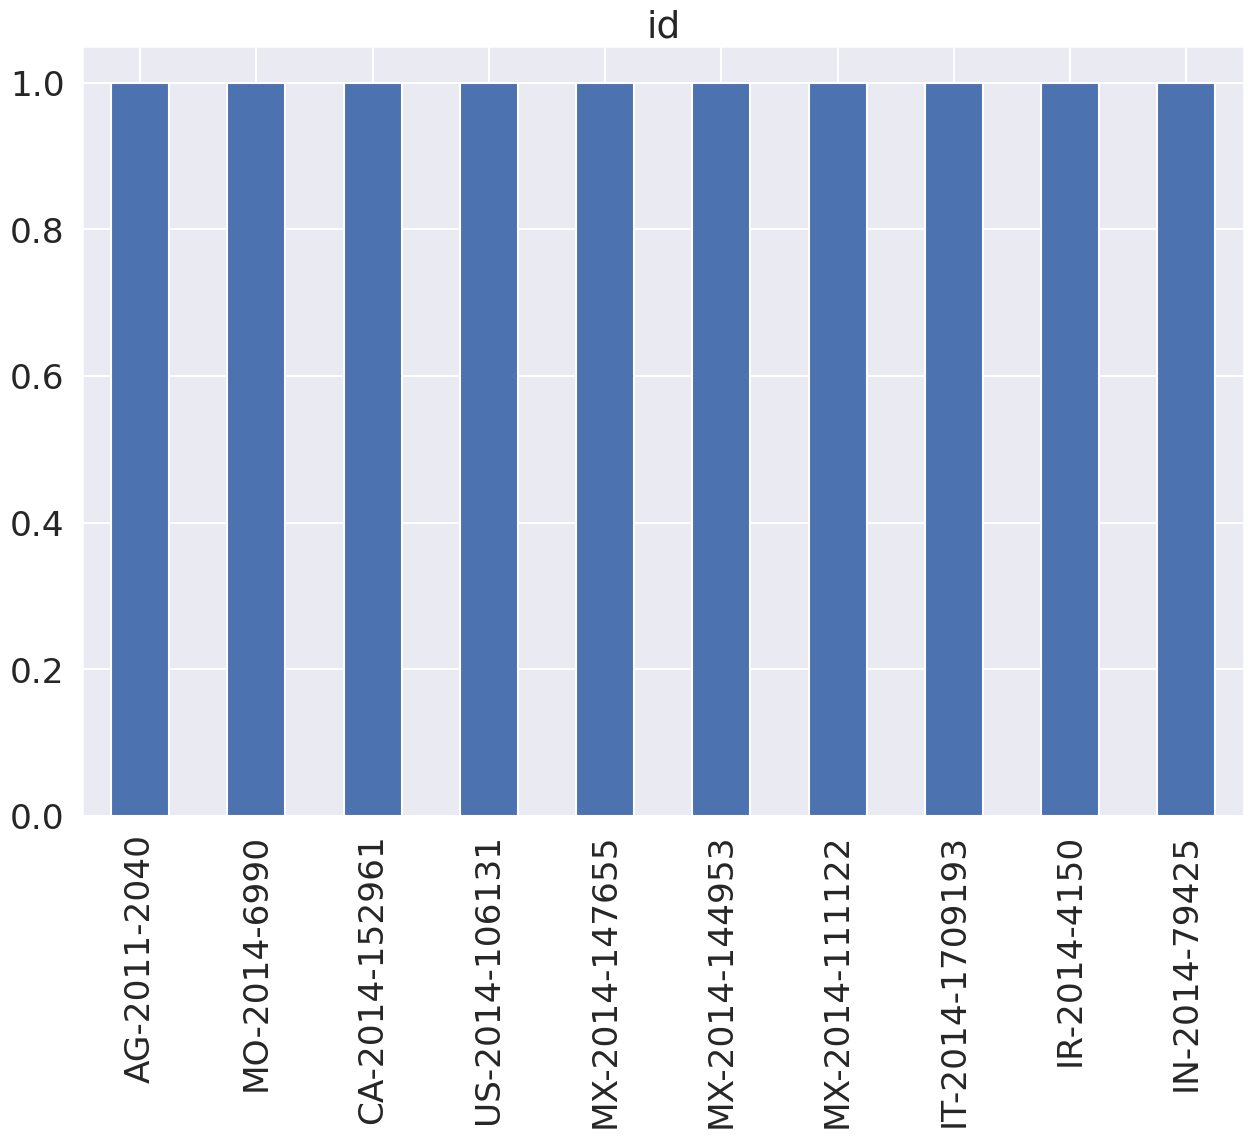

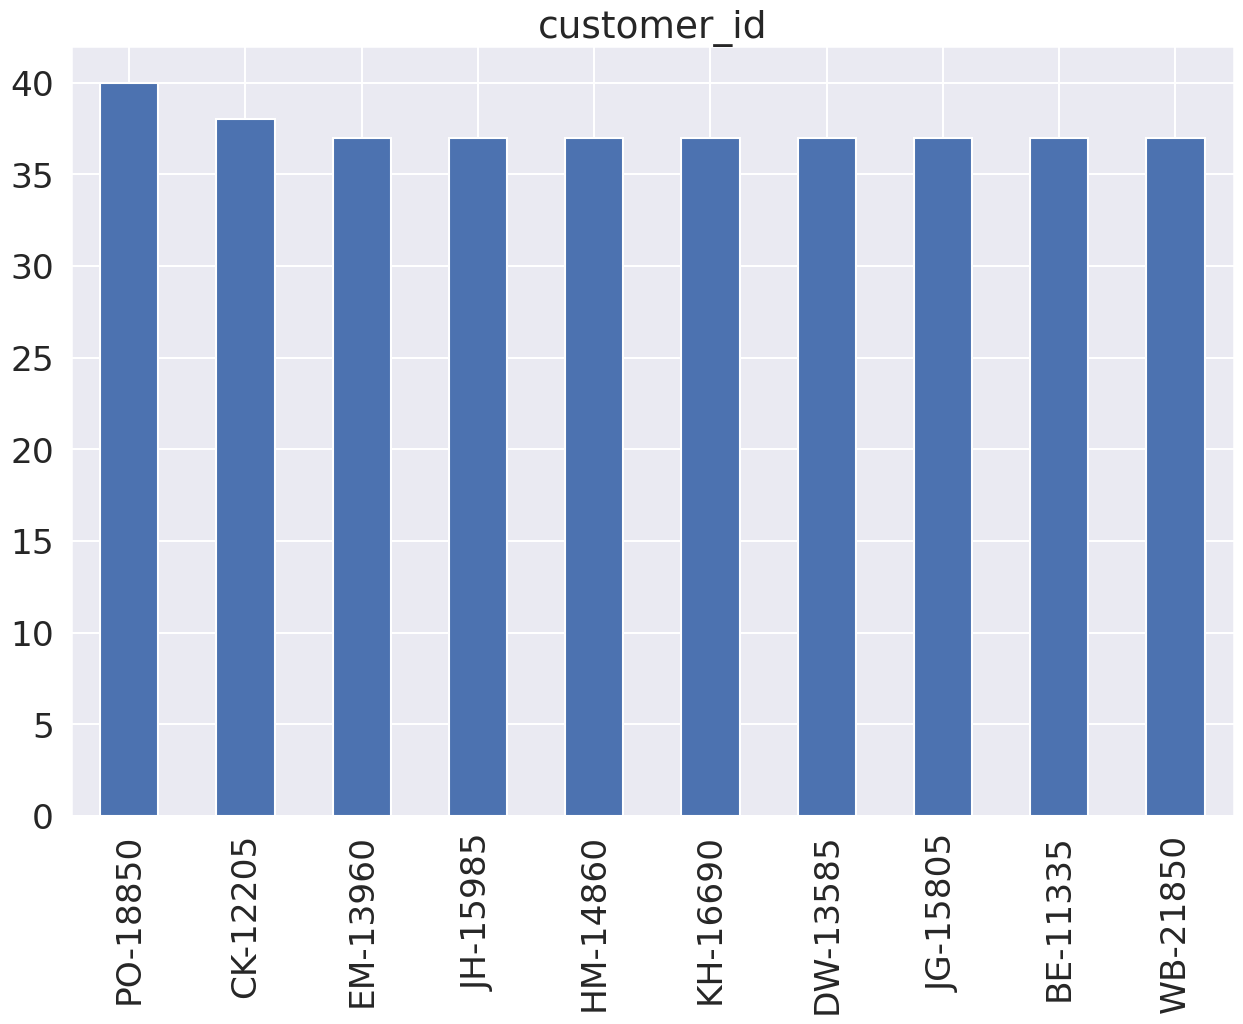

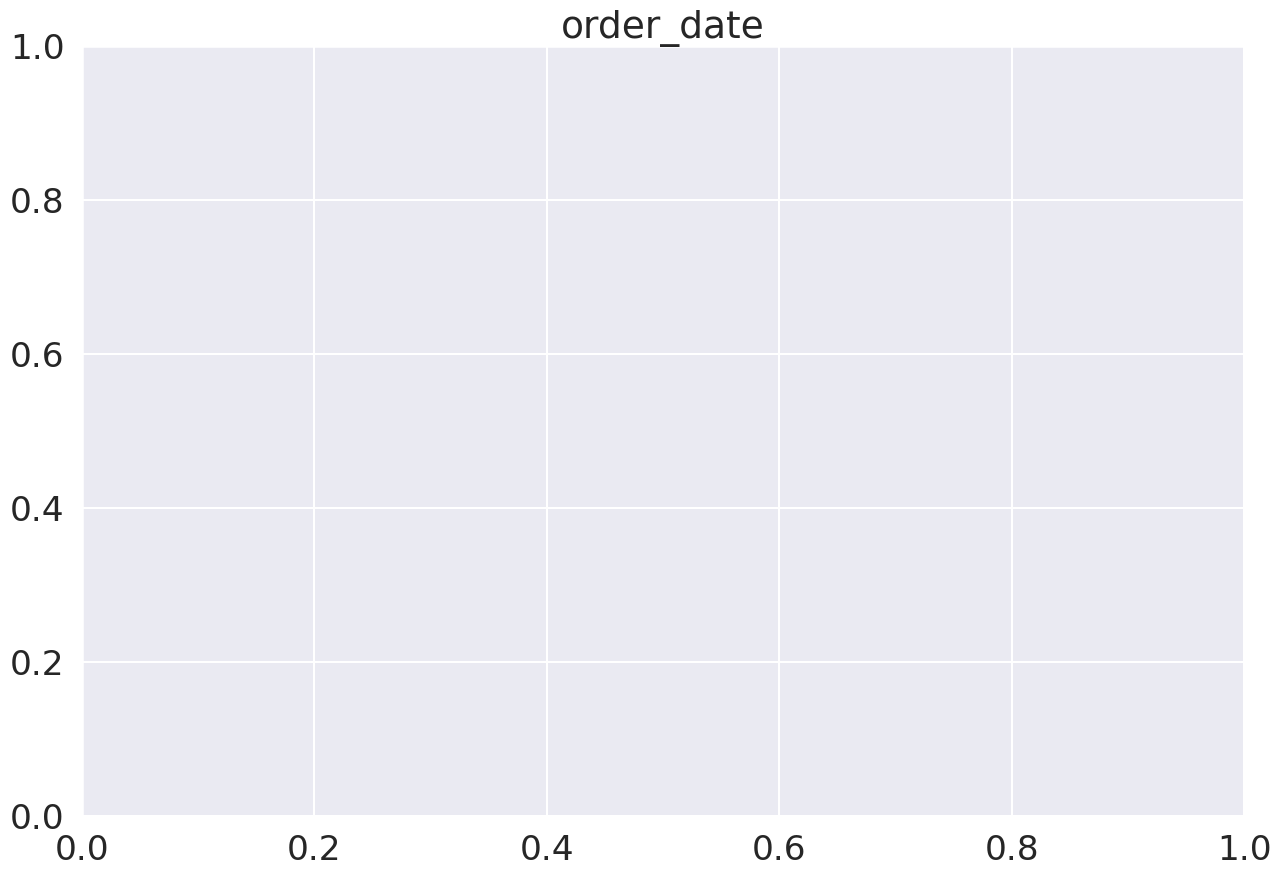

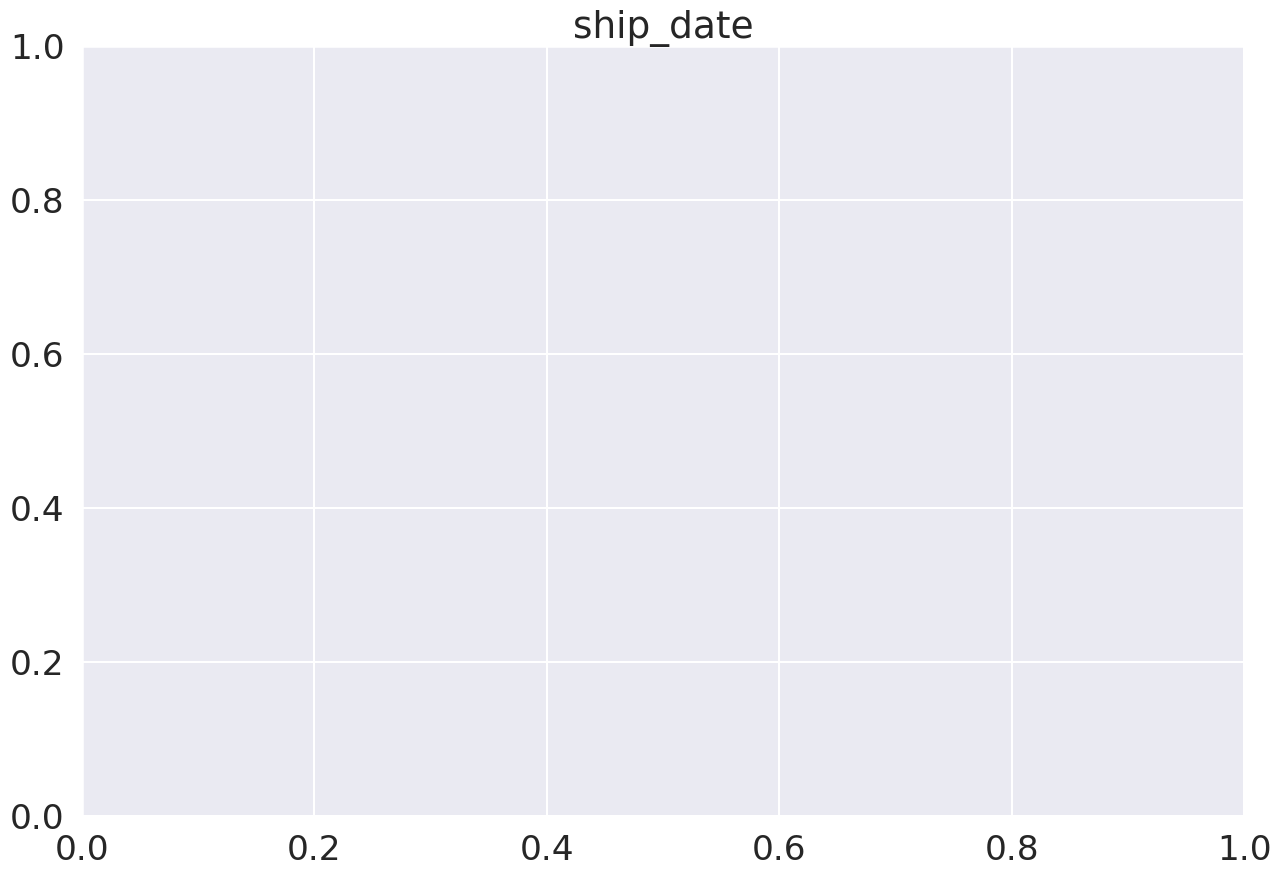

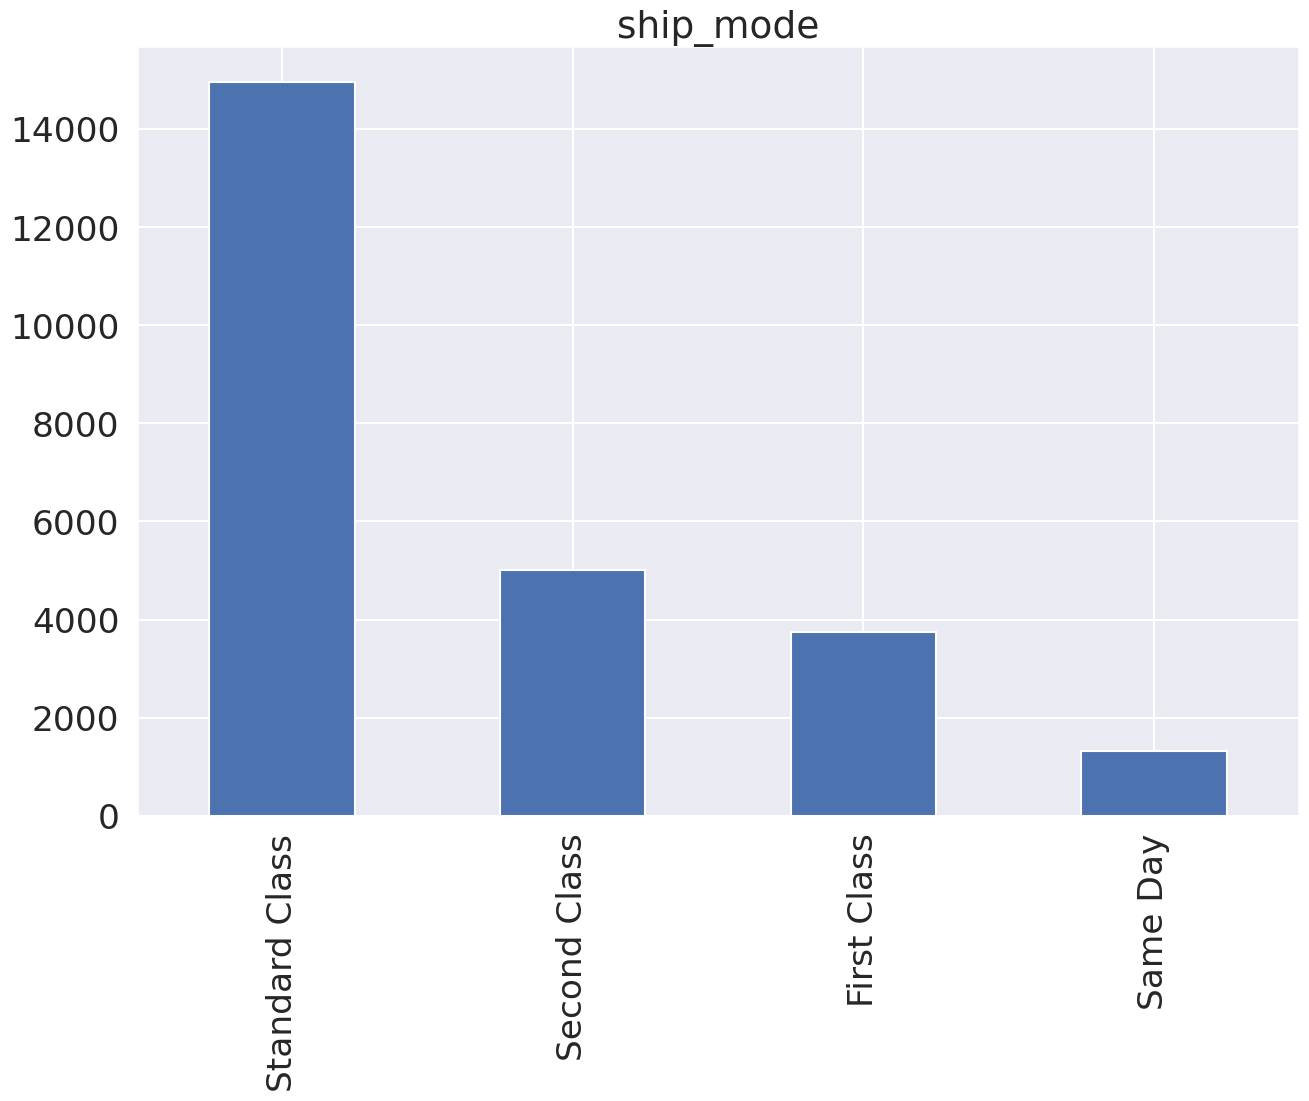

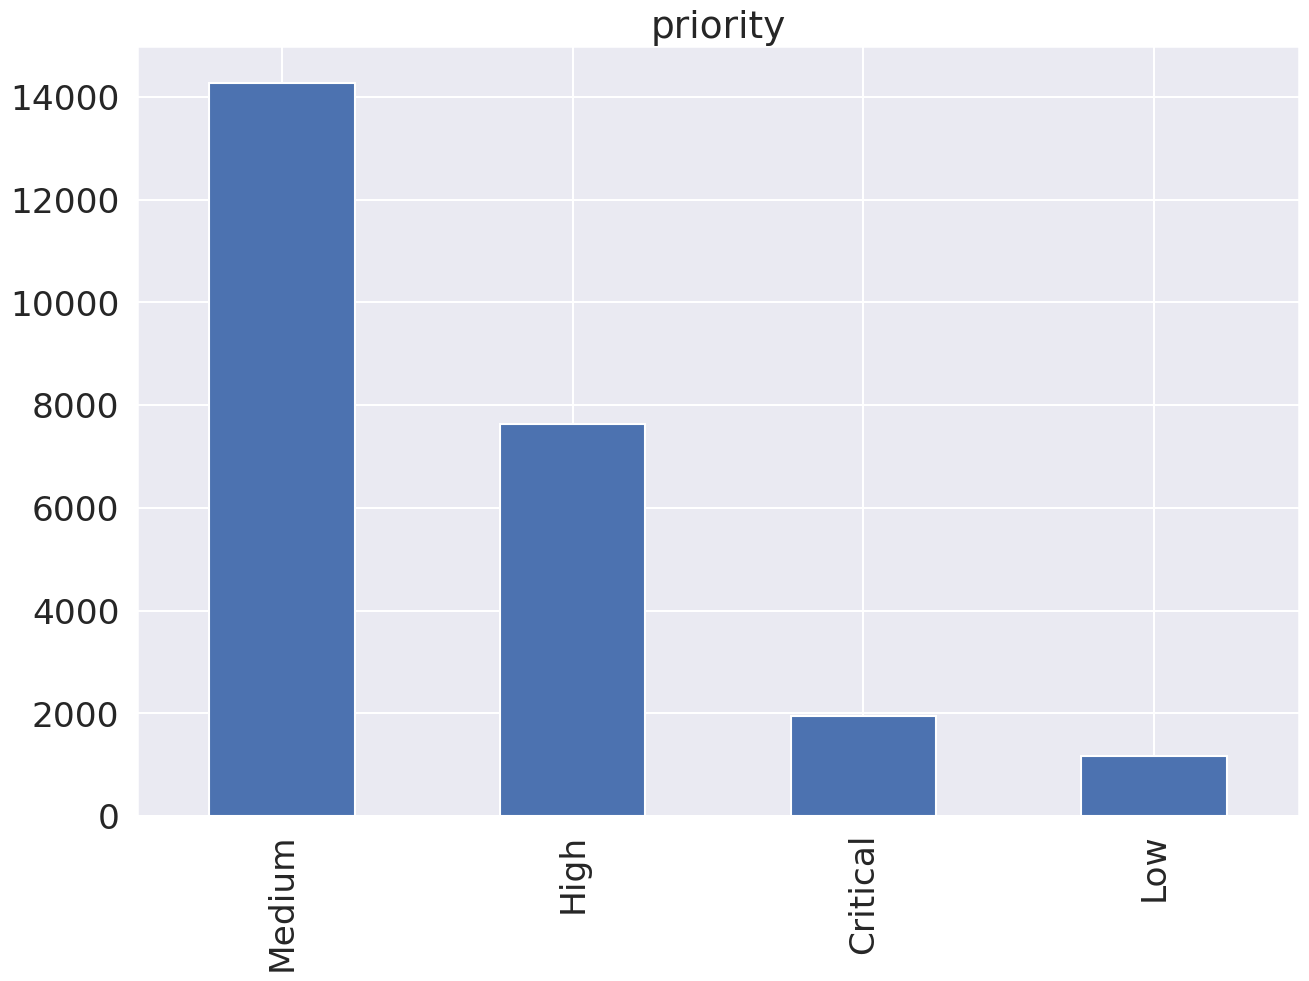

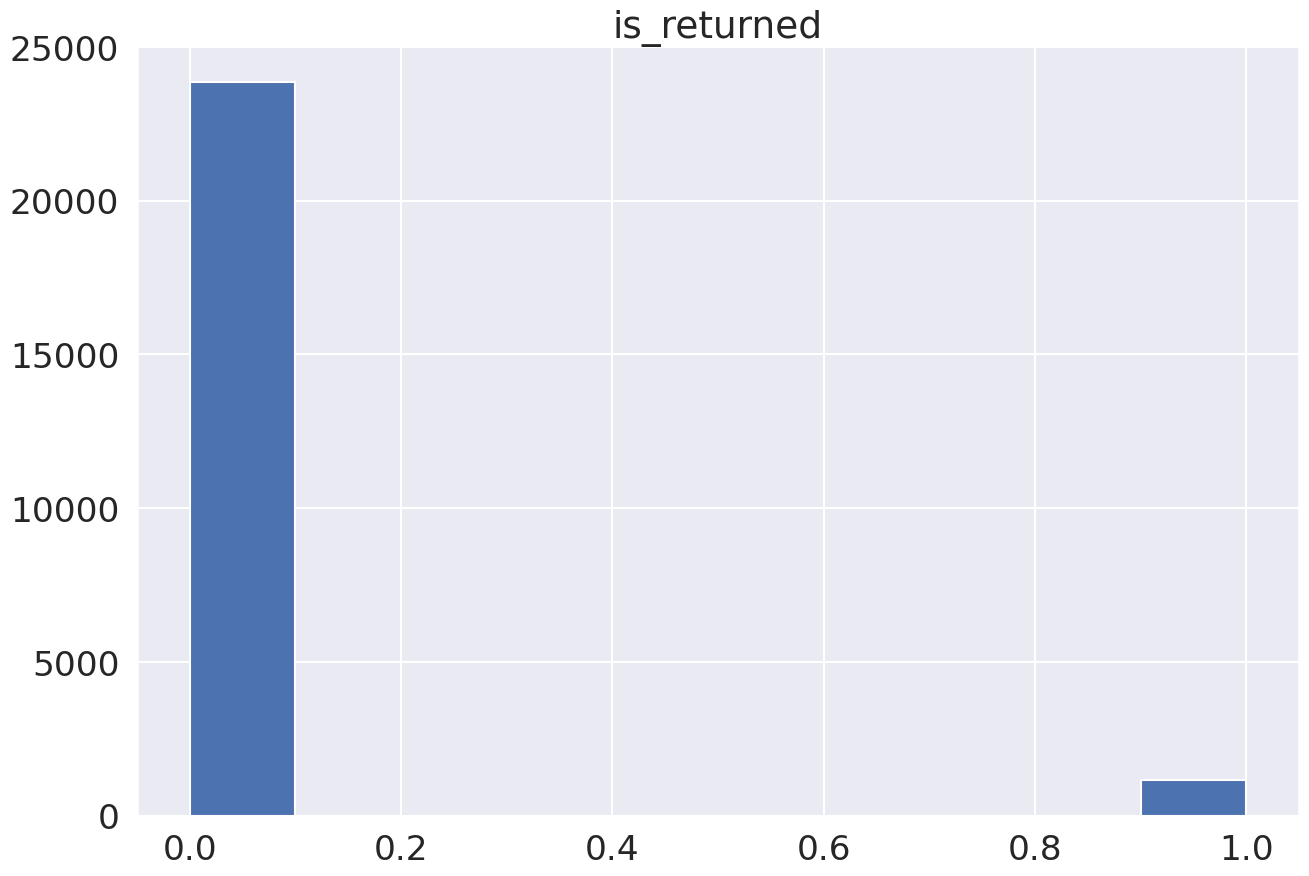

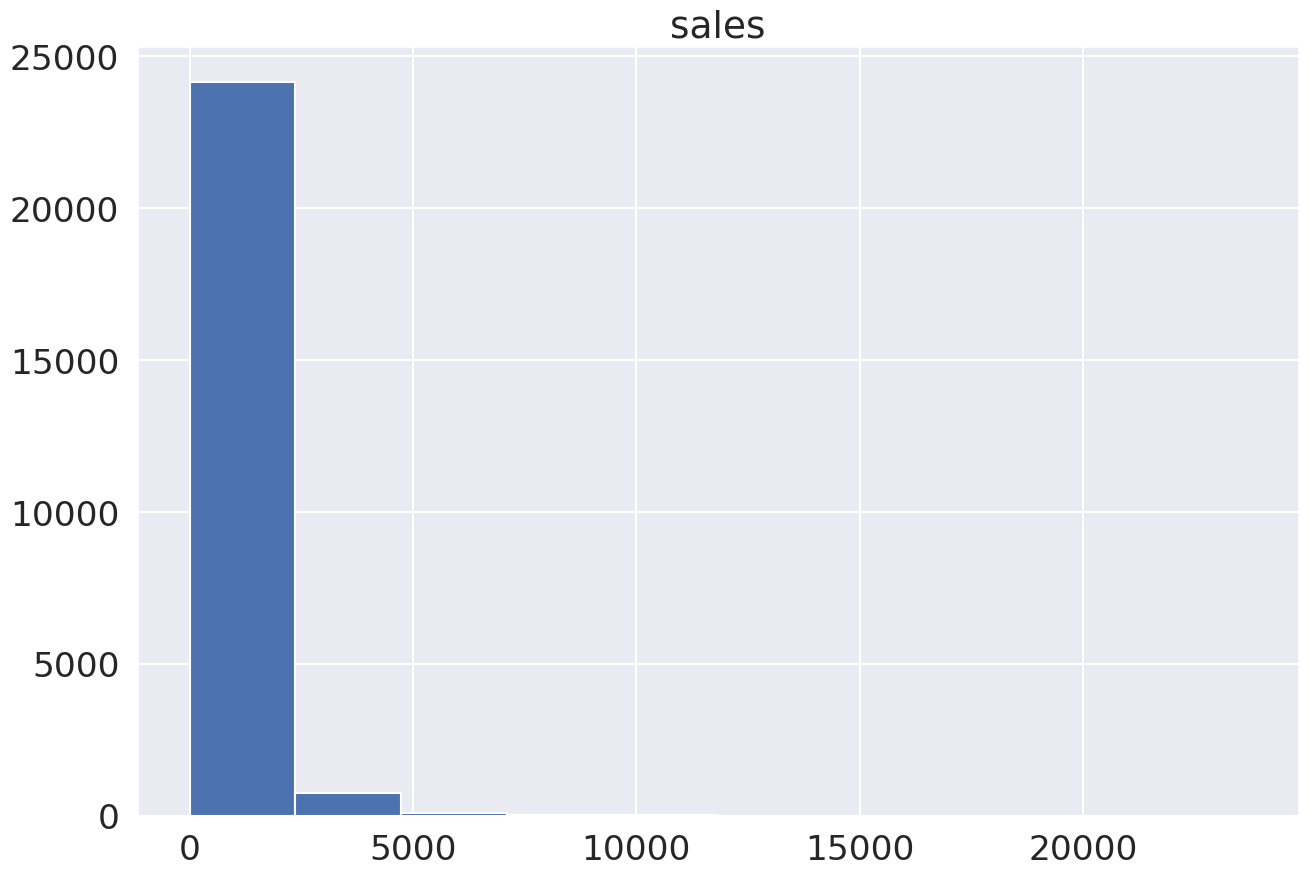

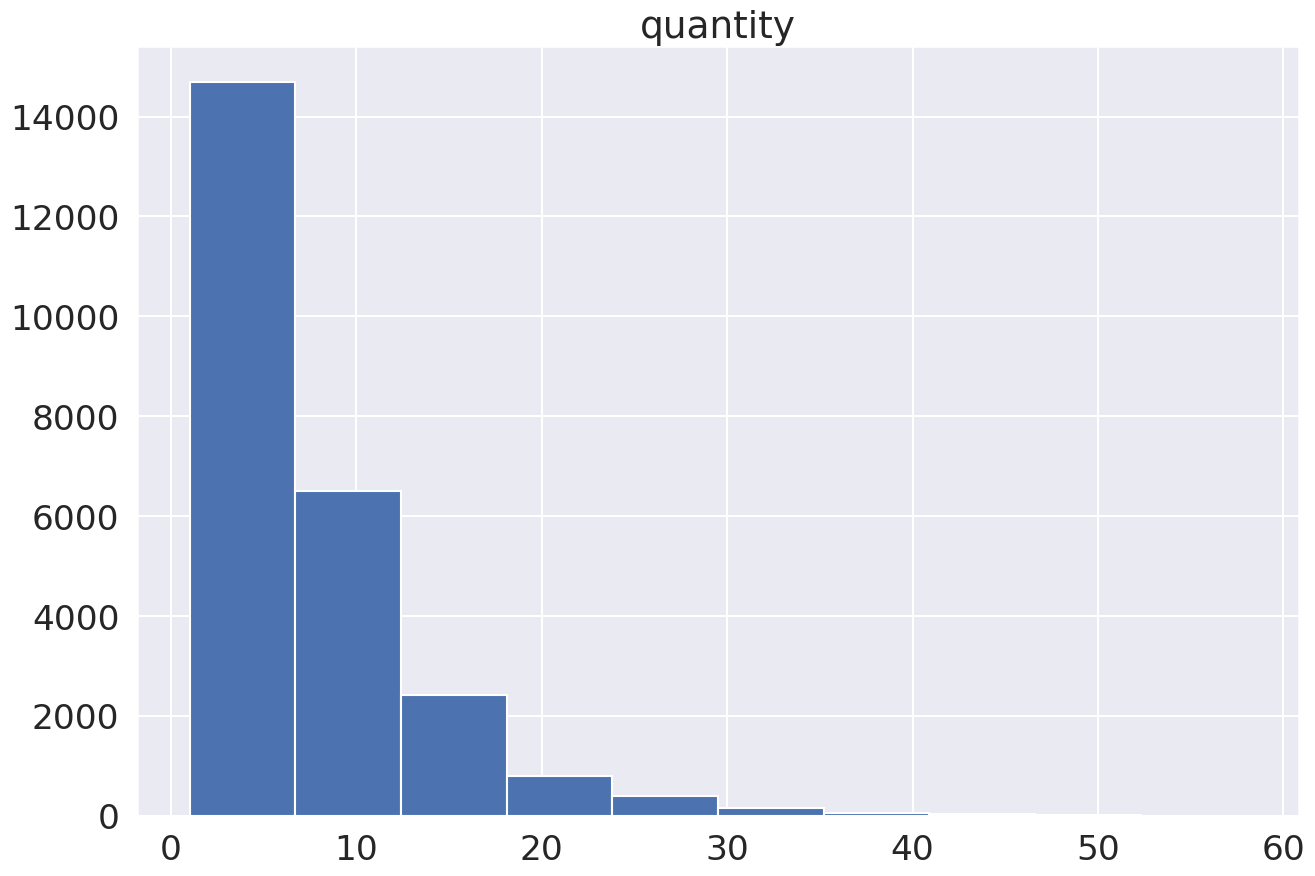

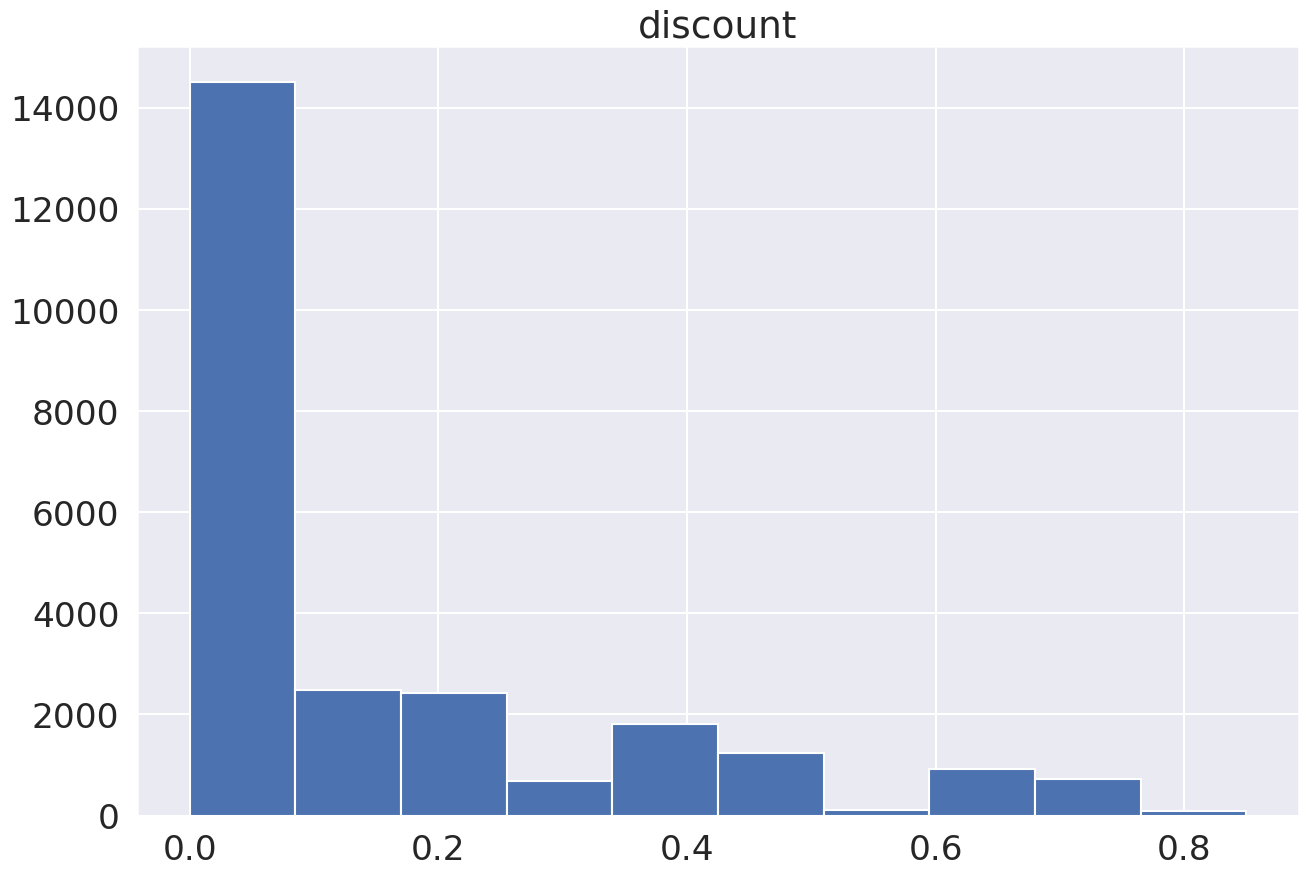

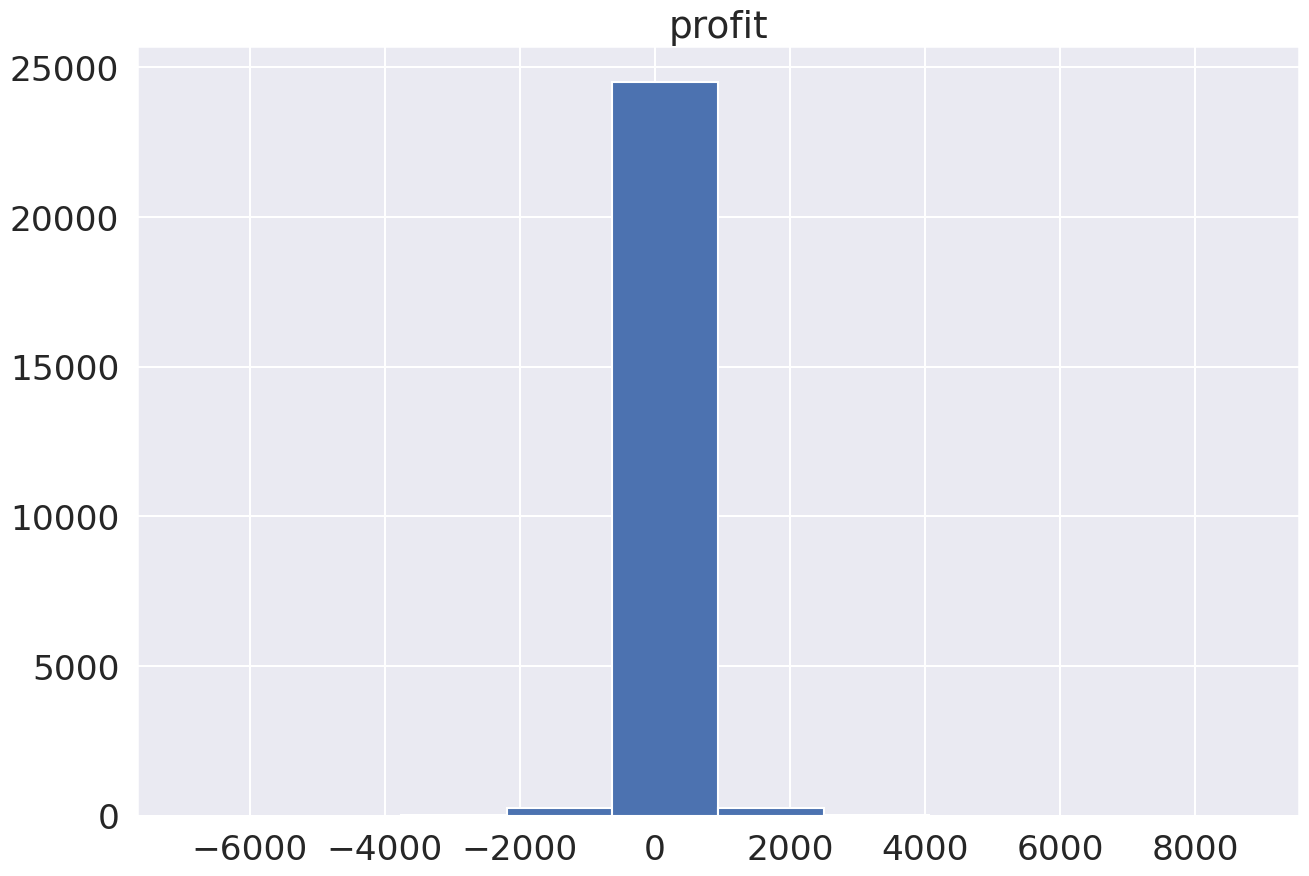

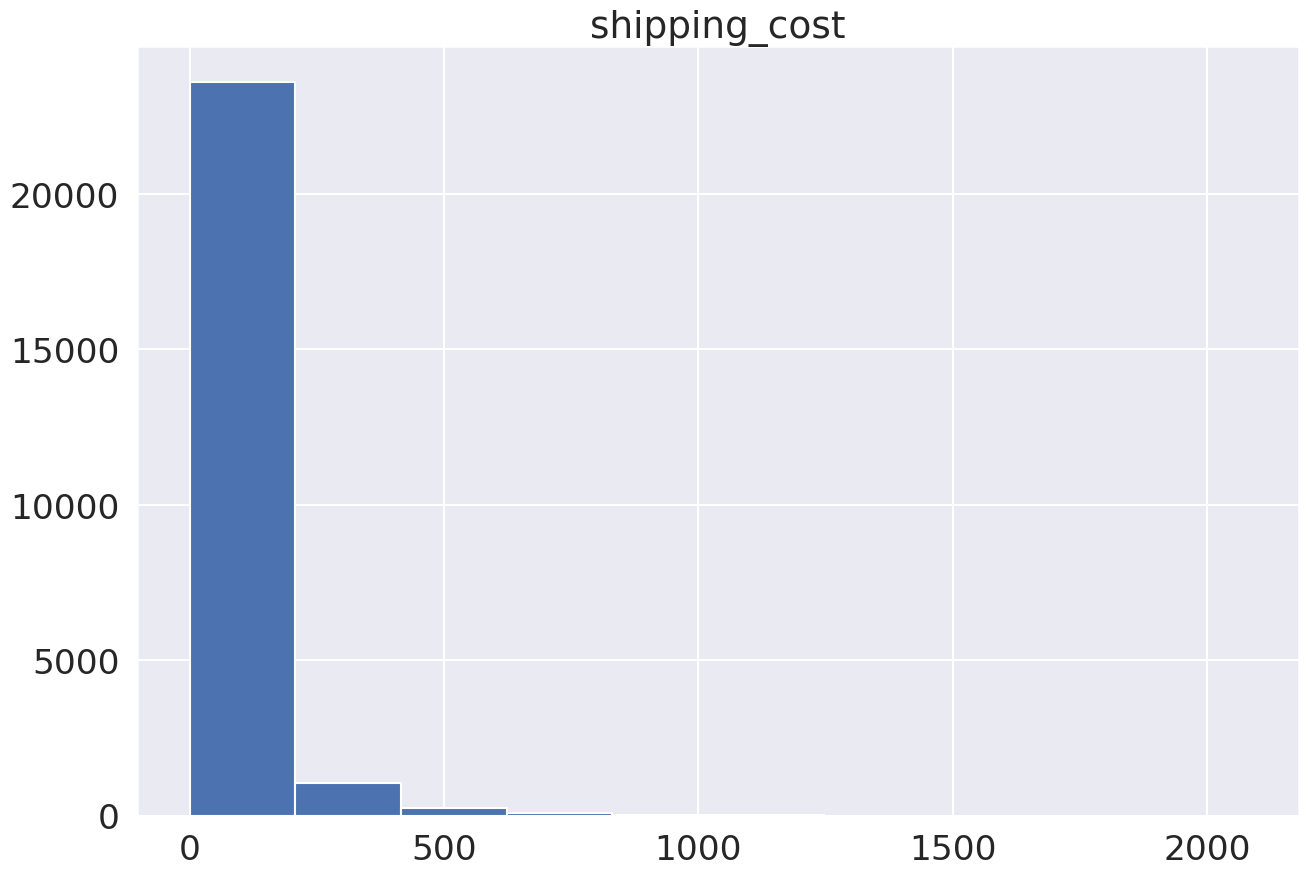

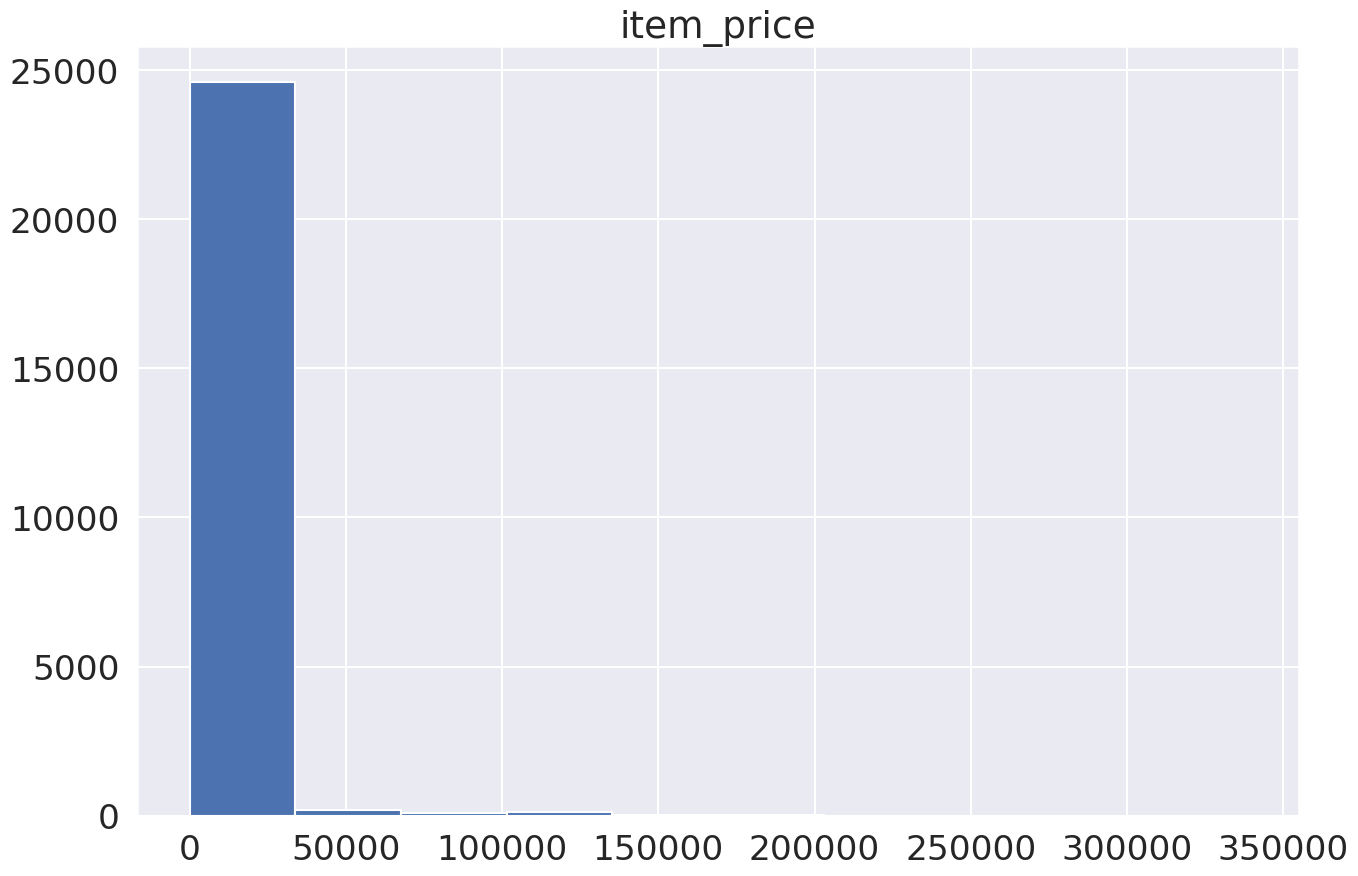

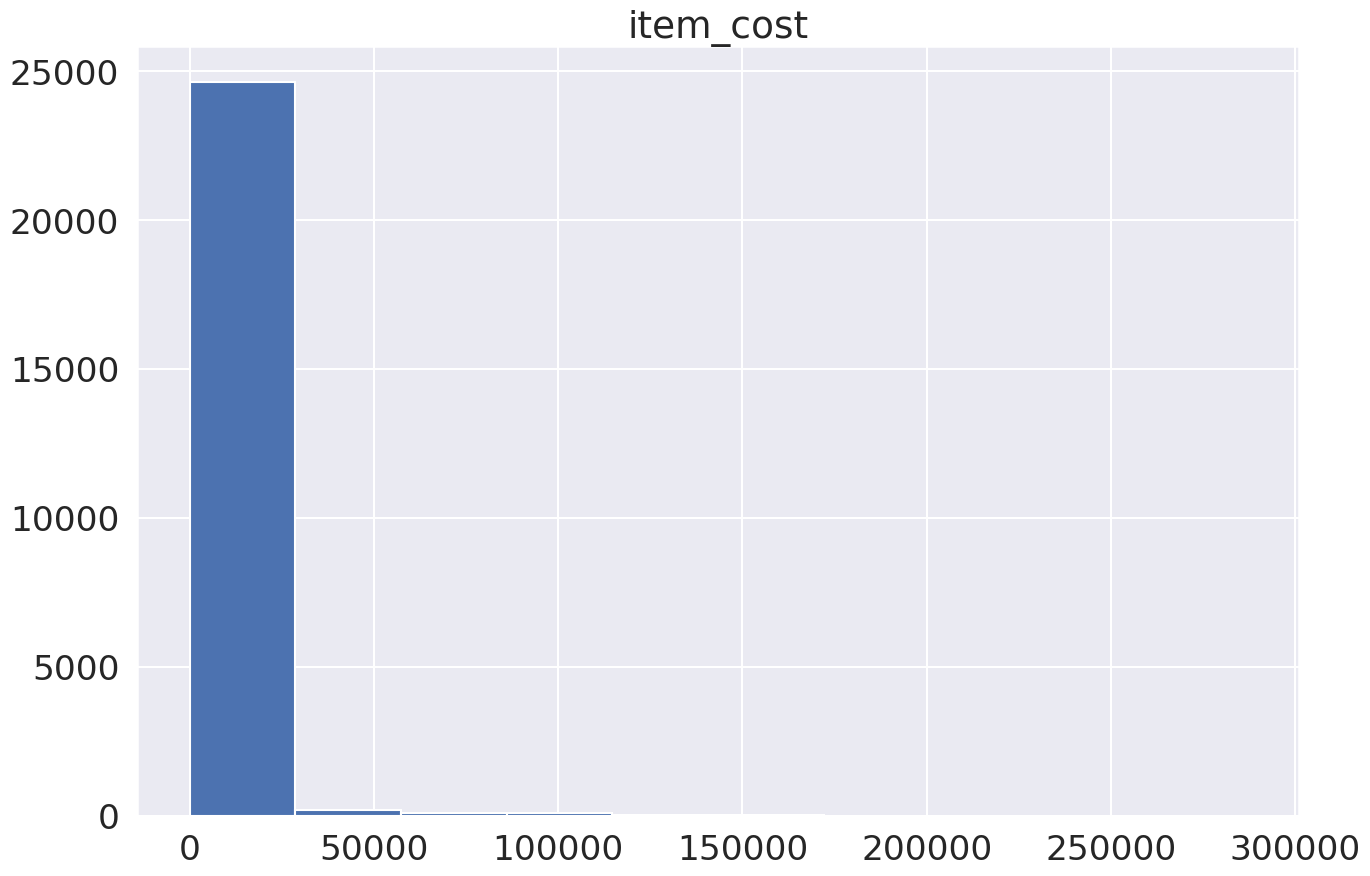

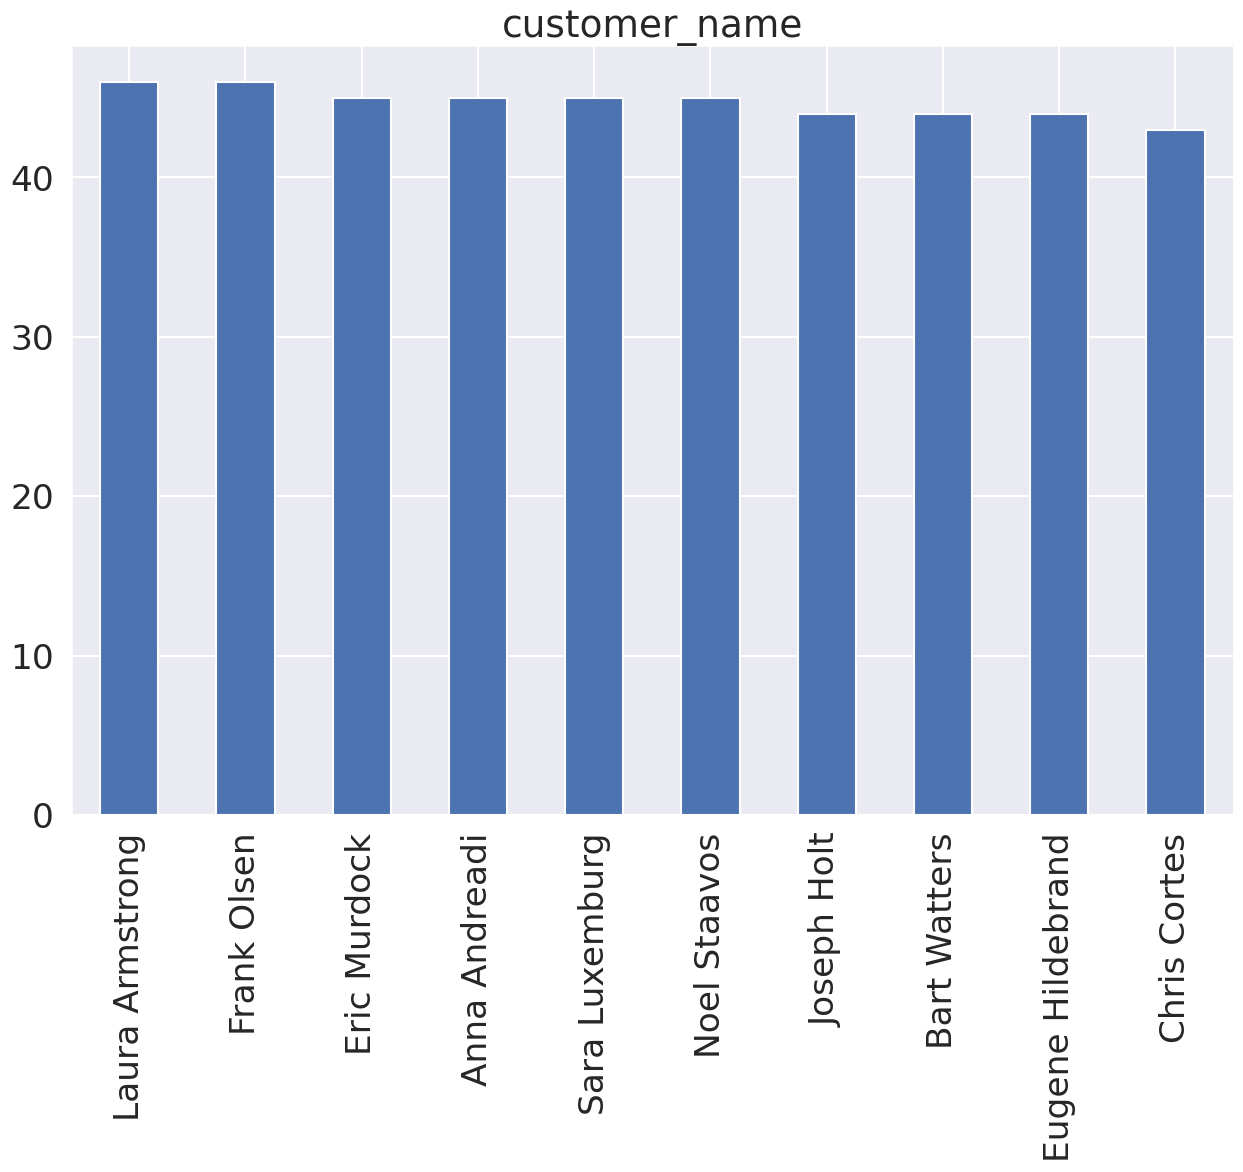

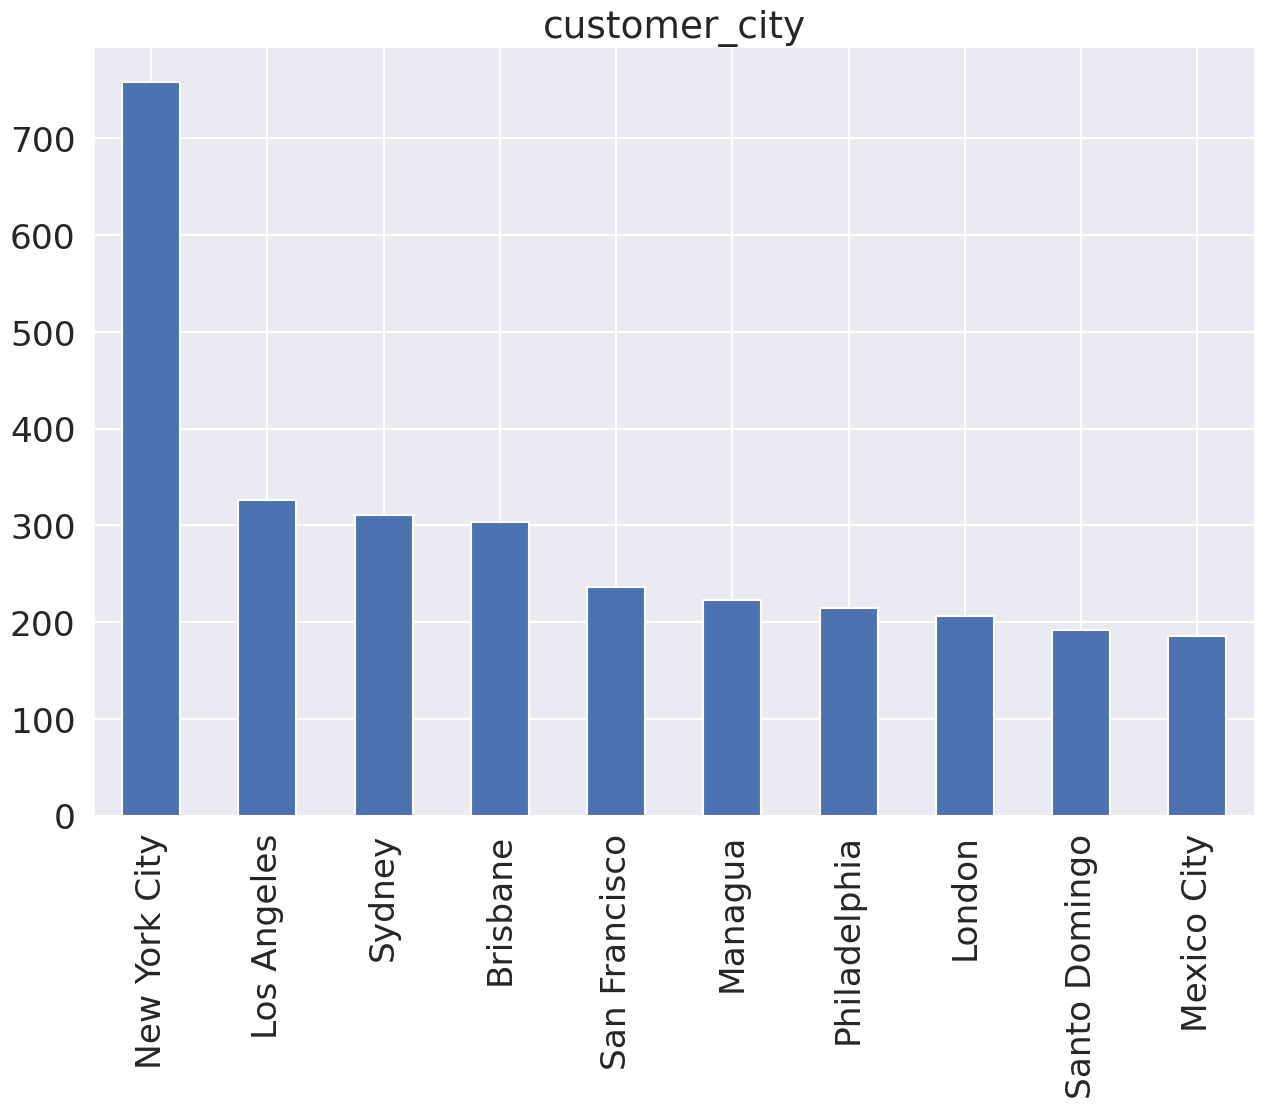

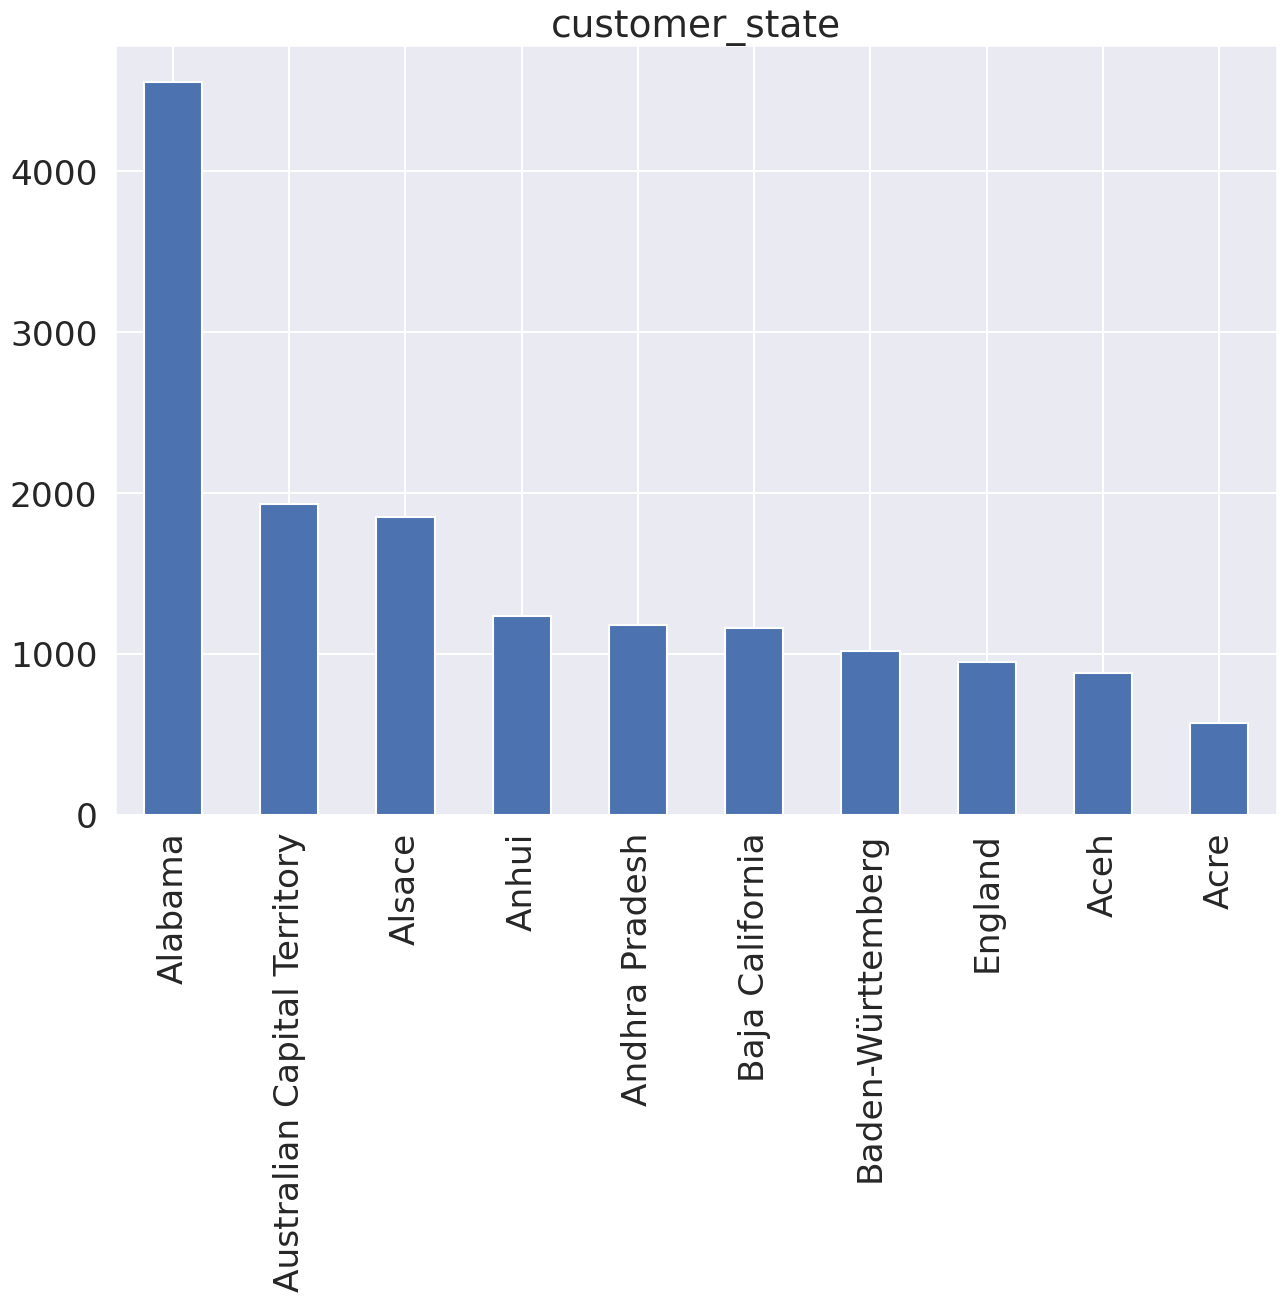

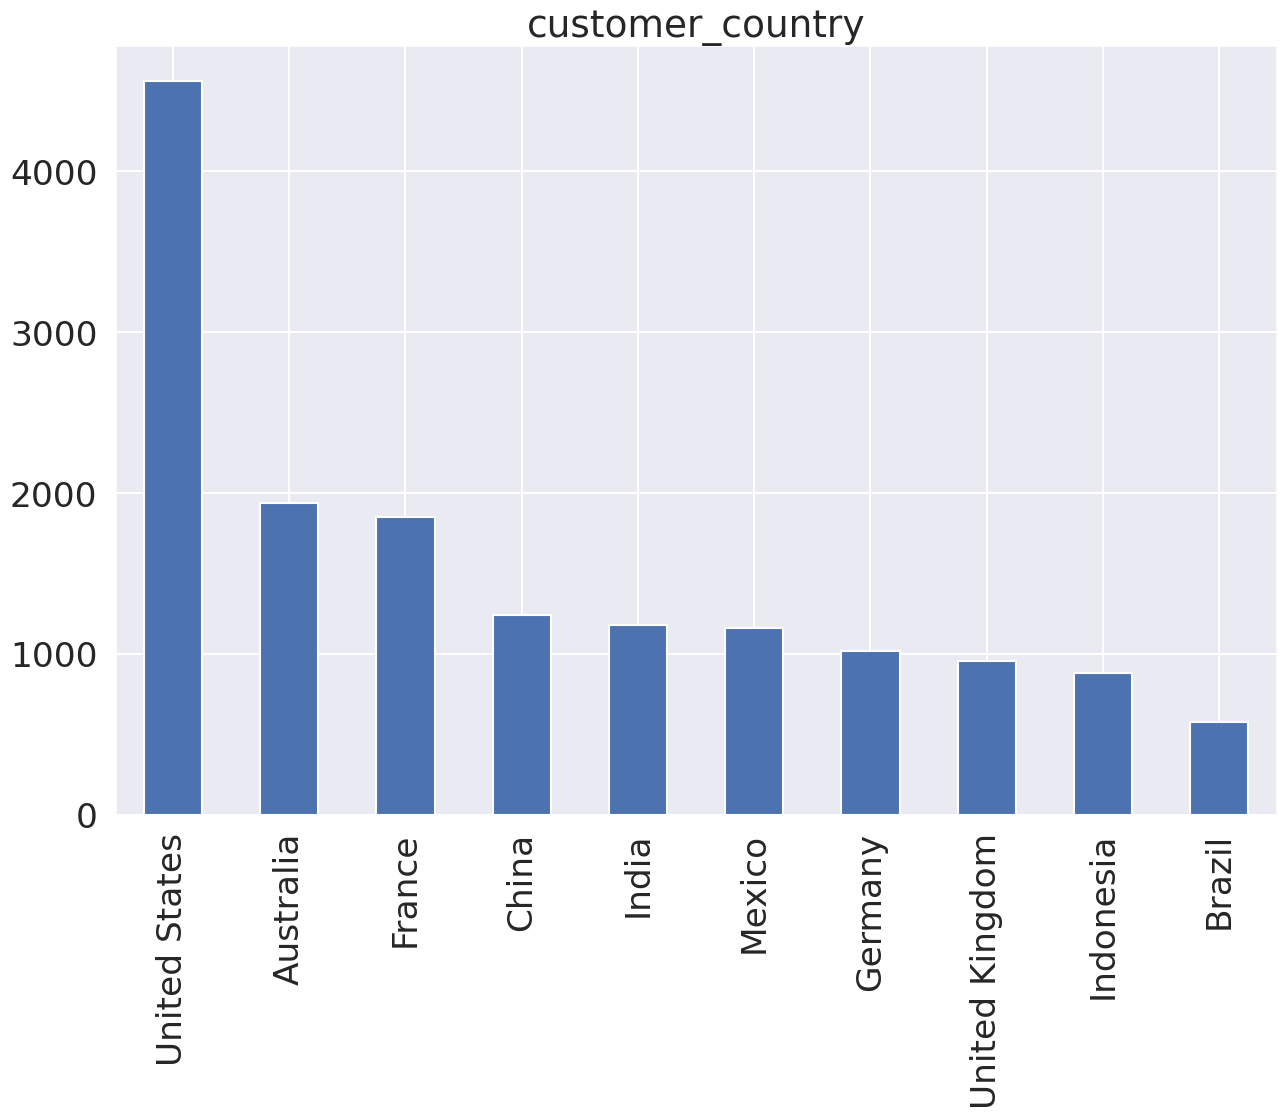

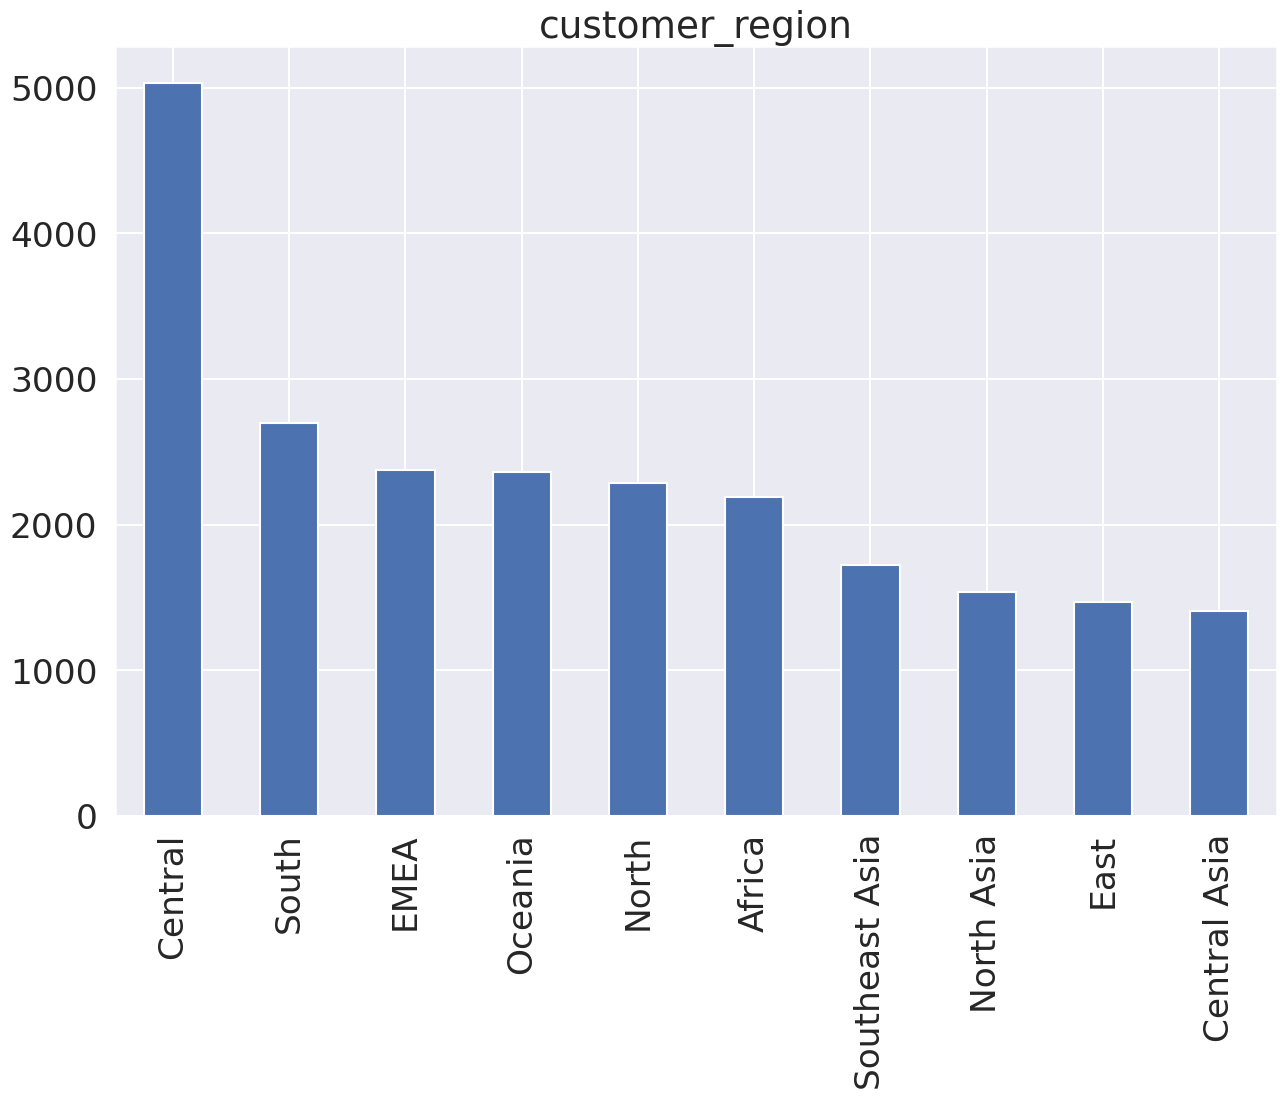

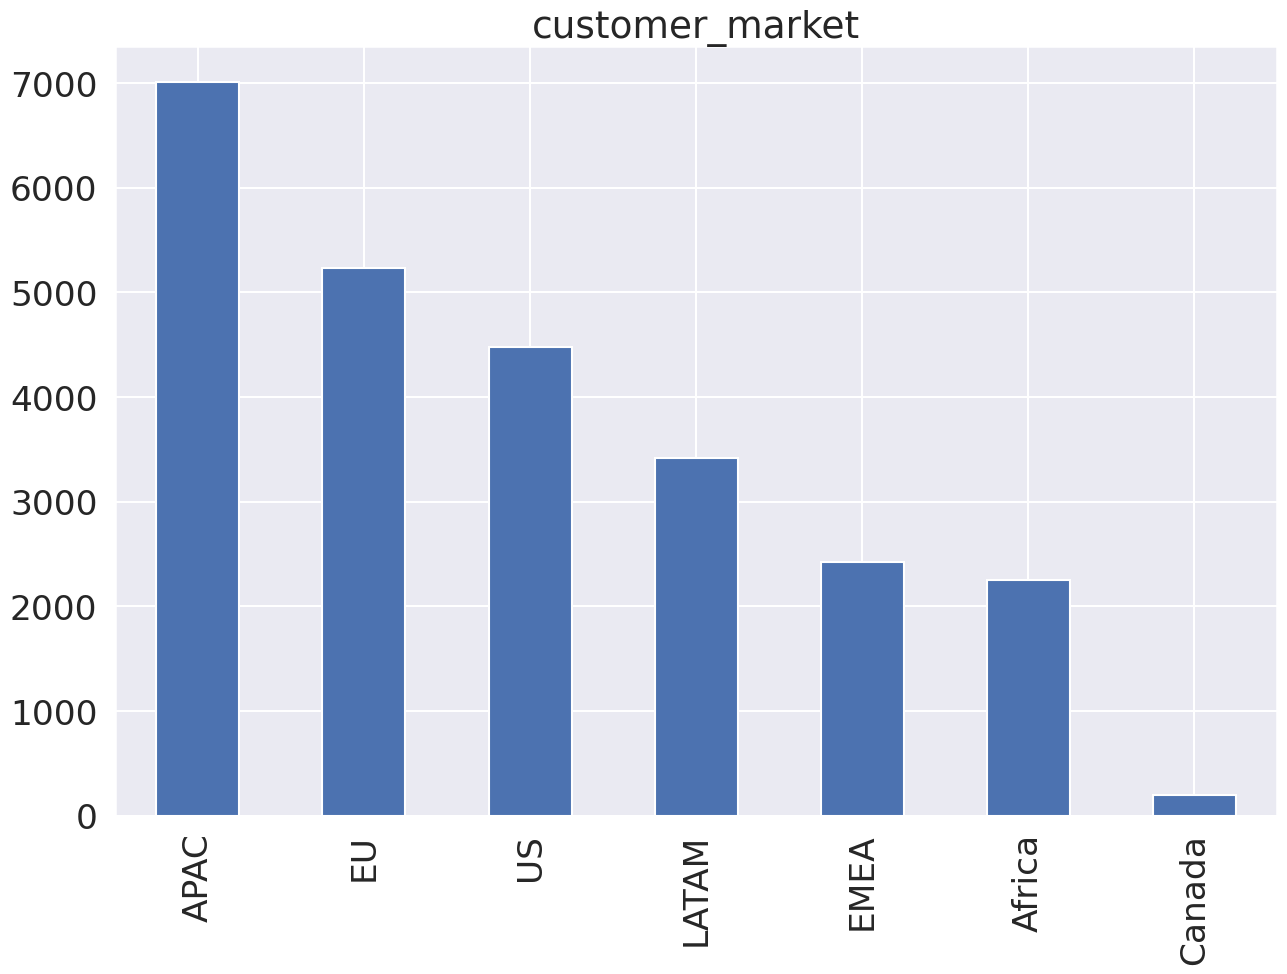

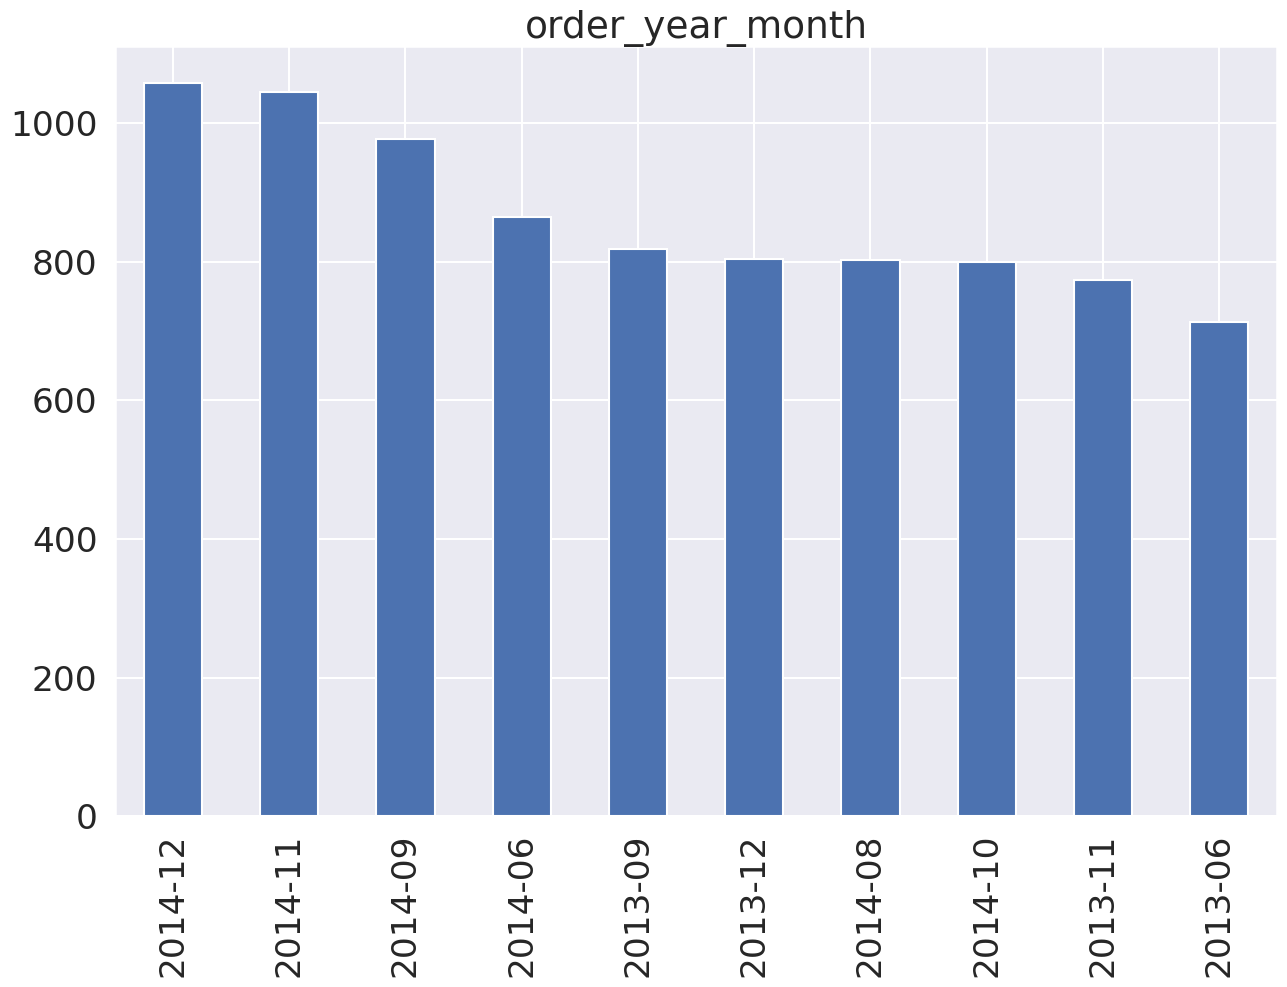

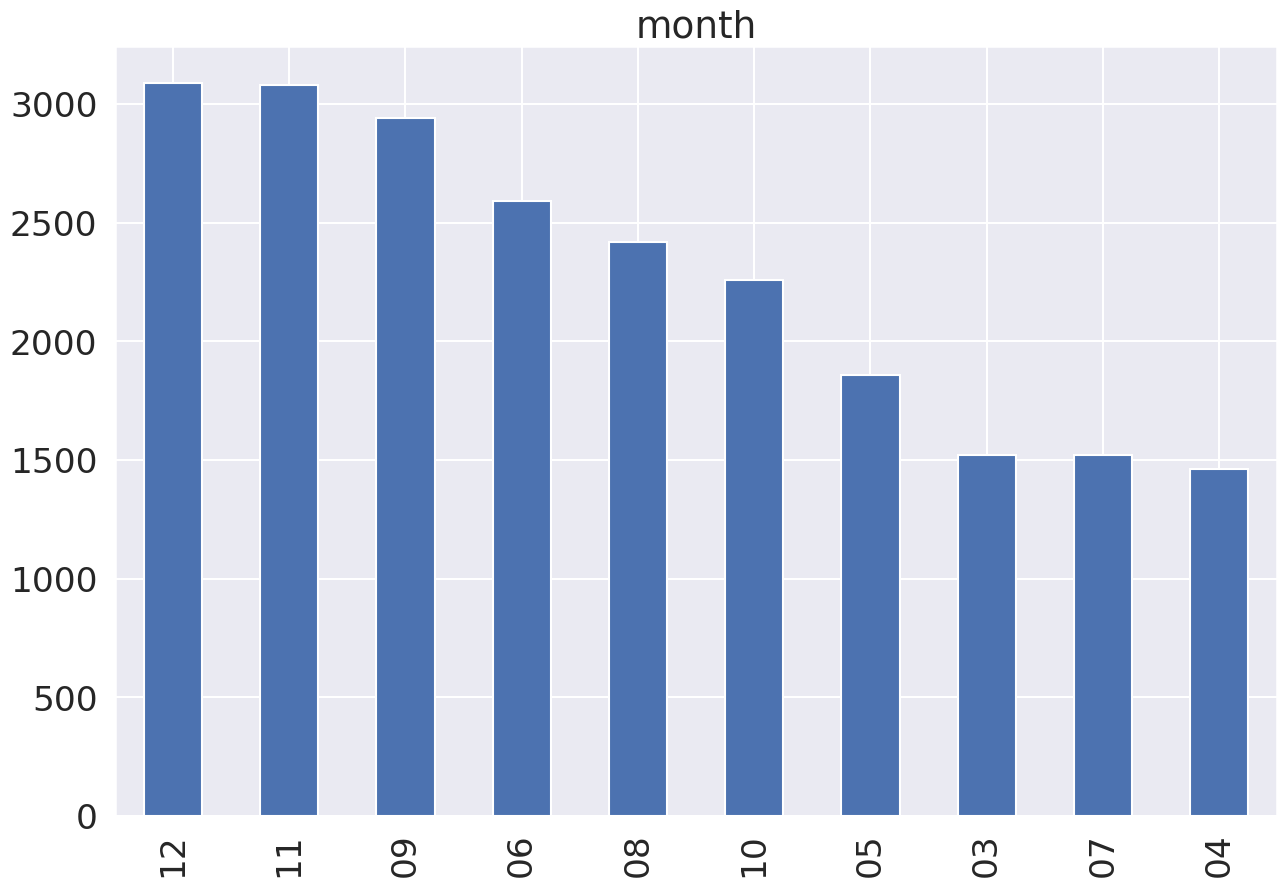

In [12]:
from pandas.core.dtypes.common import is_numeric_dtype, is_string_dtype

sns.set(rc={'figure.figsize':(15,10)})
sns.set_context('talk', font_scale=1.5)

for column in orders_df:
    plt.figure(column)
    plt.title(column)
    if is_numeric_dtype(orders_df[column]) and column != 'is_member':
        orders_df[column].hist()
    elif is_string_dtype(orders_df[column]):
        orders_df[column].value_counts()[:10].plot(kind='bar')

## multivariate analysis

/tmp/ipykernel_3286/341525201.py:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  correlation = correlation.mask(np.tril(np.ones(correlation.shape)).astype(np.bool))


<AxesSubplot: >

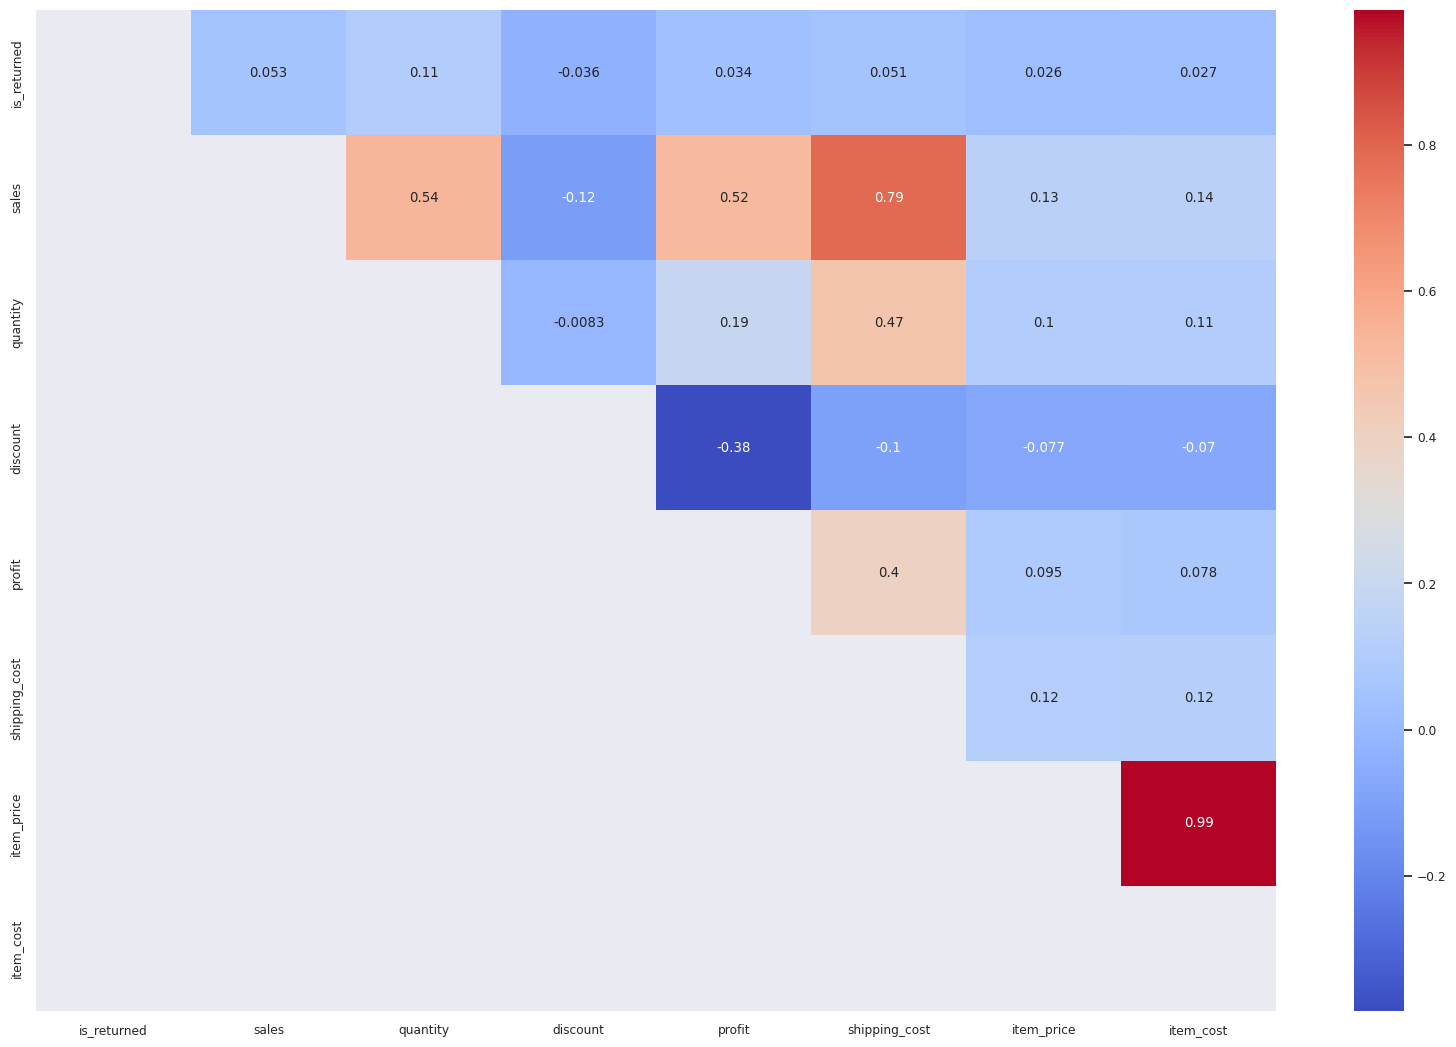

In [13]:
correlation = orders_df.corr(numeric_only=True)

correlation = correlation.mask(np.tril(np.ones(correlation.shape)).astype(np.bool))

sns.set(rc={'figure.figsize':(20,13)})
sns.set_context('notebook', font_scale=0.8)
sns.heatmap(correlation, annot=True, cmap='coolwarm')

In [14]:
## sales in different months

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]),
 [Text(0, 0, '2011-01'),
  Text(1, 0, '2011-02'),
  Text(2, 0, '2011-03'),
  Text(3, 0, '2011-04'),
  Text(4, 0, '2011-05'),
  Text(5, 0, '2011-06'),
  Text(6, 0, '2011-07'),
  Text(7, 0, '2011-08'),
  Text(8, 0, '2011-09'),
  Text(9, 0, '2011-10'),
  Text(10, 0, '2011-11'),
  Text(11, 0, '2011-12'),
  Text(12, 0, '2012-01'),
  Text(13, 0, '2012-02'),
  Text(14, 0, '2012-03'),
  Text(15, 0, '2012-04'),
  Text(16, 0, '2012-05'),
  Text(17, 0, '2012-06'),
  Text(18, 0, '2012-07'),
  Text(19, 0, '2012-08'),
  Text(20, 0, '2012-09'),
  Text(21, 0, '2012-10'),
  Text(22, 0, '2012-11'),
  Text(23, 0, '2012-12'),
  Text(24, 0, '2013-01'),
  Text(25, 0, '2013-02'),
  Text(26, 0, '2013-03'),
  Text(27, 0, '2013-04'),
  Text(28, 0, '2013-05'),
  Text(29, 0, '2013-06'),
  Text(30, 0

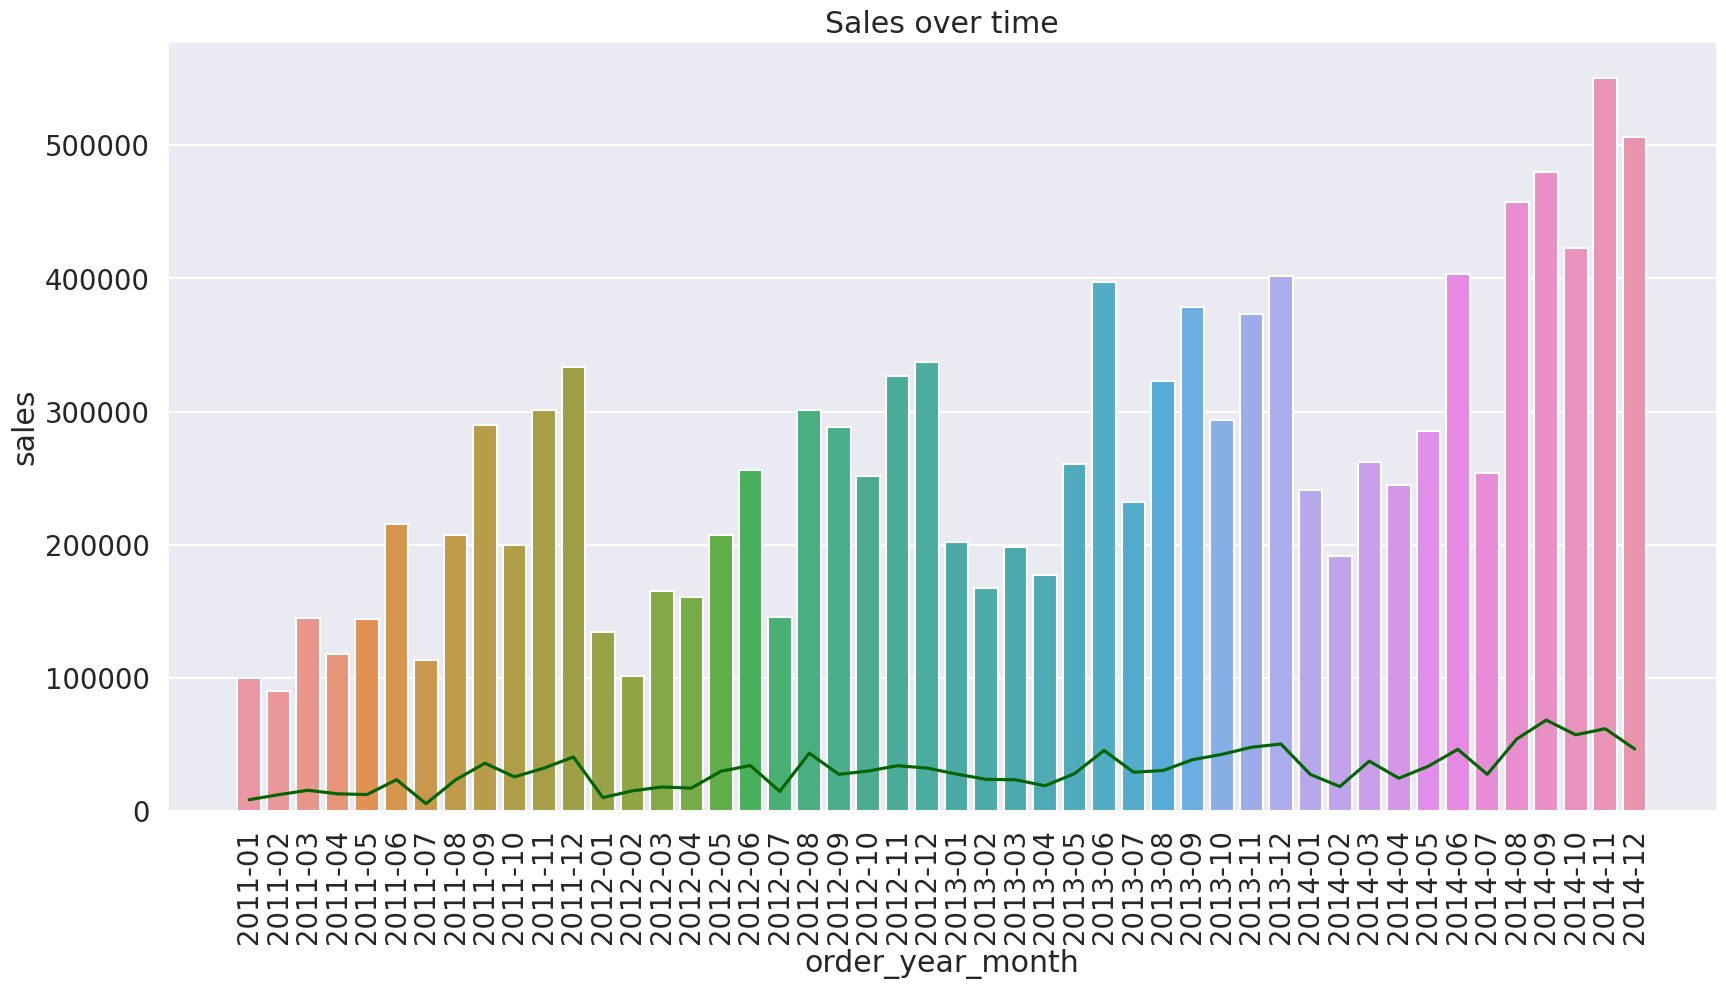

In [15]:
d = orders_df.groupby('order_year_month').agg({'sales': 'sum'}).reset_index()
d2 = orders_df.groupby('order_year_month').agg({'profit': 'sum'}).reset_index()

plt.figure(figsize=(20, 10))
sns.set_context('talk', font_scale=1.2)
sns.barplot(d, x='order_year_month', y='sales').set_title('Sales over time')
sns.lineplot(d2, x='order_year_month', y='profit', color='darkgreen').set_title('Sales over time')
plt.xticks(rotation=90)


## sales by month and category

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 [Text(0, 0, '01'),
  Text(1, 0, '02'),
  Text(2, 0, '03'),
  Text(3, 0, '04'),
  Text(4, 0, '05'),
  Text(5, 0, '06'),
  Text(6, 0, '07'),
  Text(7, 0, '08'),
  Text(8, 0, '09'),
  Text(9, 0, '10'),
  Text(10, 0, '11'),
  Text(11, 0, '12')])

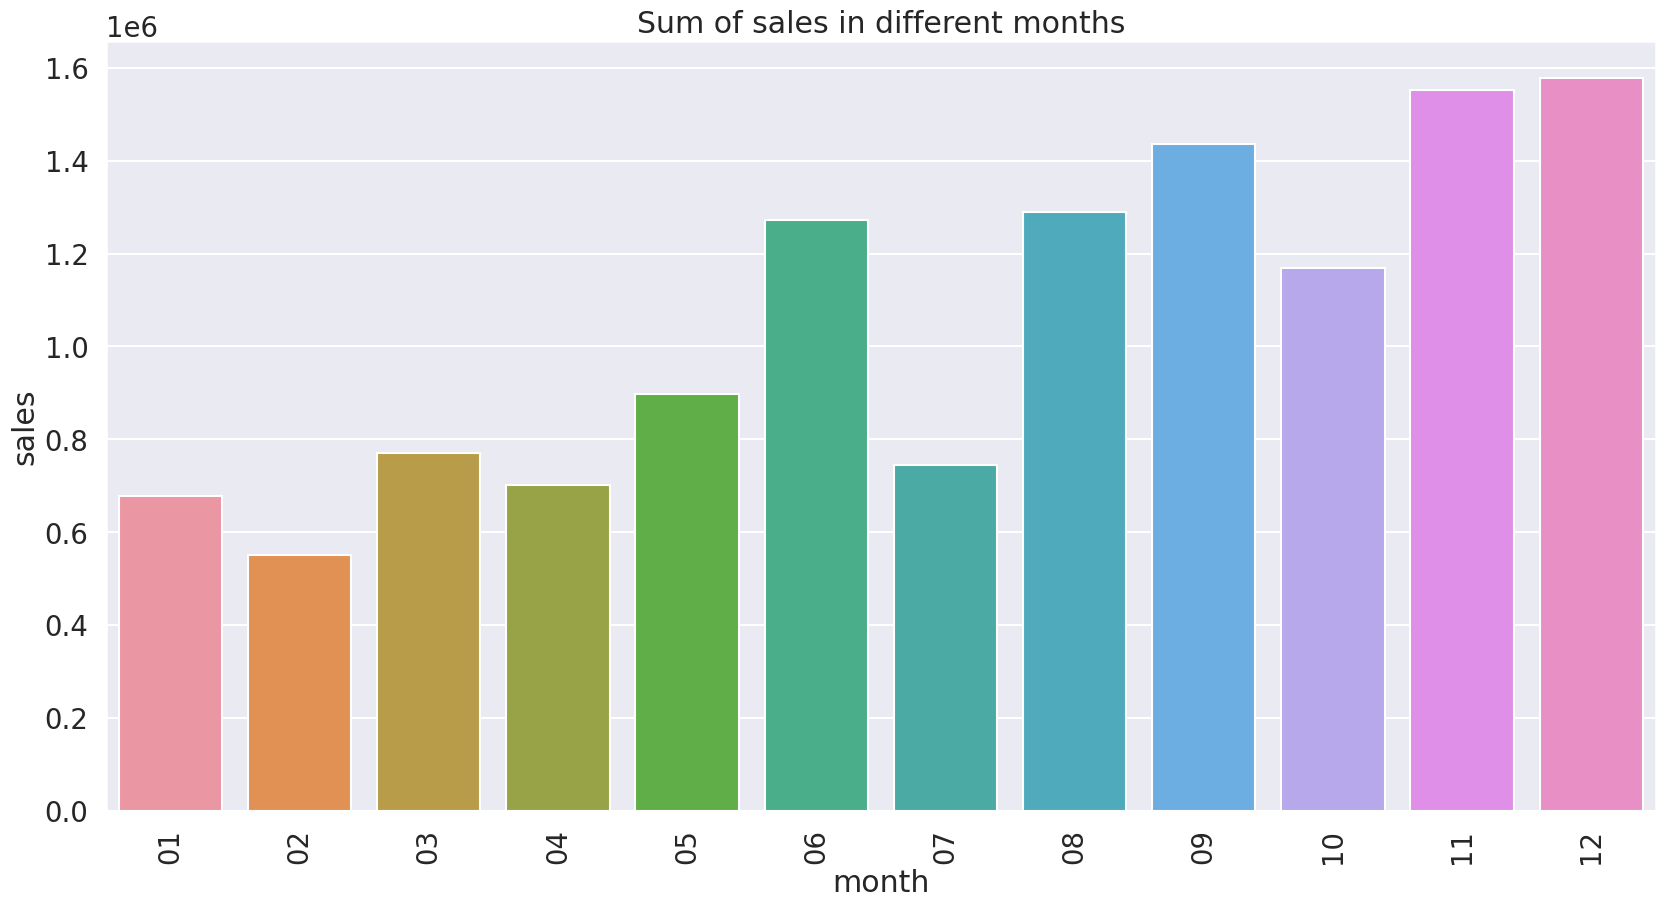

In [16]:
d = orders_df.groupby(['month']).agg({'sales': 'sum'}).reset_index()

plt.figure(figsize=(20, 10))
sns.set_context('talk', font_scale=1.2)
sns.barplot(d, x='month', y='sales').set_title('Sum of sales in different months')
plt.xticks(rotation=90)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 [Text(0, 0, '01'),
  Text(1, 0, '02'),
  Text(2, 0, '03'),
  Text(3, 0, '04'),
  Text(4, 0, '05'),
  Text(5, 0, '06'),
  Text(6, 0, '07'),
  Text(7, 0, '08'),
  Text(8, 0, '09'),
  Text(9, 0, '10'),
  Text(10, 0, '11'),
  Text(11, 0, '12')])

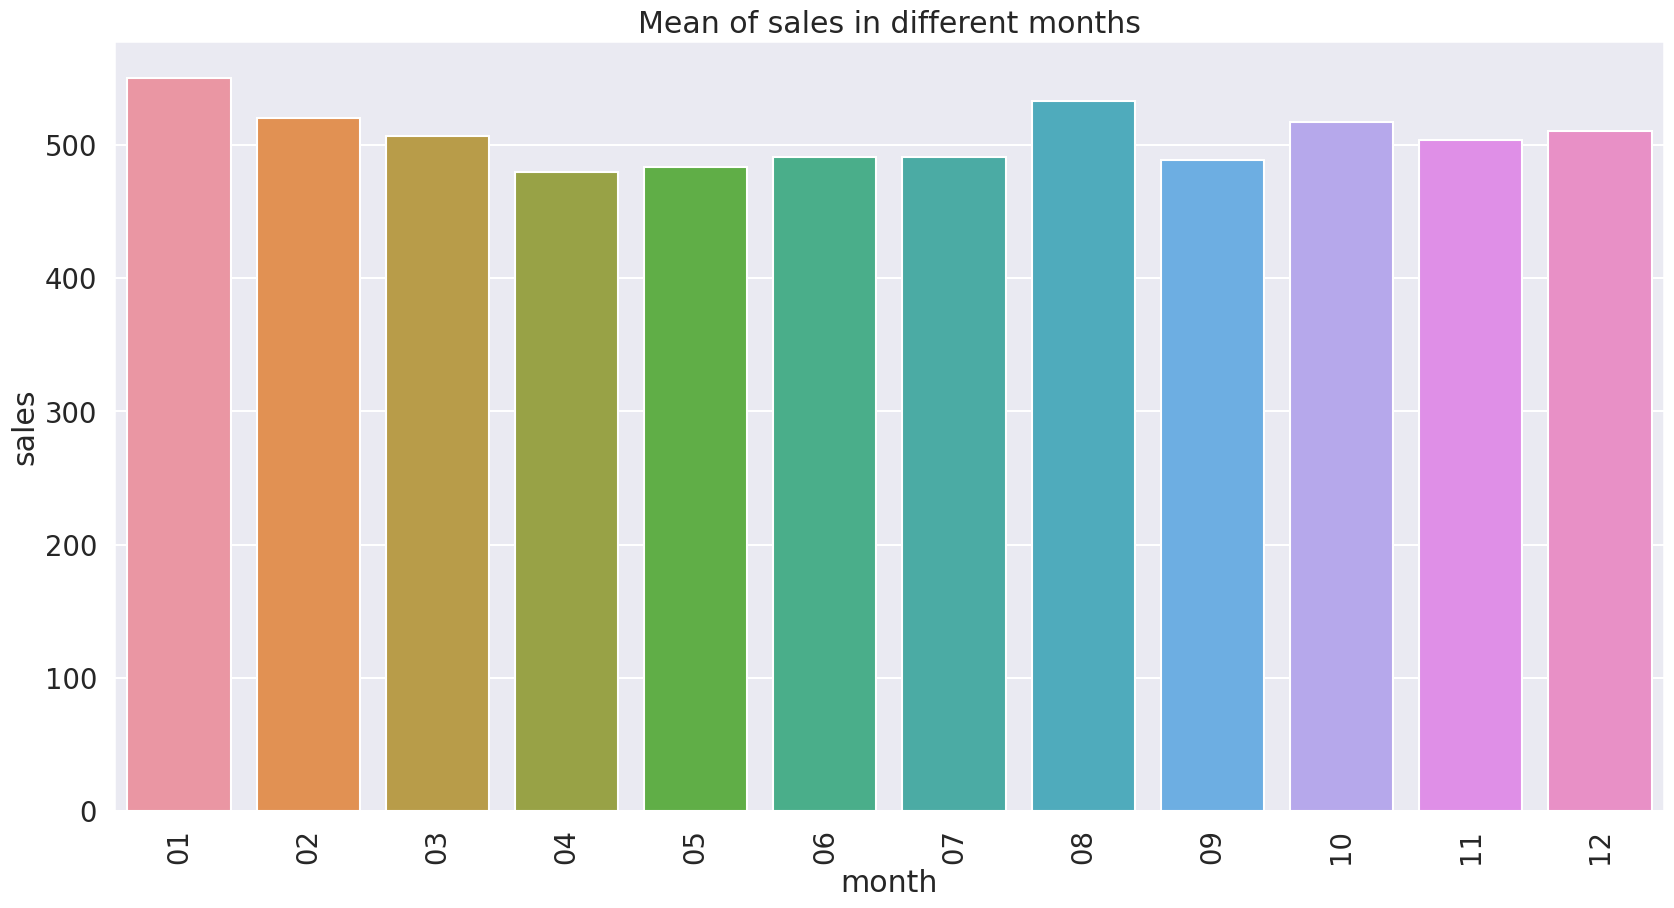

In [17]:
d = orders_df.groupby(['month']).agg({'sales': 'mean'}).reset_index()

plt.figure(figsize=(20, 10))
sns.set_context('talk', font_scale=1.2)
sns.barplot(d, x='month', y='sales').set_title('Mean of sales in different months')
plt.xticks(rotation=90)

## sales on different weekdays

(array([0, 1, 2, 3, 4, 5, 6]),
 [Text(0, 0, 'Monday'),
  Text(1, 0, 'Tuesday'),
  Text(2, 0, 'Wednesday'),
  Text(3, 0, 'Thursday'),
  Text(4, 0, 'Friday'),
  Text(5, 0, 'Saturday'),
  Text(6, 0, 'Sunday')])

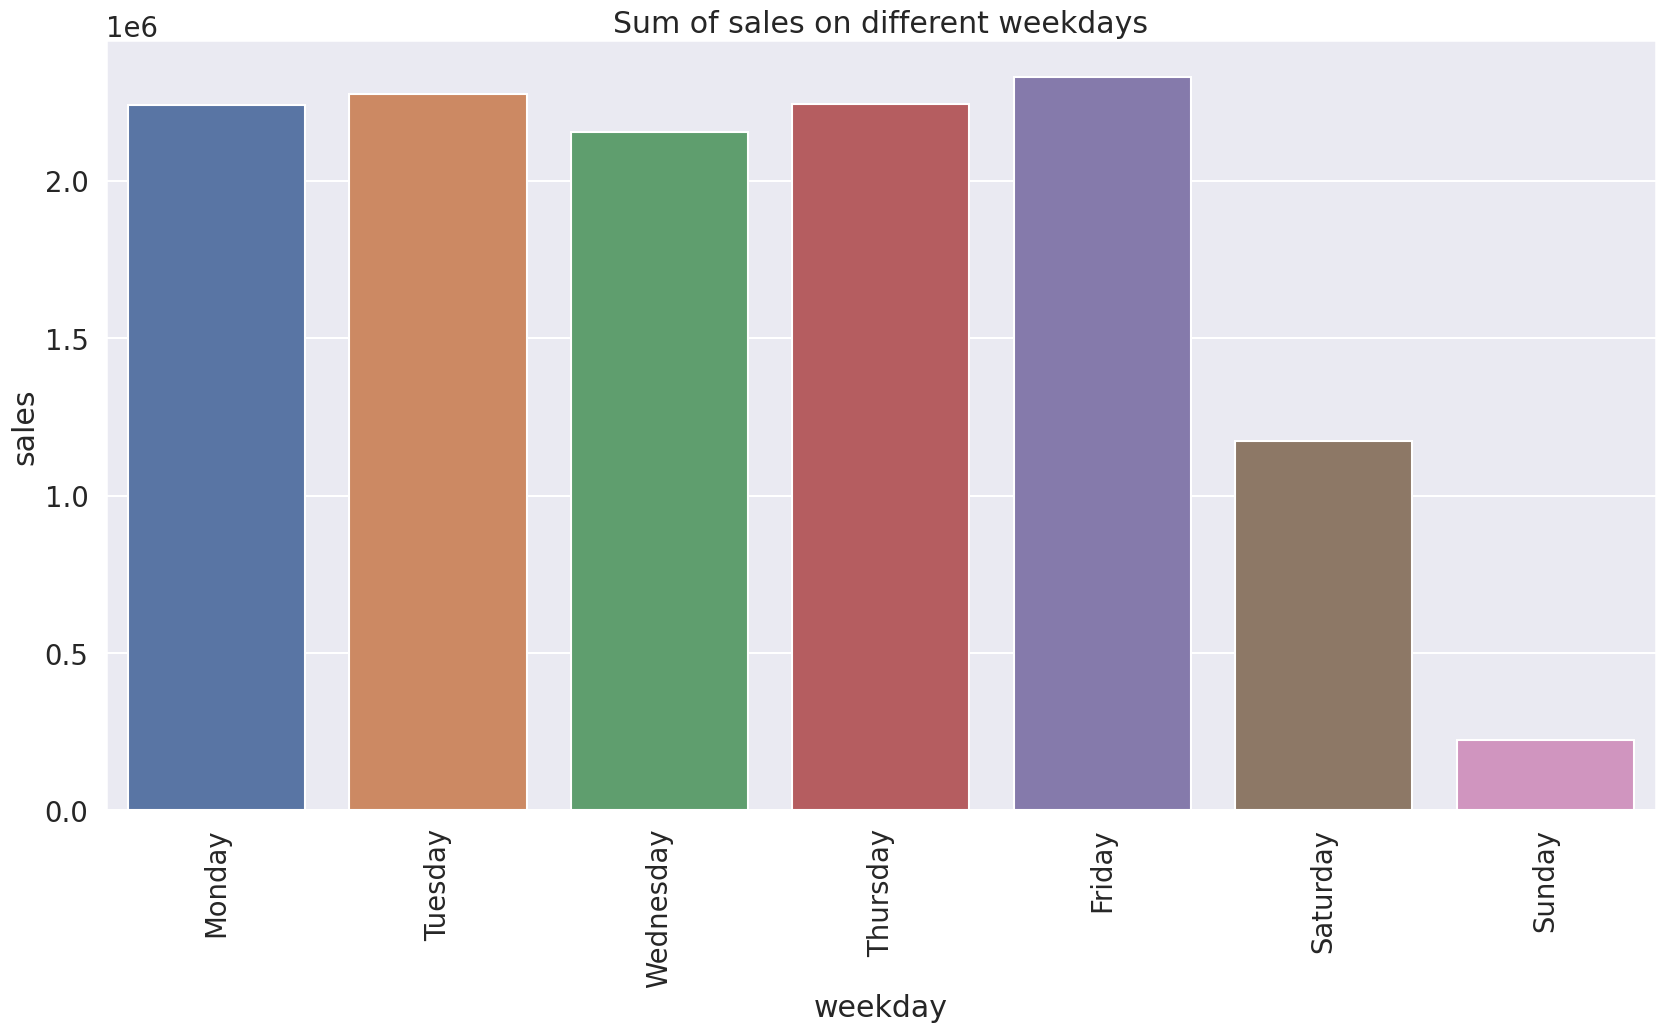

In [18]:
# create weekday column
orders_df['weekday'] = orders_df['order_date'].dt.strftime('%A')
d = orders_df.groupby(['weekday']).agg({'sales': 'sum'}).reset_index()
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
plt.figure(figsize=(20, 10))
sns.set_context('talk', font_scale=1.2)
sns.barplot(d, x='weekday', y='sales', order=weekday_order).set_title('Sum of sales on different weekdays')
plt.xticks(rotation=90)

[Text(0.5, 1.0, 'Sales on different weekdays in different markets'),
 Text(0.5, 0, 'Weekday'),
 Text(0, 0.5, 'Sales')]

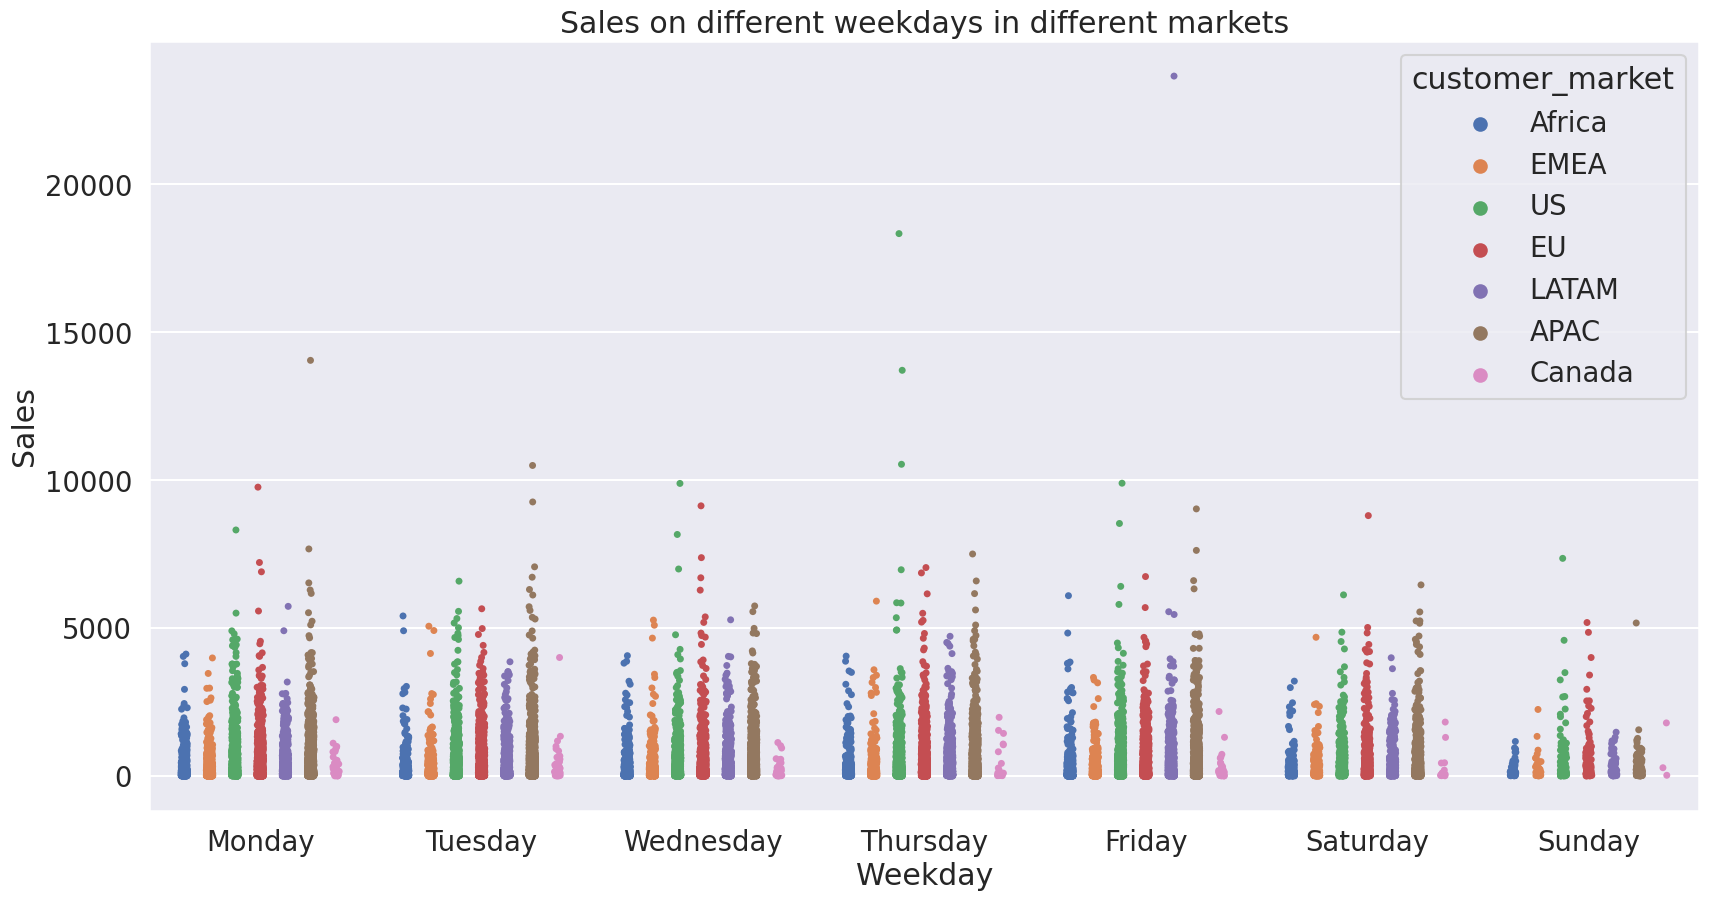

In [19]:
orders_df['weekday'] = orders_df['order_date'].dt.strftime('%A')
d = orders_df.groupby(['weekday', 'customer_market']).agg({'sales': 'sum'}).reset_index()
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

plt.figure(figsize=(20, 10))
sns.set_context('talk', font_scale=1.2)


sns.stripplot(
    x='weekday', y='sales', data=orders_df,
    hue='customer_market',
    jitter=True,
    dodge=True,
    order=weekday_order
    #palette=[w.colors['red'], w.colors['white']]
).set(title='Sales on different weekdays in different markets', xlabel='Weekday', ylabel='Sales')

## sales on different special dates

In general, e-commerce sales can experience increased activity during various periods throughout the year. While it's important to note that the specific dates and events that drive high e-commerce sales can vary based on factors such as region, industry, and consumer behavior, here are some key dates and periods that are commonly associated with heightened online shopping activity:

1. Black Friday and Cyber Monday: These are typically observed on the Friday following Thanksgiving and the Monday immediately after. They mark the beginning of the holiday shopping season in many countries, including the United States, and are known for substantial discounts and promotions.

2. Christmas and Holiday Season: The period leading up to Christmas and the end-of-year holidays is characterized by increased e-commerce sales as people purchase gifts, decorations, and other holiday-related items.

3. New Year's Sales: Shortly after the holiday season, many retailers offer sales and discounts to attract customers who may be looking for deals as they start the new year.

4. Valentine's Day: Celebrated on February 14th, Valentine's Day prompts a surge in online sales of gifts, flowers, chocolates, and other romantic items.

5. Back-to-School Season: In the months of July, August, and September (varies by region), e-commerce sales tend to rise as parents and students shop for school supplies, clothing, electronics, and other related items.

6. Prime Day: Amazon's annual shopping event, usually held in July, has gained significant popularity and often leads to increased online sales not only on Amazon but also on other e-commerce platforms that offer competing deals during this time.

7. Seasonal Sales: Retailers often hold seasonal sales during transitional periods, such as spring and summer clearances or fall and winter sales, to make way for new inventory. These sales can generate heightened e-commerce activity.

It's worth noting that the popularity of certain events and shopping periods can evolve over time, and new shopping events may emerge as e-commerce continues to grow. Additionally, factors such as the COVID-19 pandemic and changing consumer behavior can also influence online shopping patterns. Therefore, staying updated with current trends and market insights is essential for e-commerce businesses.

Black friday days:
2011-11-25
2012-11-23
2013-11-29
2014-11-28

In [20]:
def plot_stat_on_day(stat, days, agg, highlight_color):
    for day in days:

        # select 30 day range with selected day in the middle
        sel_day = pd.to_datetime(day)
        date_range = pd.date_range(
            sel_day - pd.Timedelta(days=15),
            sel_day + pd.Timedelta(days=15)
        )
        # select only orders in the range
        black_friday_df = orders_df[
            orders_df['order_date'].isin(date_range)
        ]
        # create a column only with month and day
        black_friday_df['order_day'] = black_friday_df['order_date'].dt.strftime('%m-%d')
        # sum sales for each day
        black_friday_df = black_friday_df.groupby(['order_day']).agg({stat: agg}).reset_index()

        # make lineplot
        plt.figure(figsize=(20, 10))
        sns.set_context('talk', font_scale=1.2)
        sns.barplot(
            data=black_friday_df,
            x='order_day',
            y=stat,
            palette=['gray'] * 15 + [highlight_color] + ['gray'] * 15
        ).set_title(agg + ' ' + stat + ' on ' + day)
        plt.xticks(rotation=90)

/tmp/ipykernel_3286/528693454.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  black_friday_df['order_day'] = black_friday_df['order_date'].dt.strftime('%m-%d')
/tmp/ipykernel_3286/528693454.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  black_friday_df['order_day'] = black_friday_df['order_date'].dt.strftime('%m-%d')
/tmp/ipykernel_3286/528693454.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inste

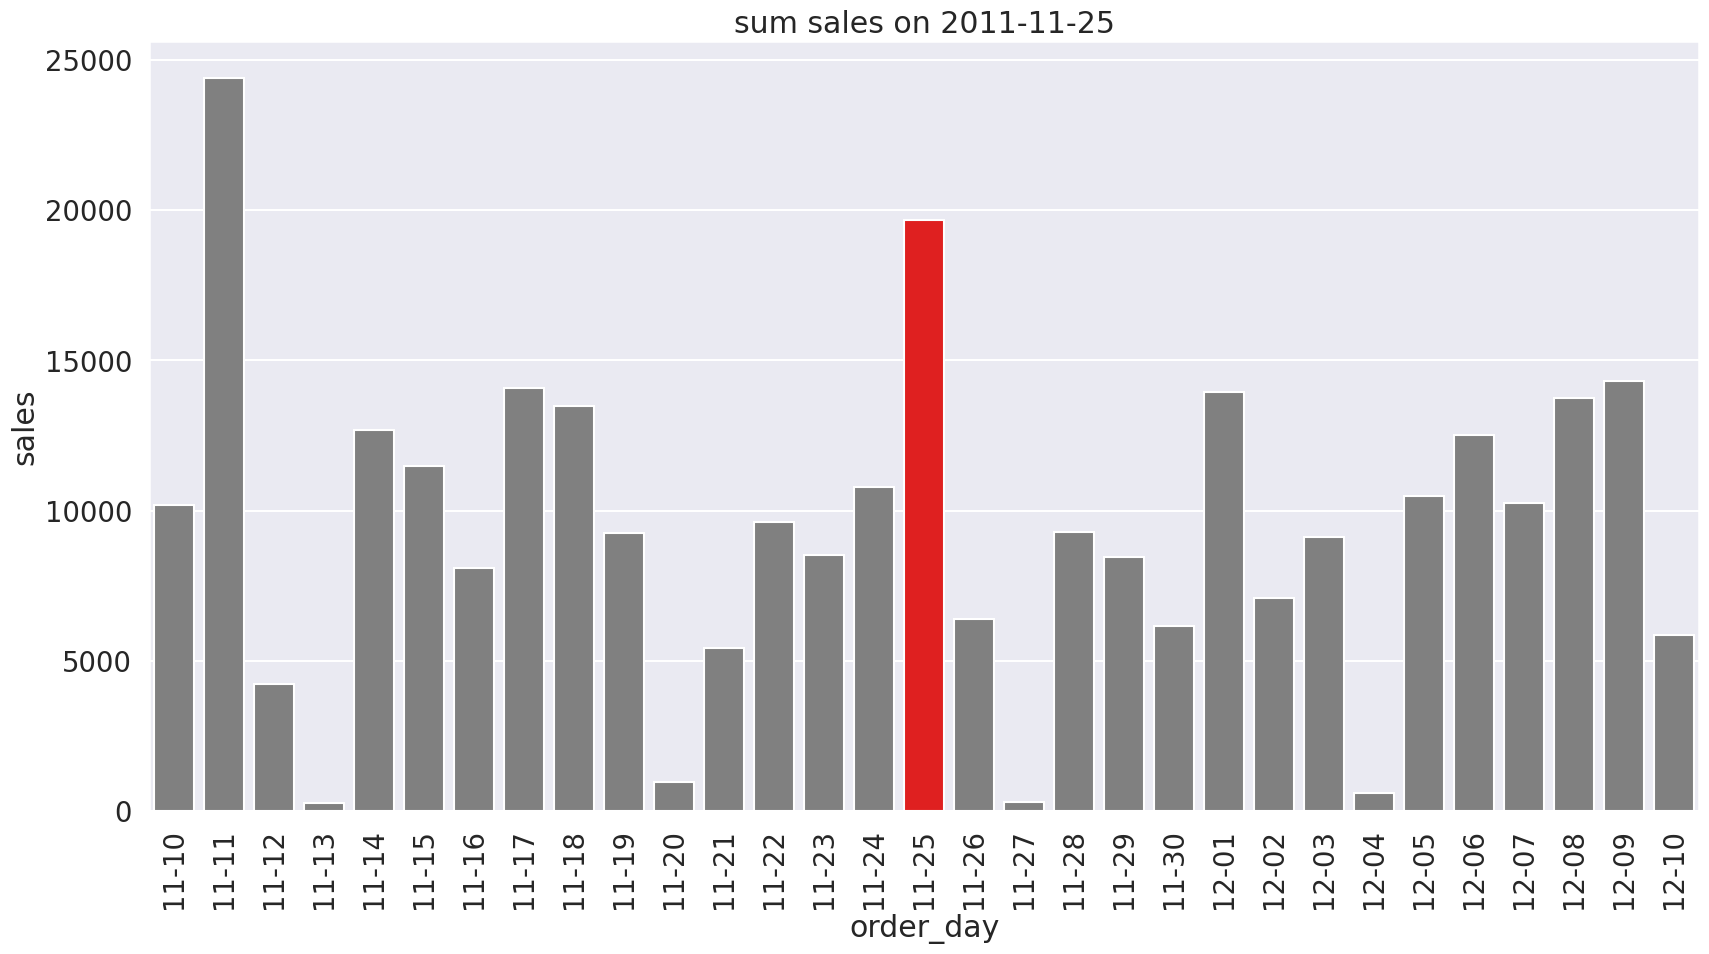

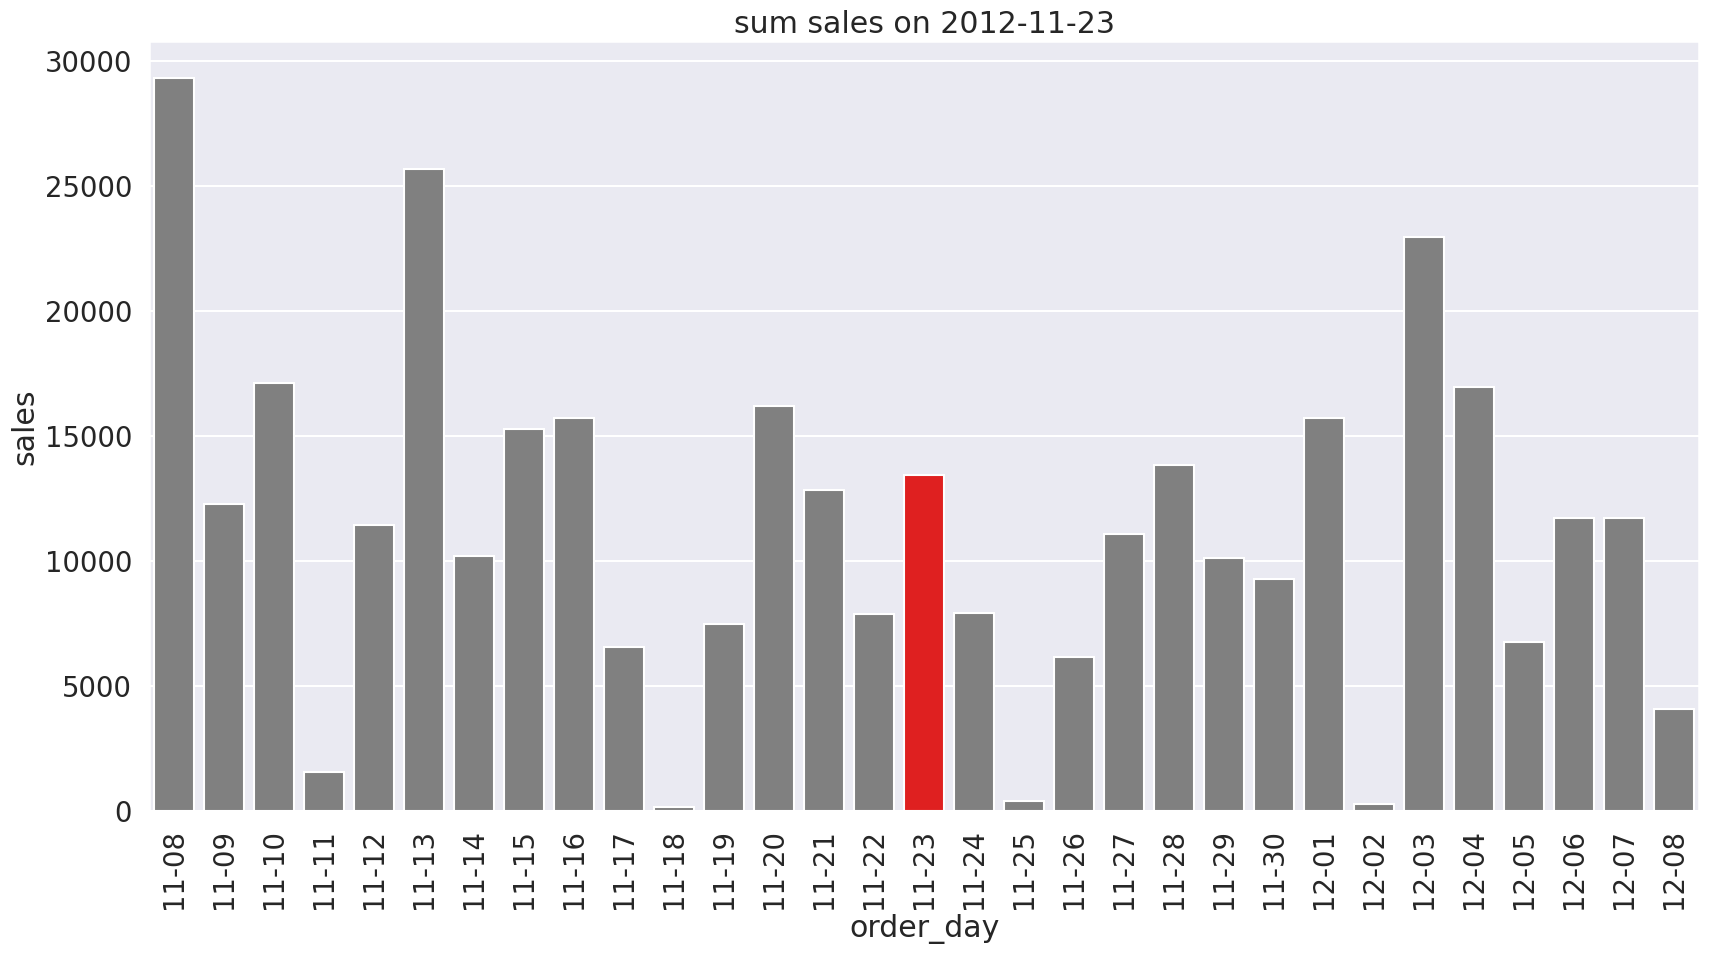

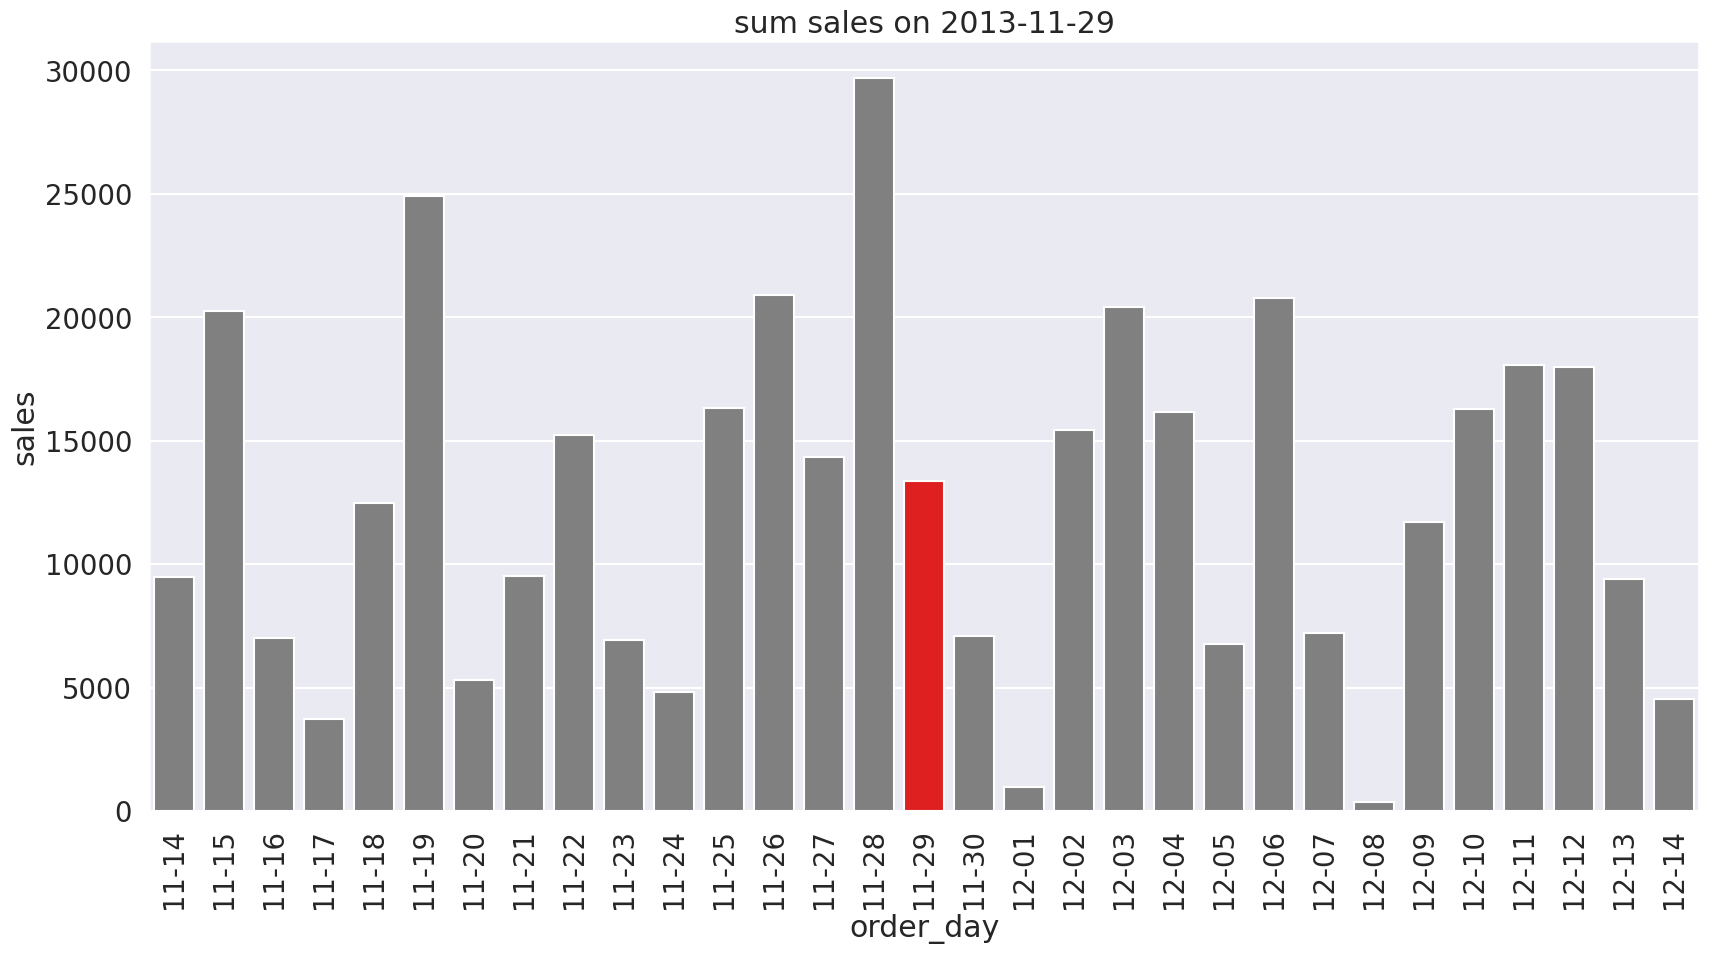

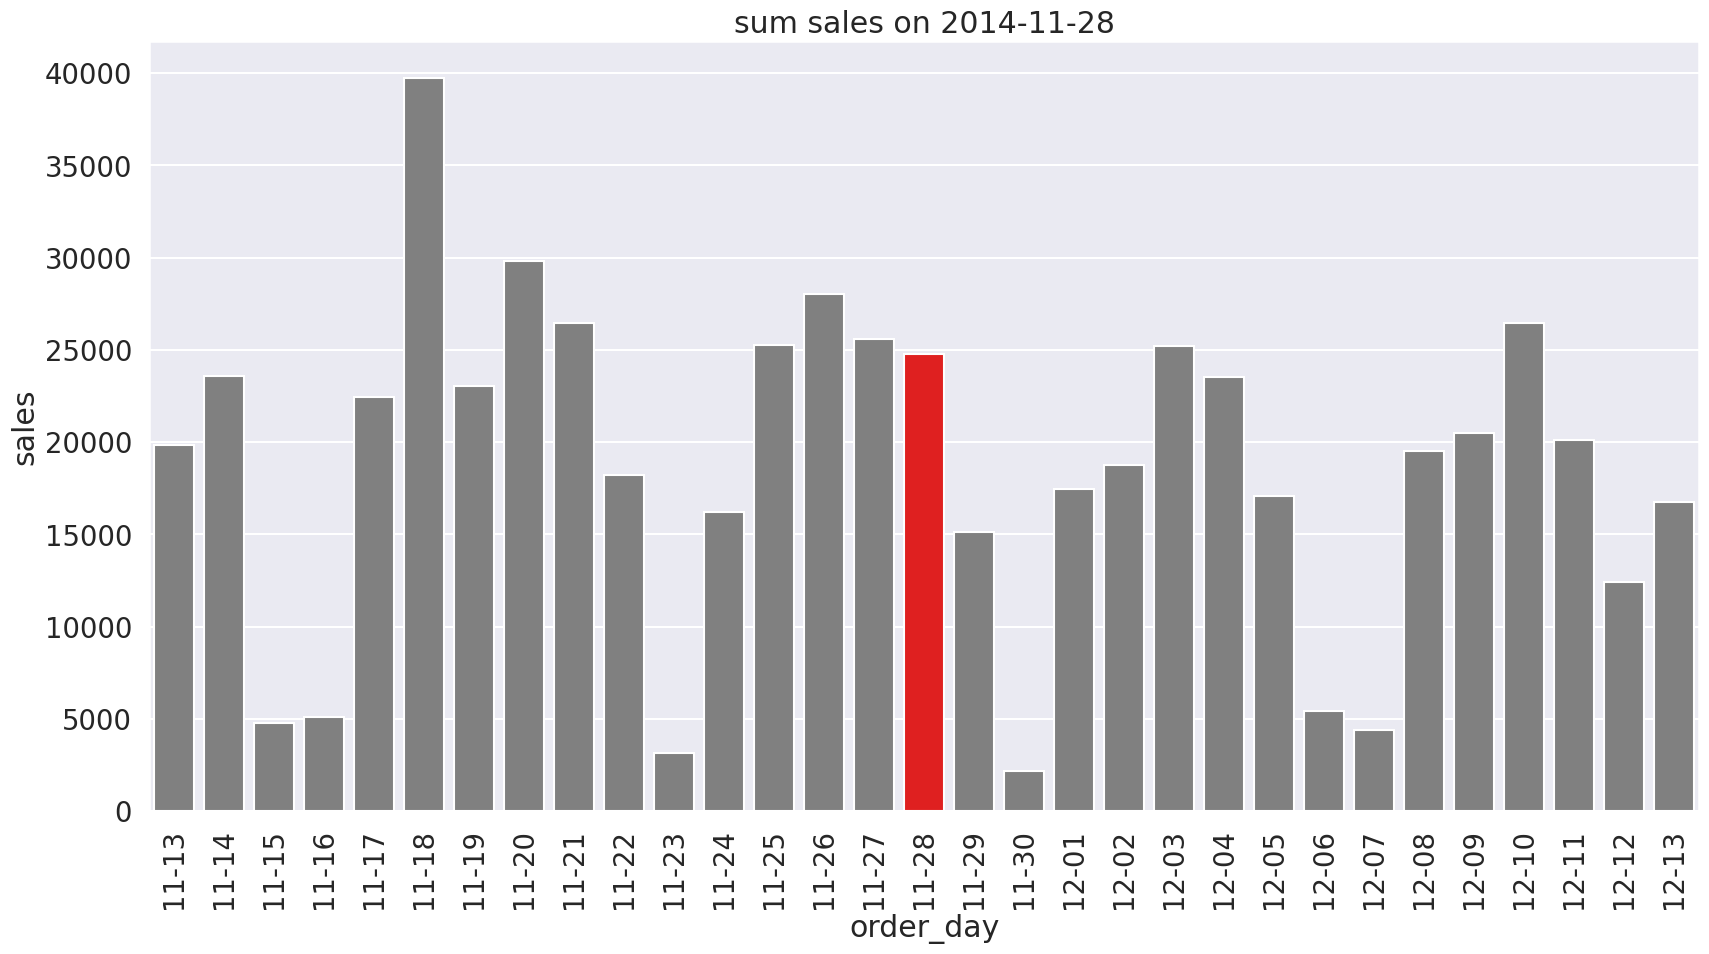

In [21]:
black_friday_days = [
    '2011-11-25',
    '2012-11-23',
    '2013-11-29',
    '2014-11-28'
]

plot_stat_on_day('sales', black_friday_days, 'sum', 'red')

/tmp/ipykernel_3286/528693454.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  black_friday_df['order_day'] = black_friday_df['order_date'].dt.strftime('%m-%d')
/tmp/ipykernel_3286/528693454.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  black_friday_df['order_day'] = black_friday_df['order_date'].dt.strftime('%m-%d')
/tmp/ipykernel_3286/528693454.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inste

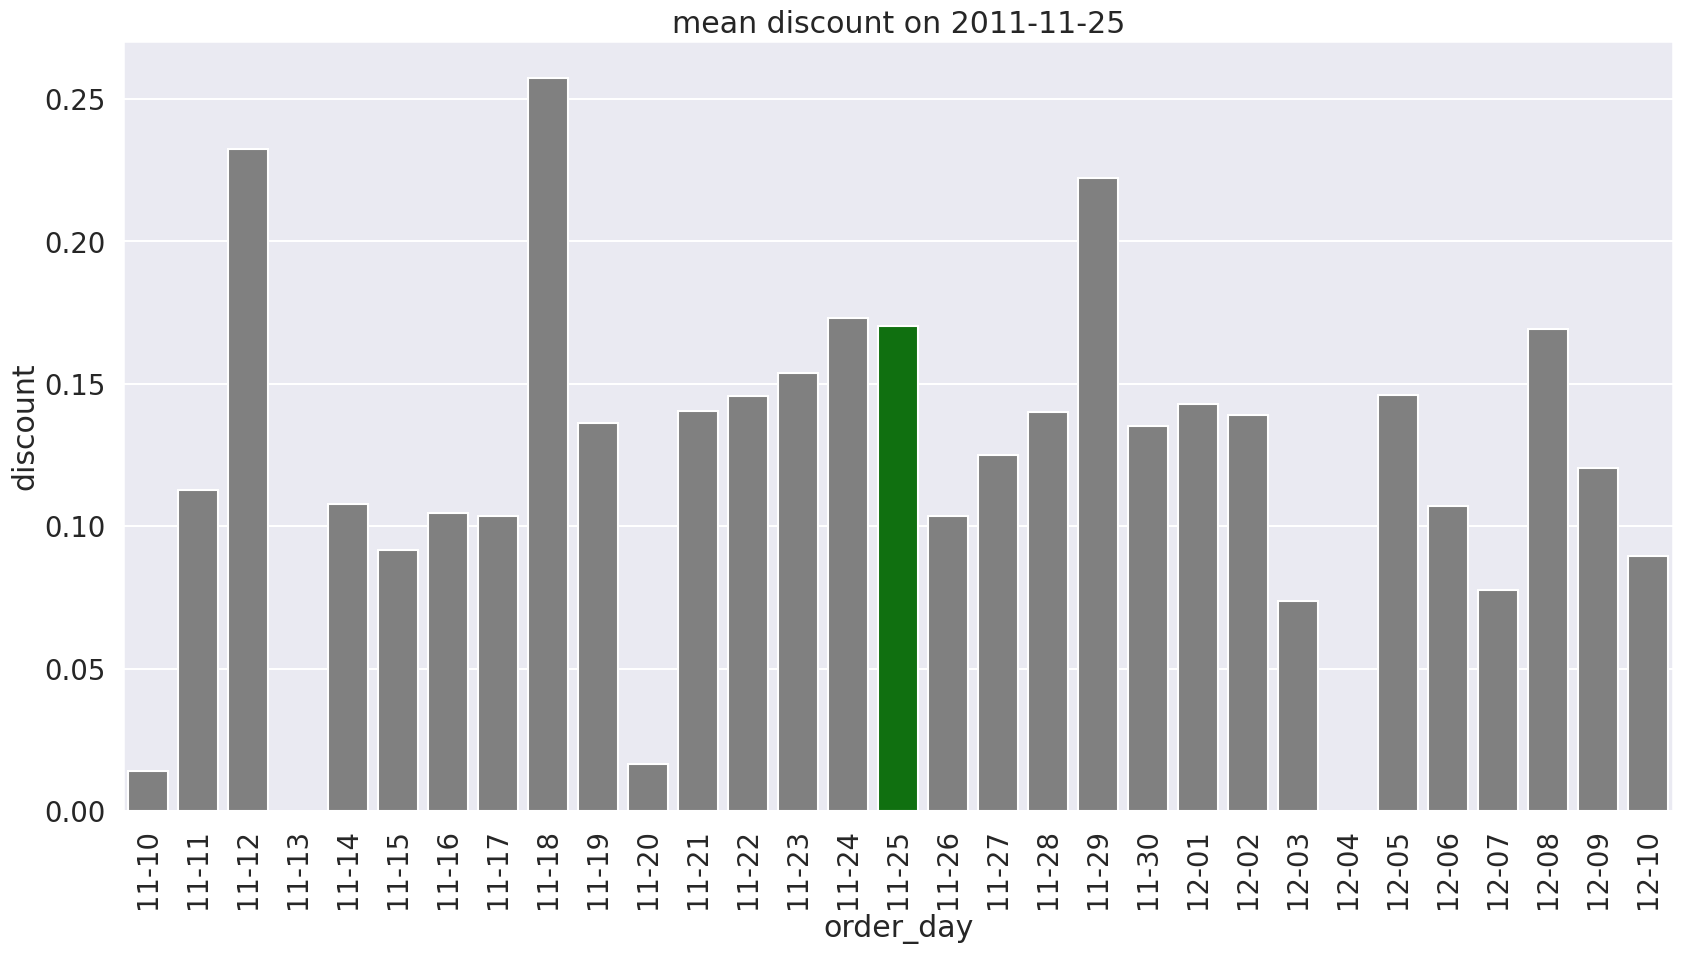

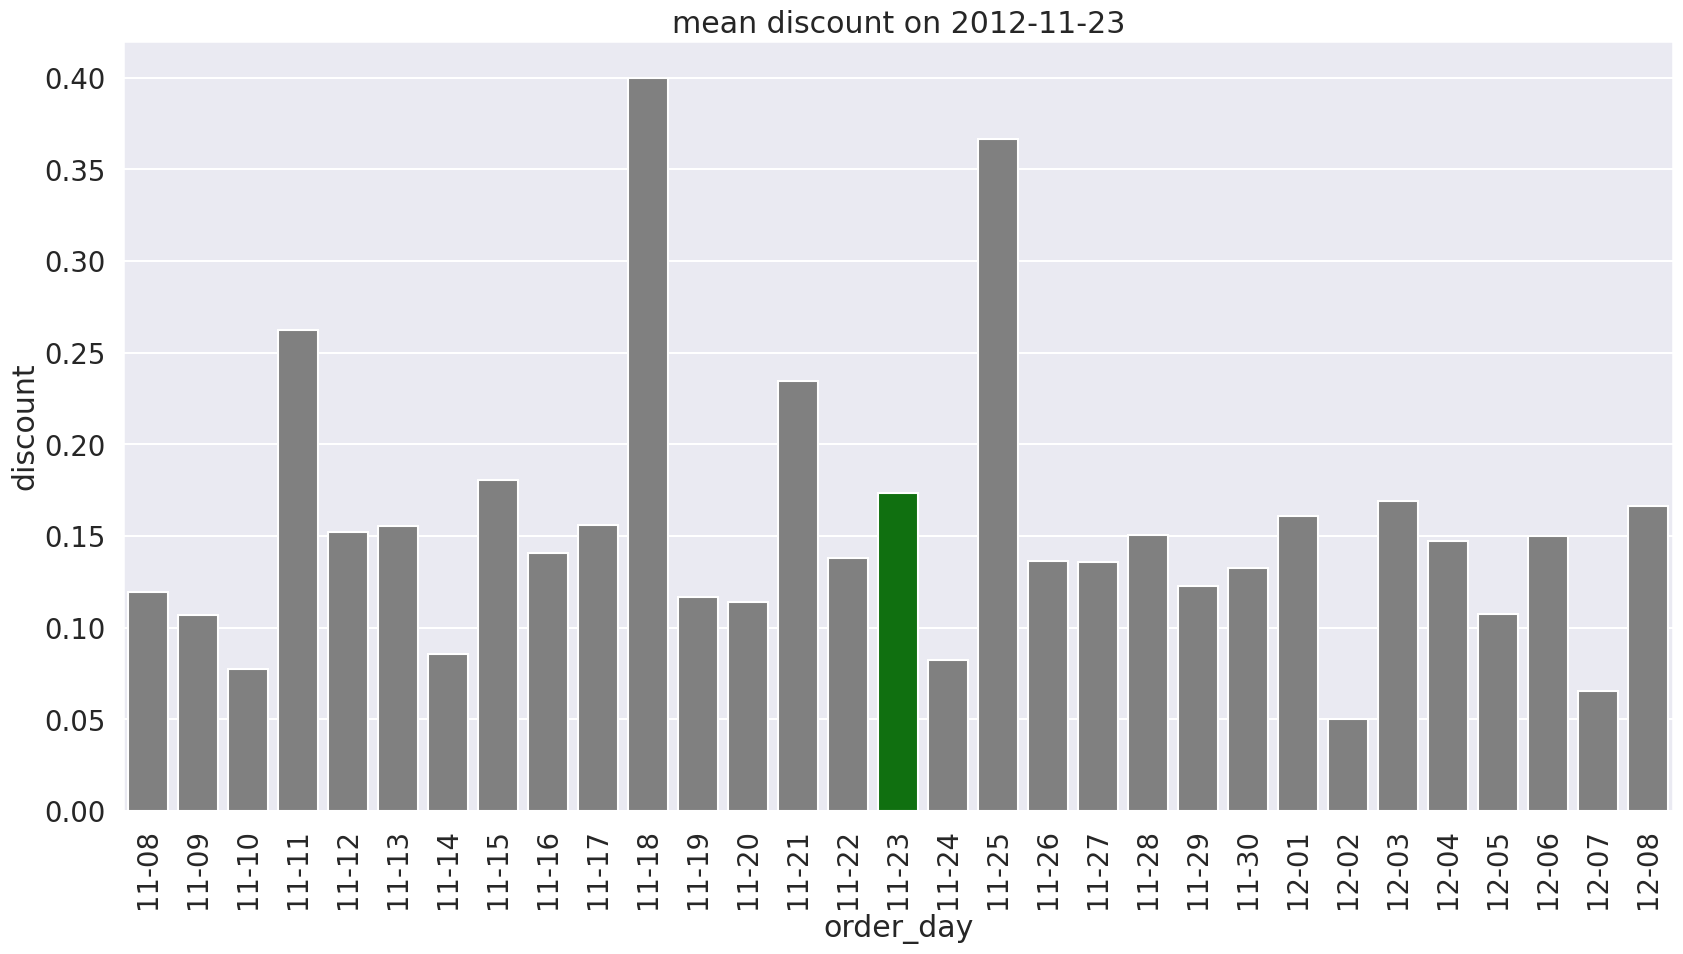

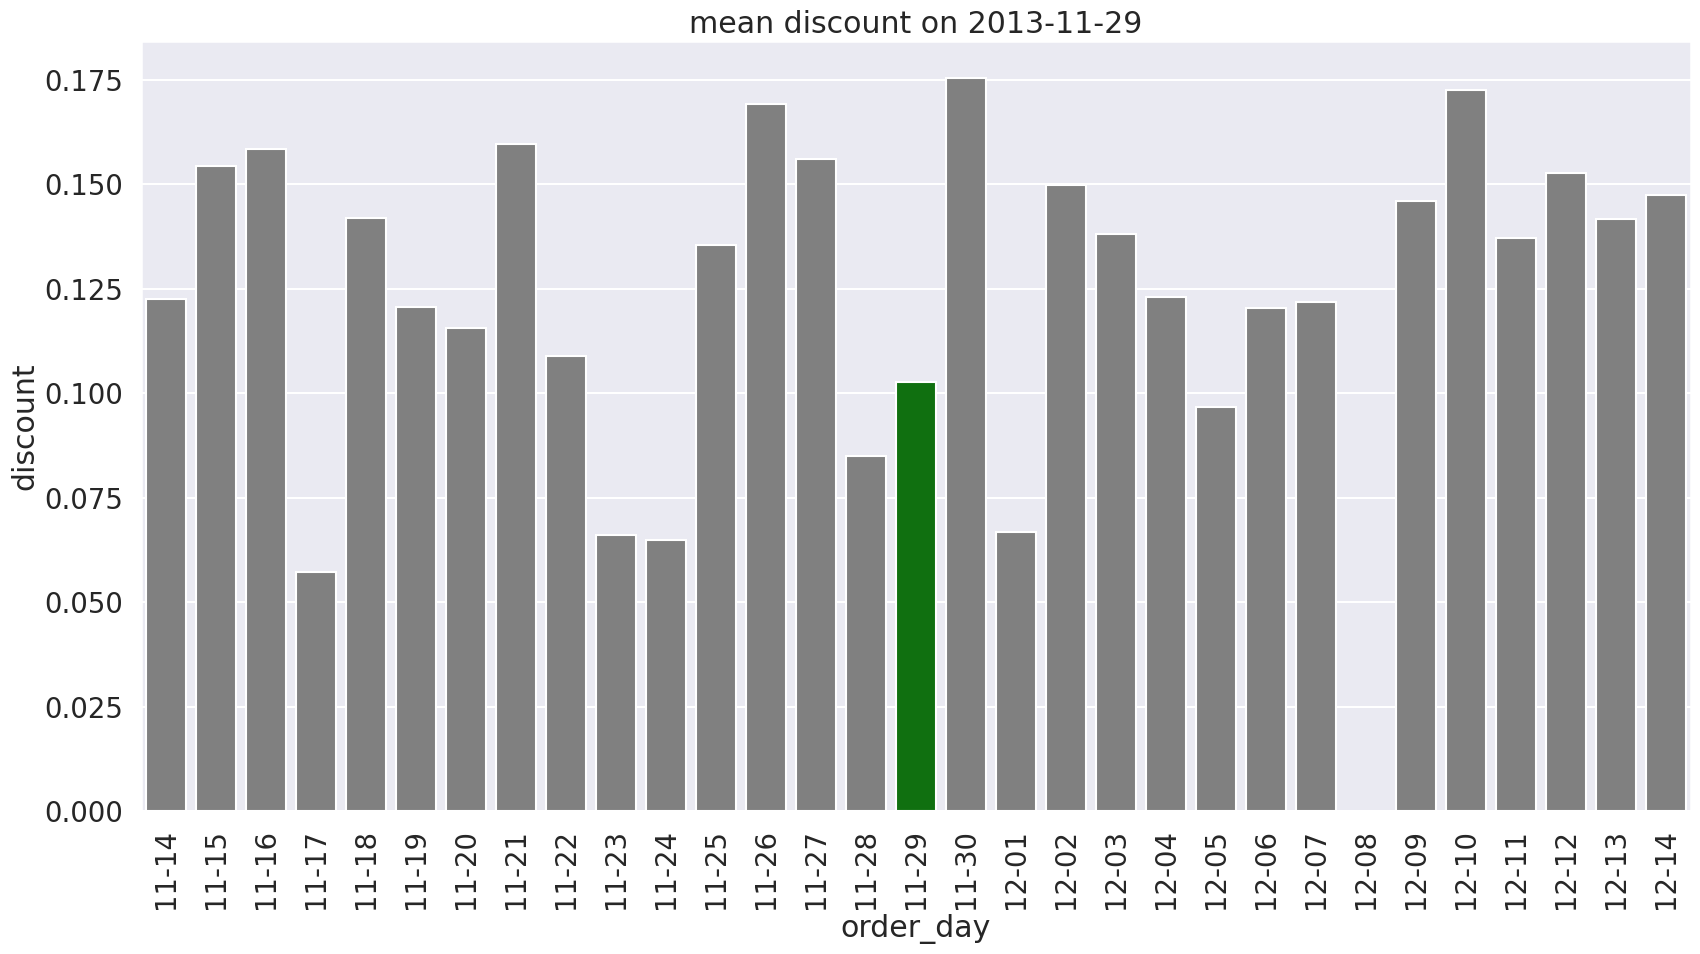

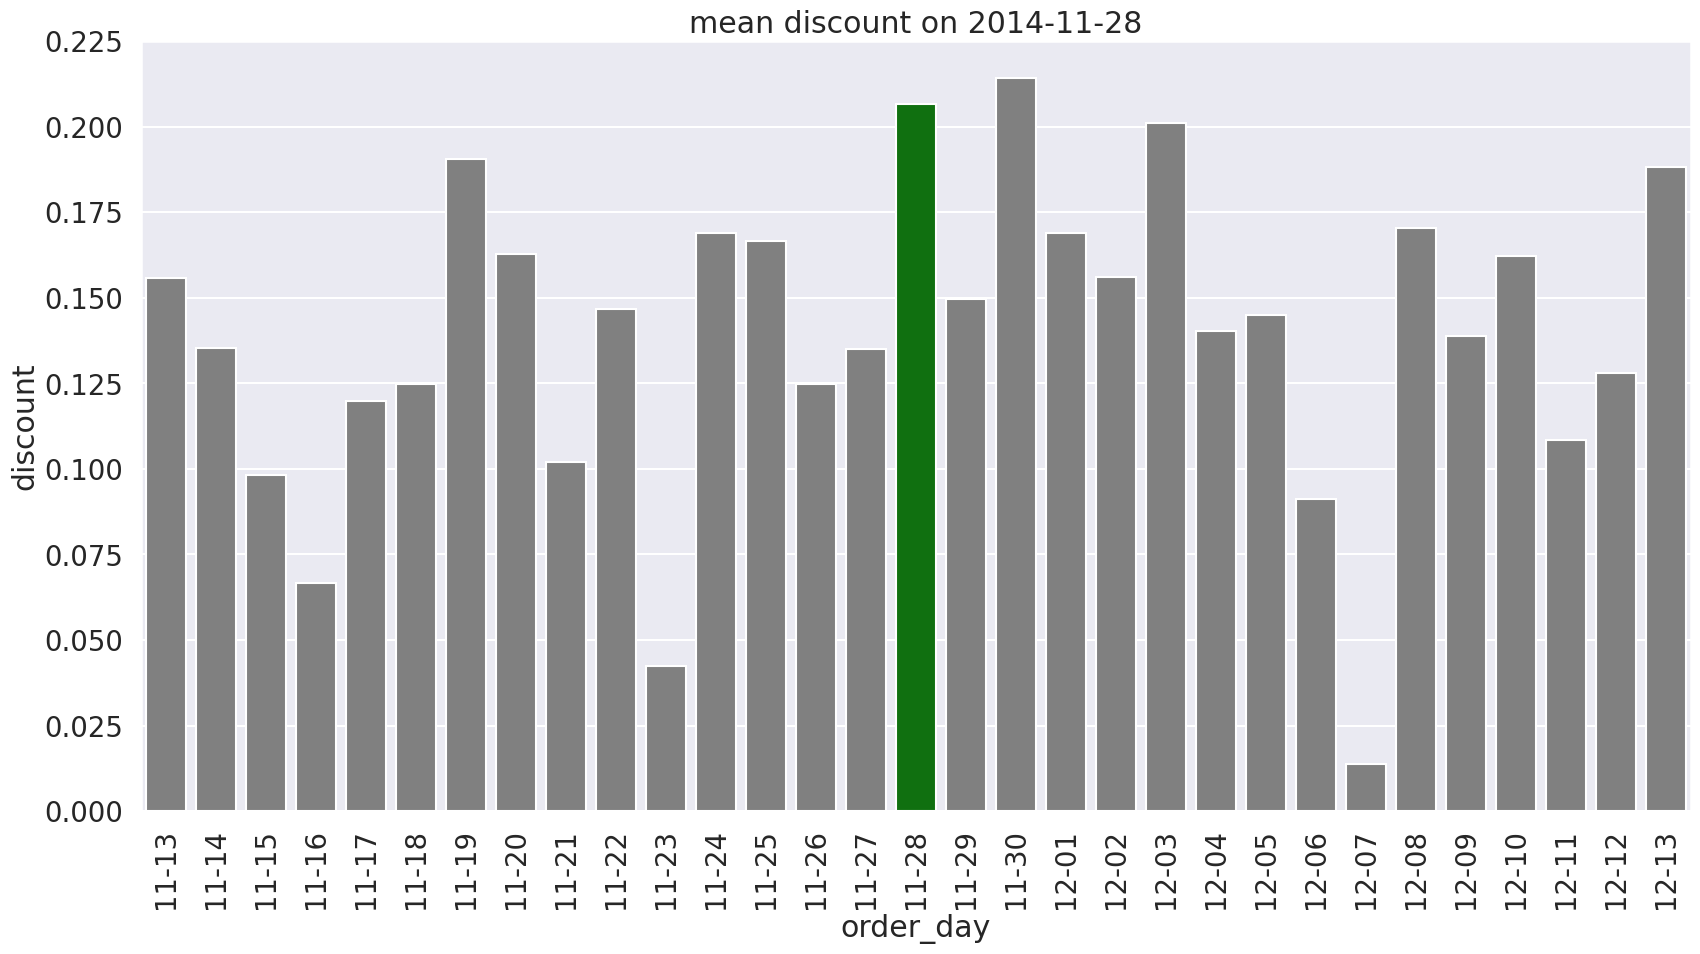

In [22]:
plot_stat_on_day('discount', black_friday_days, 'mean', 'green')

/tmp/ipykernel_3286/528693454.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  black_friday_df['order_day'] = black_friday_df['order_date'].dt.strftime('%m-%d')
/tmp/ipykernel_3286/528693454.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  black_friday_df['order_day'] = black_friday_df['order_date'].dt.strftime('%m-%d')
/tmp/ipykernel_3286/528693454.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inste

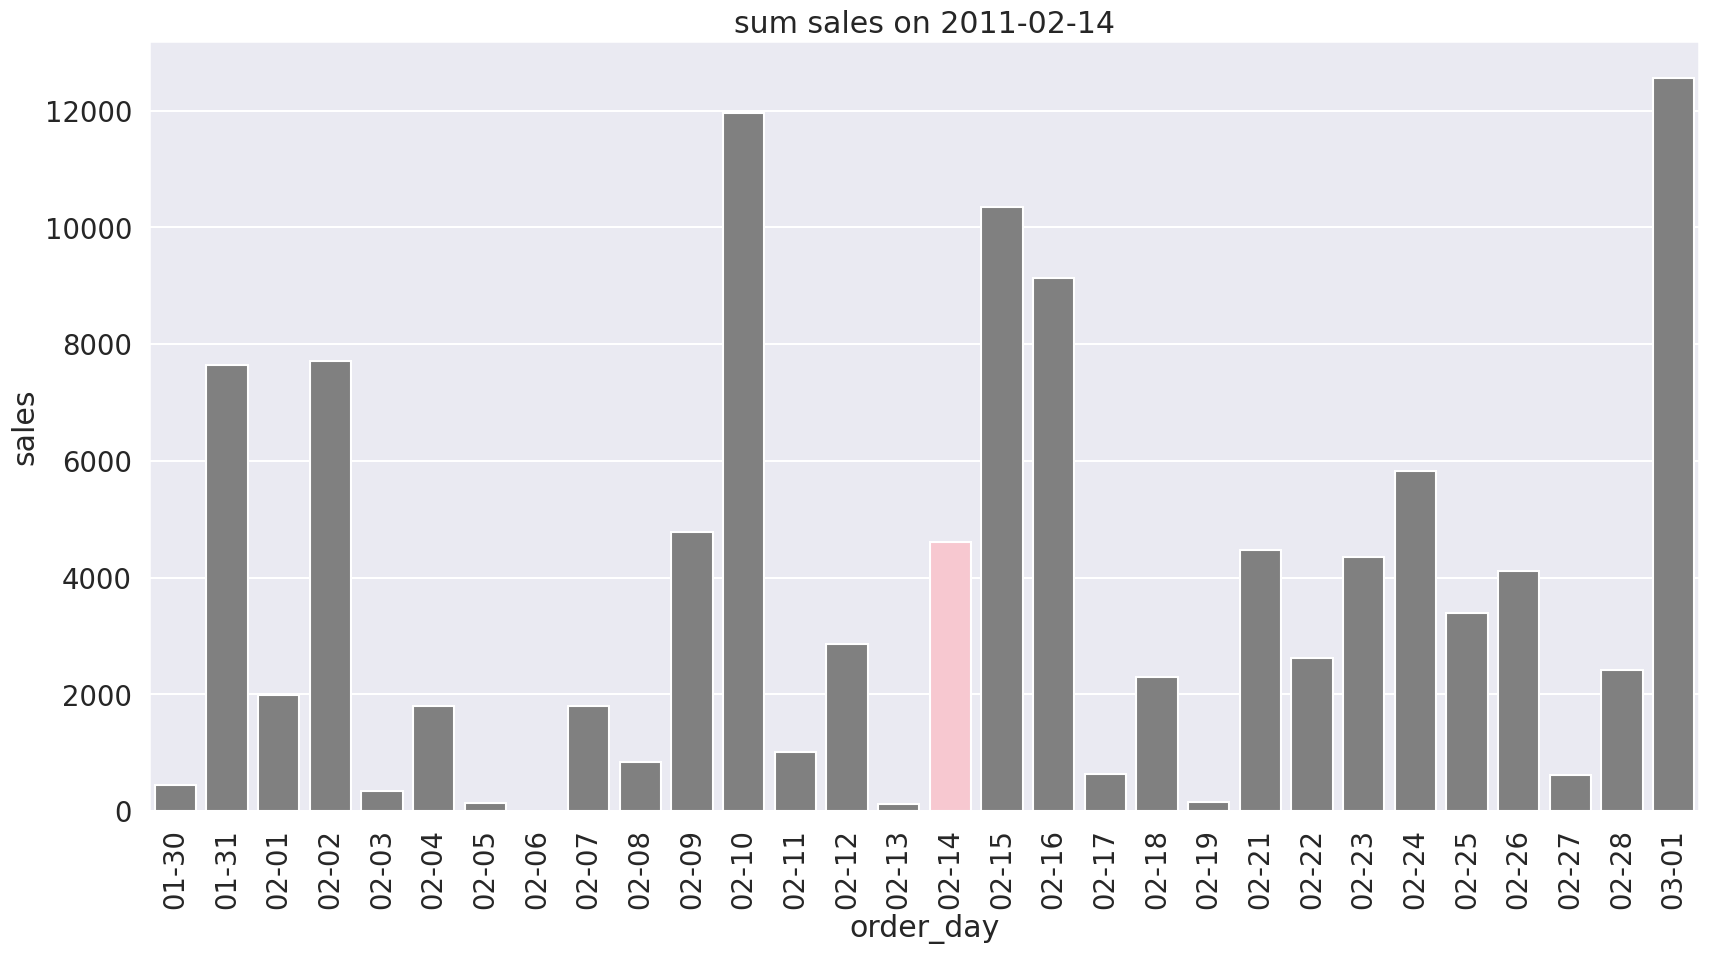

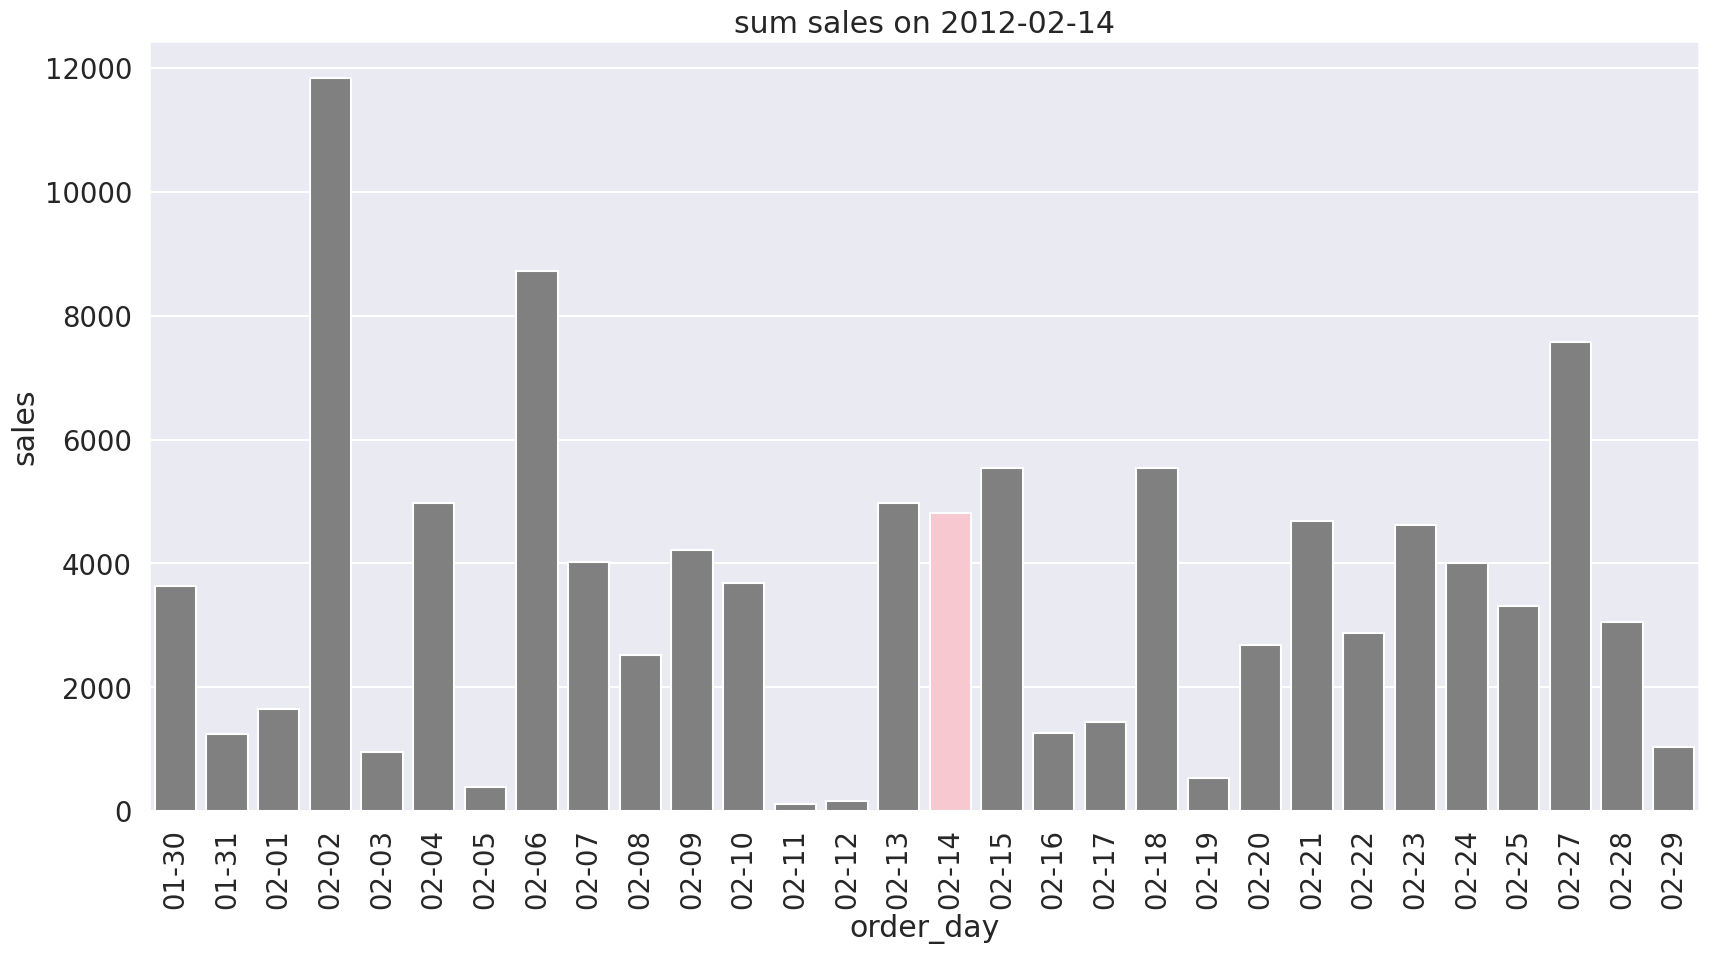

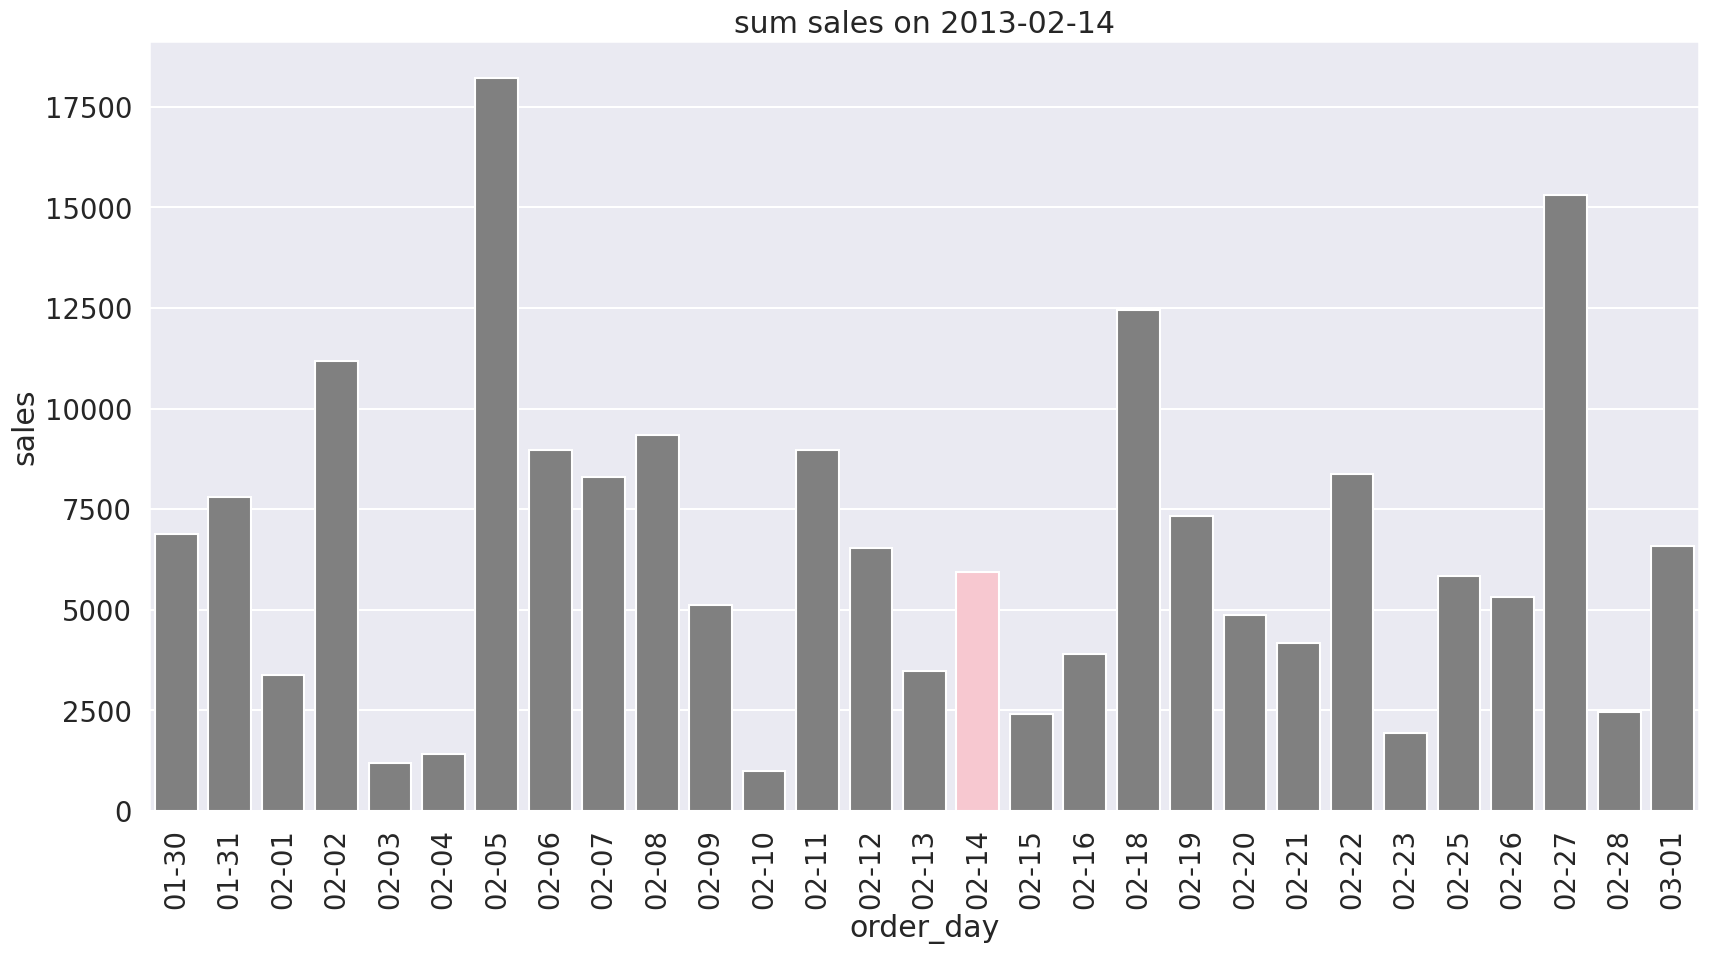

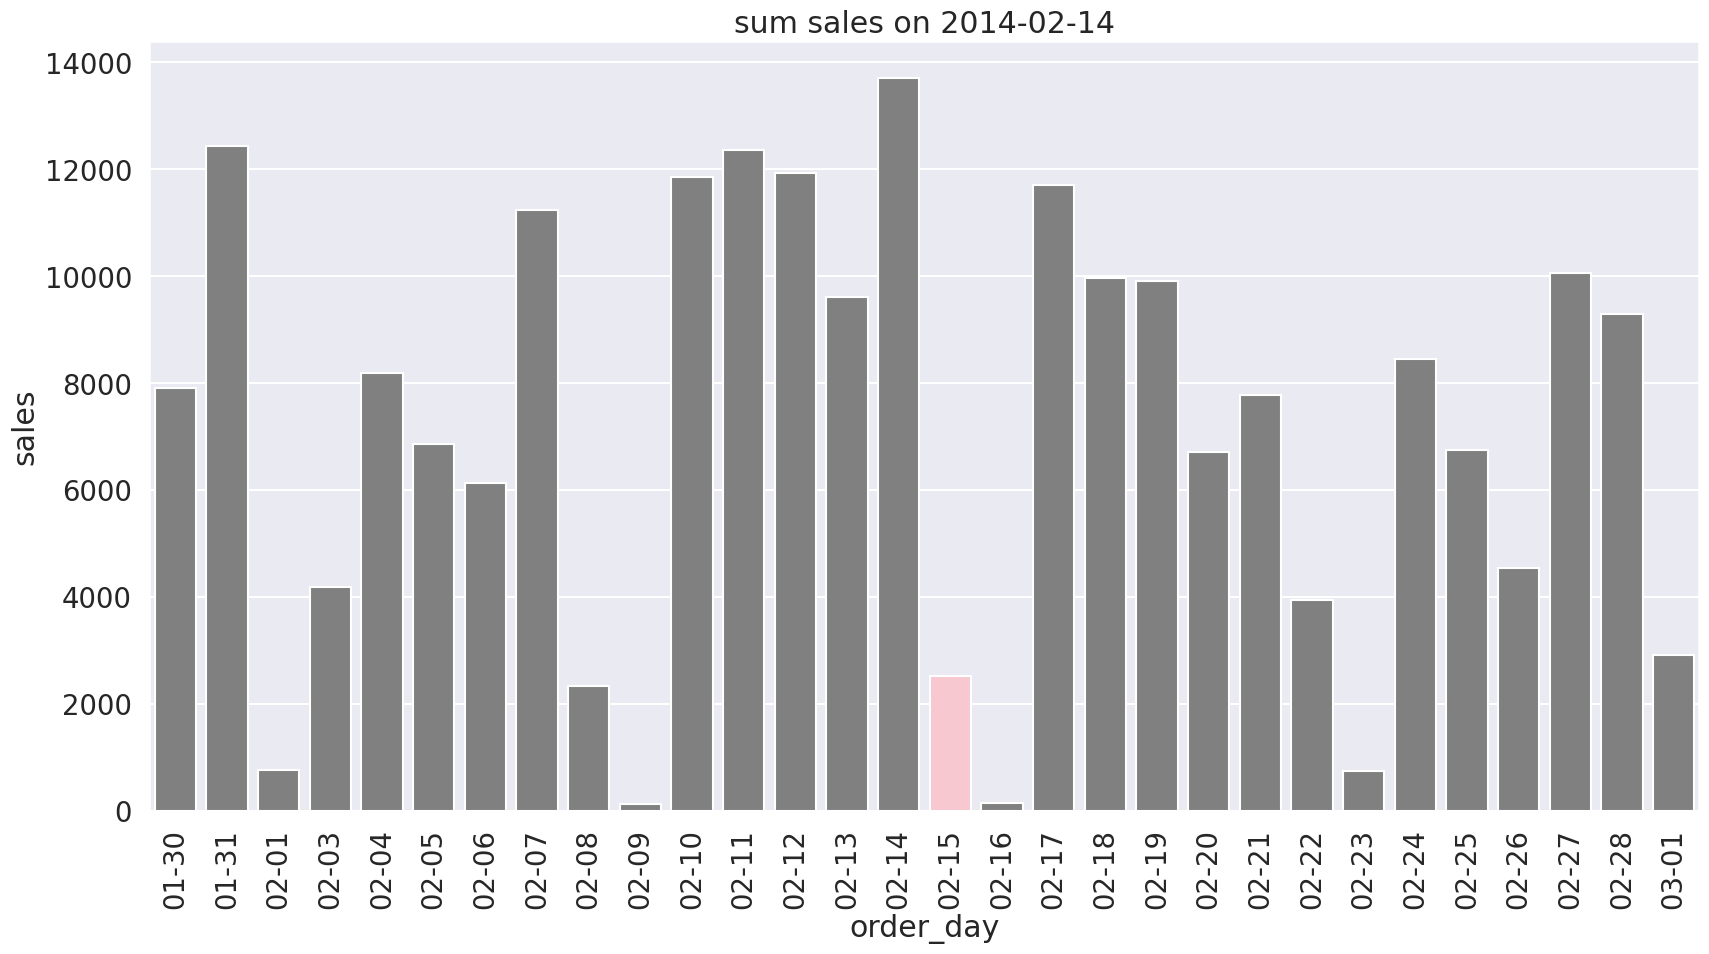

In [23]:
# st. valintine days
valentine_days = [
    '2011-02-14',
    '2012-02-14',
    '2013-02-14',
    '2014-02-14'
]
plot_stat_on_day('sales', valentine_days, 'sum', 'pink')

In [24]:
# select products with the highest sales from 2014-02-10 to 2014-02-14
sql = """
SELECT
    products.name,
    SUM(order_products.sales) AS sales
FROM
    products
    LEFT JOIN order_products ON order_products.product_id = products.id
    LEFT join orders ON orders.id = order_products.order_id
WHERE
    orders.order_date BETWEEN '2014-02-10' AND '2014-02-14'
GROUP BY products.name
ORDER BY sales DESC
LIMIT 10
"""
q(sql, cur)


name     sales
0                        KitchenAid Stove, Silver  3425.400
1      Hon Executive Leather Armchair, Adjustable  2757.780
2                   Cuisinart Refrigerator, Black  2477.550
3                       Enermax Router, Erganomic  2074.734
4                       Sharp Wireless Fax, Color  1822.536
5  Novimex Executive Leather Armchair, Adjustable  1726.650
6                     Apple Smart Phone, Cordless  1584.387
7                  Safco Library with Doors, Pine  1564.560
8                  Sauder Corner Shelving, Mobile  1198.560
9                    Safco Classic Bookcase, Pine  1186.650

In [25]:
## Discounts

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26]),
 [Text(0, 0, '0.0'),
  Text(1, 0, '0.002'),
  Text(2, 0, '0.07'),
  Text(3, 0, '0.1'),
  Text(4, 0, '0.15'),
  Text(5, 0, '0.17'),
  Text(6, 0, '0.2'),
  Text(7, 0, '0.202'),
  Text(8, 0, '0.25'),
  Text(9, 0, '0.27'),
  Text(10, 0, '0.3'),
  Text(11, 0, '0.32'),
  Text(12, 0, '0.35'),
  Text(13, 0, '0.37'),
  Text(14, 0, '0.4'),
  Text(15, 0, '0.402'),
  Text(16, 0, '0.45'),
  Text(17, 0, '0.47'),
  Text(18, 0, '0.5'),
  Text(19, 0, '0.55'),
  Text(20, 0, '0.57'),
  Text(21, 0, '0.6'),
  Text(22, 0, '0.602'),
  Text(23, 0, '0.65'),
  Text(24, 0, '0.7'),
  Text(25, 0, '0.8'),
  Text(26, 0, '0.85')])

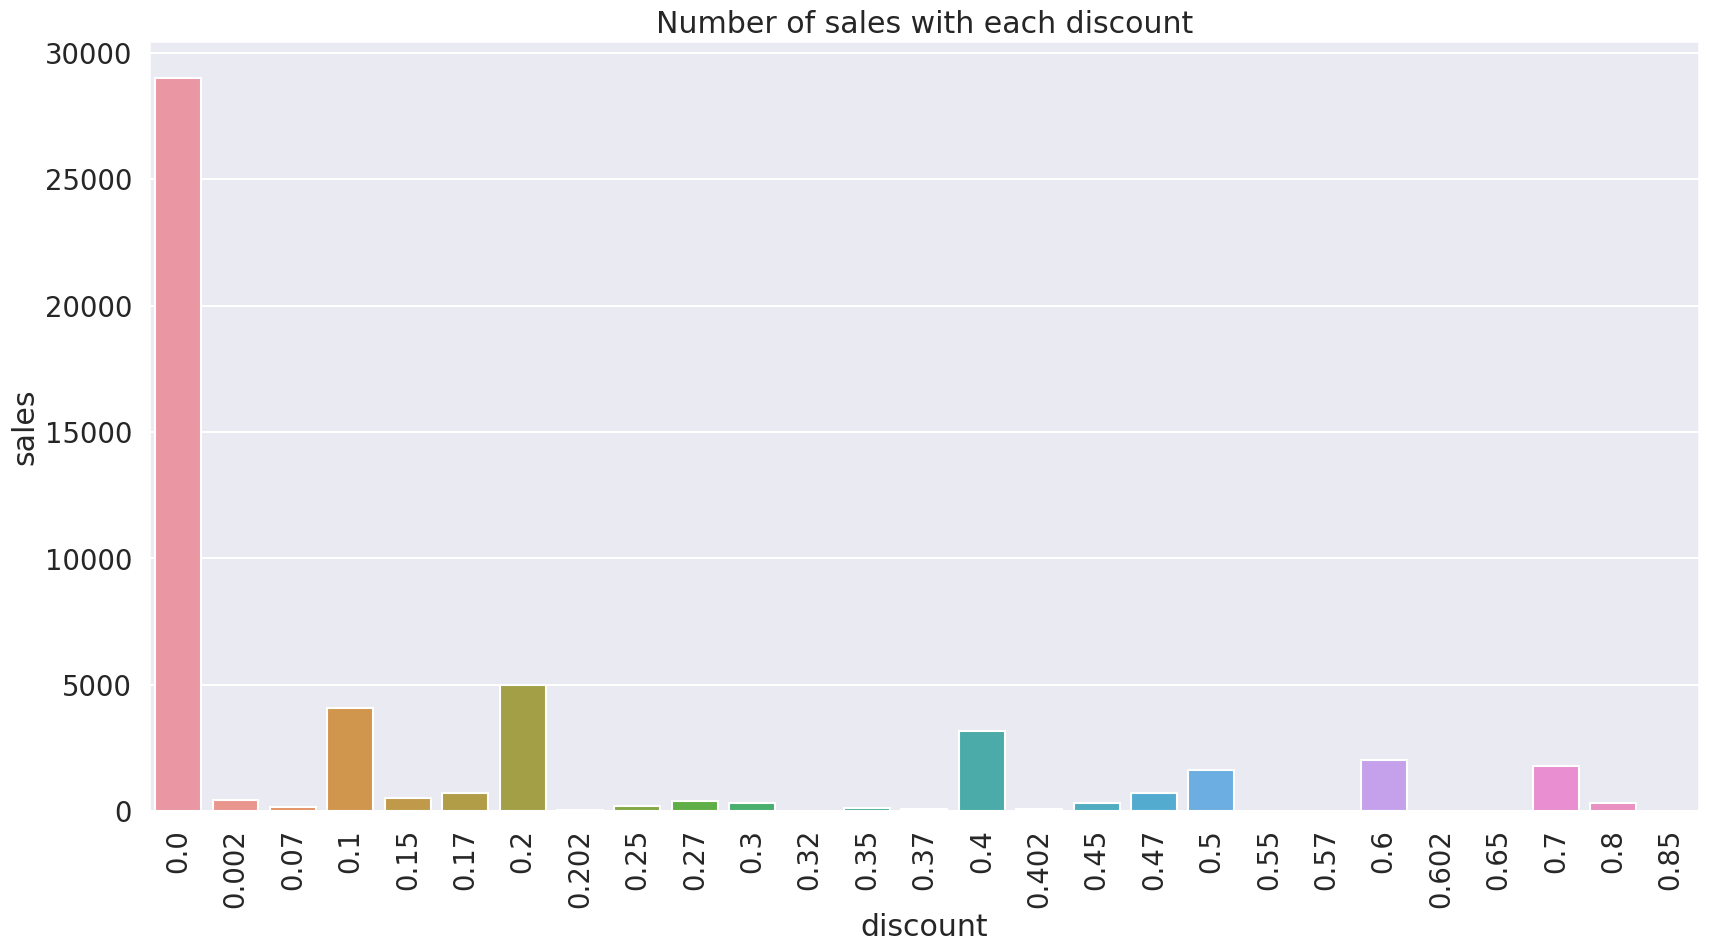

In [26]:
# calculate number of sales for each discount
d = sales_df.groupby(['discount']).agg({'sales': 'count'}).reset_index()

plt.figure(figsize=(20, 10))
sns.set_context('talk', font_scale=1.2)
sns.barplot(d, y='sales', x='discount').set_title('Number of sales with each discount')
plt.xticks(rotation=90)

Text(0.5, 1.0, 'Sale count with and without discounts')

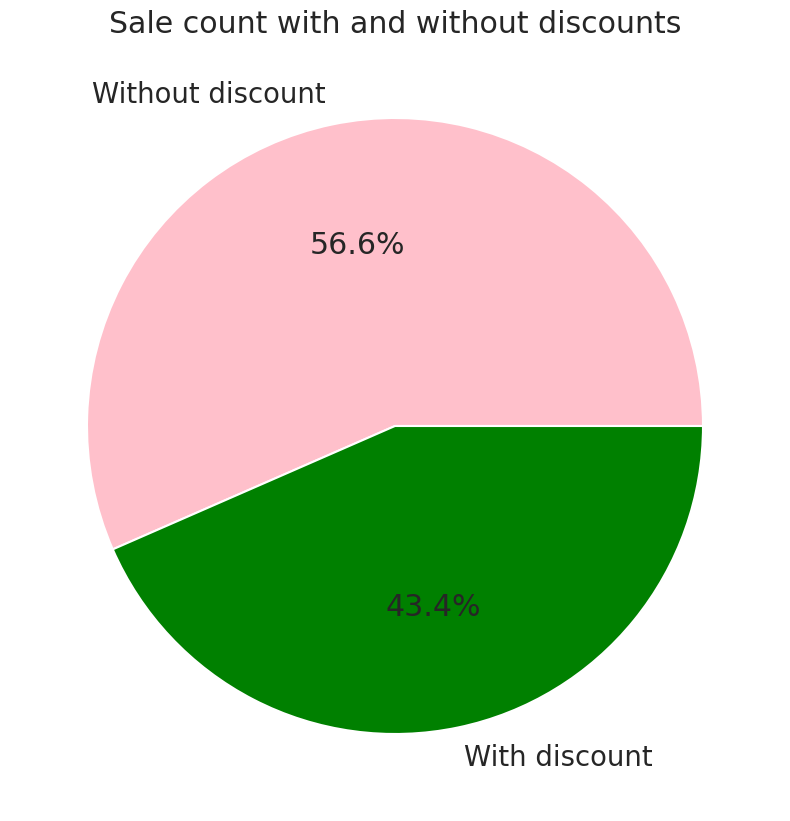

In [27]:
# select all orders with discounts
# count profitable orders
d1 = sales_df[sales_df['discount'] == 0].shape[0]
d2 = sales_df[sales_df['discount'] > 0].shape[0]

# plot pie chart
plt.figure(figsize=(20, 10))
sns.set_context('talk', font_scale=1.2)
plt.pie(
    [d1, d2],
    labels=['Without discount', 'With discount'],
    autopct='%1.1f%%',
    colors=['pink', 'green']
)
# set title
plt.title('Sale count with and without discounts')

Text(0.5, 1.0, 'Mean sales for each discount')

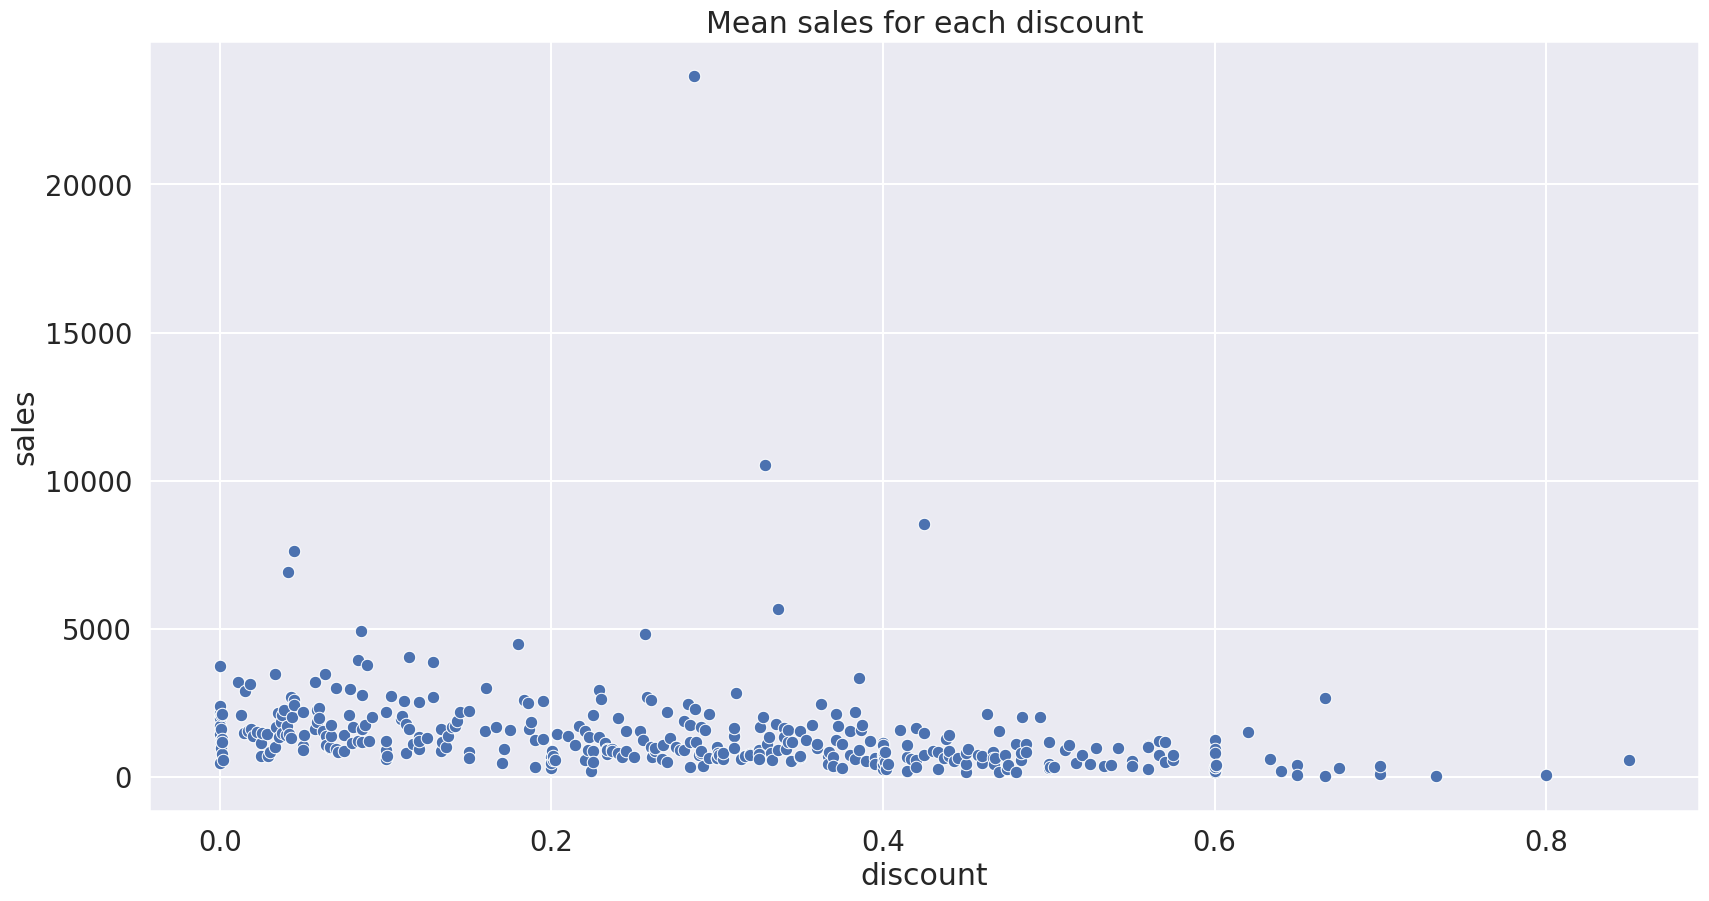

In [28]:
# calculate mean sale for each discount
discounts_df = orders_df.groupby(['discount']).agg({'sales': 'mean'}).reset_index()

# plot relation between discounts and sales
plt.figure(figsize=(20, 10))
sns.set_context('talk', font_scale=1.2)
sns.scatterplot(
    data=discounts_df,
    x='discount',
    y='sales'
).set_title('Mean sales for each discount')


(-0.01, 0.805)

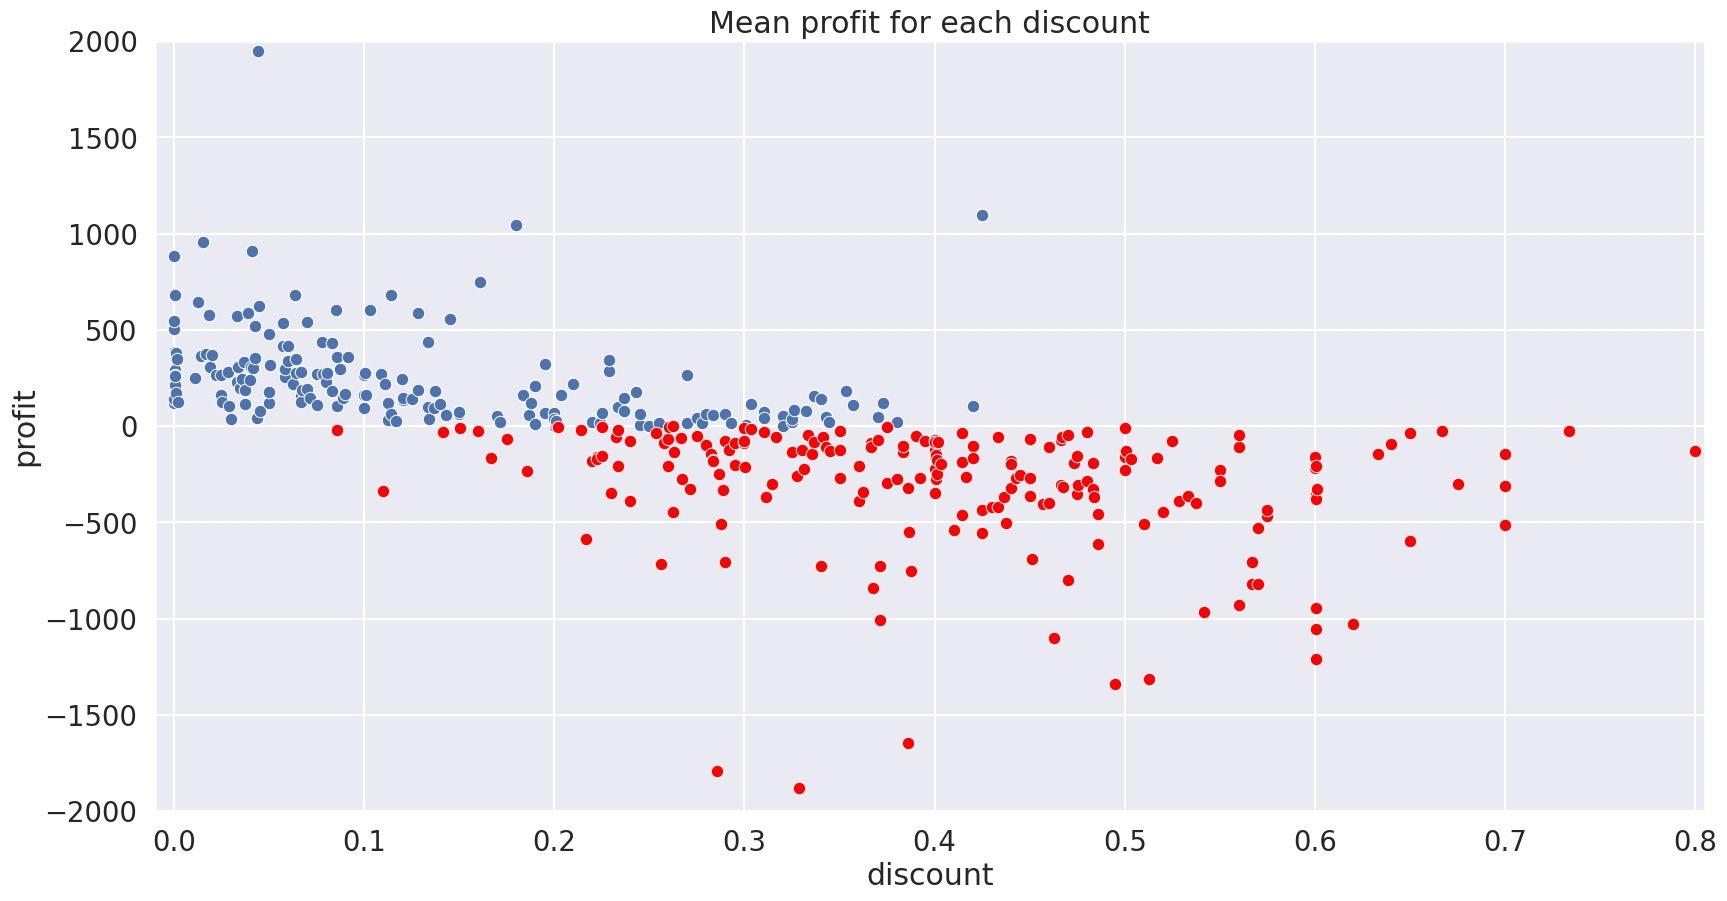

In [29]:
# calculate mean profit for each discount
discounts_df = orders_df.groupby(['discount']).agg({'profit': 'mean'}).reset_index()
discounts_df_a0 = discounts_df[discounts_df['profit'] > 0]
discounts_df_b0 = discounts_df[discounts_df['profit'] <= 0]

plt.figure(figsize=(20, 10))
sns.set_context('talk', font_scale=1.2)
sns.scatterplot(
    data=discounts_df_a0,
    x='discount',
    y='profit'
).set_title('Mean profit for each discount')

sns.scatterplot(
    data=discounts_df_b0,
    x='discount',
    y='profit',
    color='red'
).set_title('Mean profit for each discount')

# set y range
plt.ylim(-2000, 2000)
plt.xlim(-0.01, 0.805)

(-0.01, 0.805)

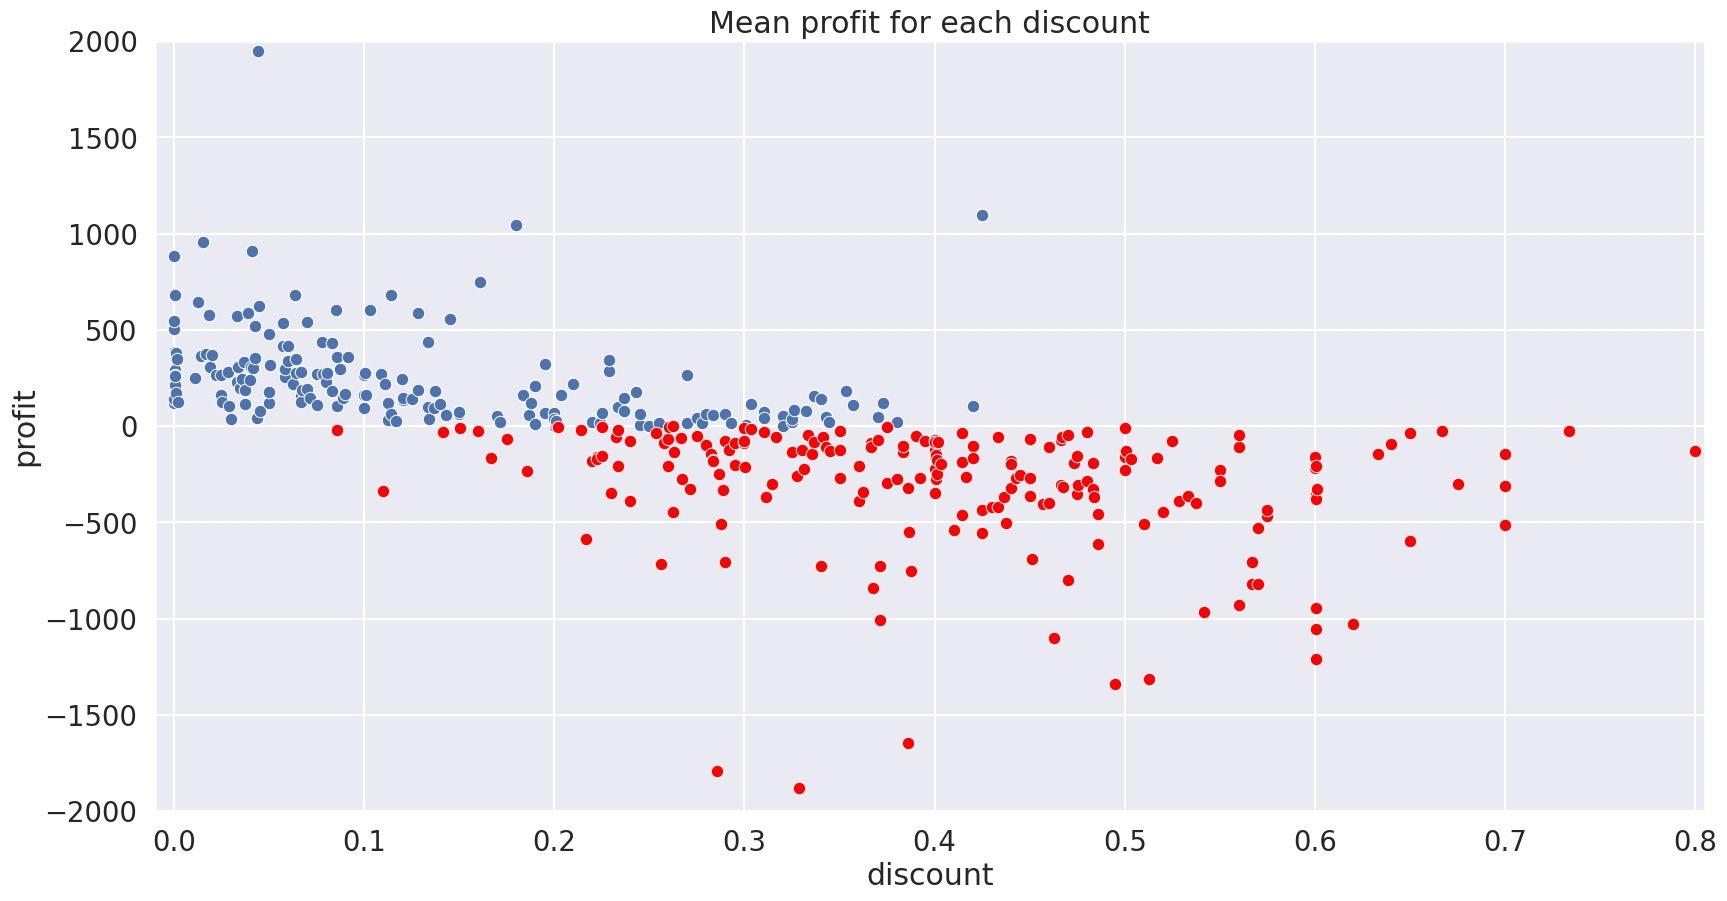

In [30]:
# calculate mean profit for each discount
discounts_df = orders_df.groupby(['discount']).agg({'profit': 'mean'}).reset_index()
discounts_df_a0 = discounts_df[discounts_df['profit'] > 0]
discounts_df_b0 = discounts_df[discounts_df['profit'] <= 0]

plt.figure(figsize=(20, 10))
sns.set_context('talk', font_scale=1.2)
sns.scatterplot(
    data=discounts_df_a0,
    x='discount',
    y='profit'
).set_title('Mean profit for each discount')

sns.scatterplot(
    data=discounts_df_b0,
    x='discount',
    y='profit',
    color='red'
).set_title('Mean profit for each discount')

# set y range
plt.ylim(-2000, 2000)
plt.xlim(-0.01, 0.805)

Text(0.5, 1.0, 'Profitable and unprofitable sales with discounts')

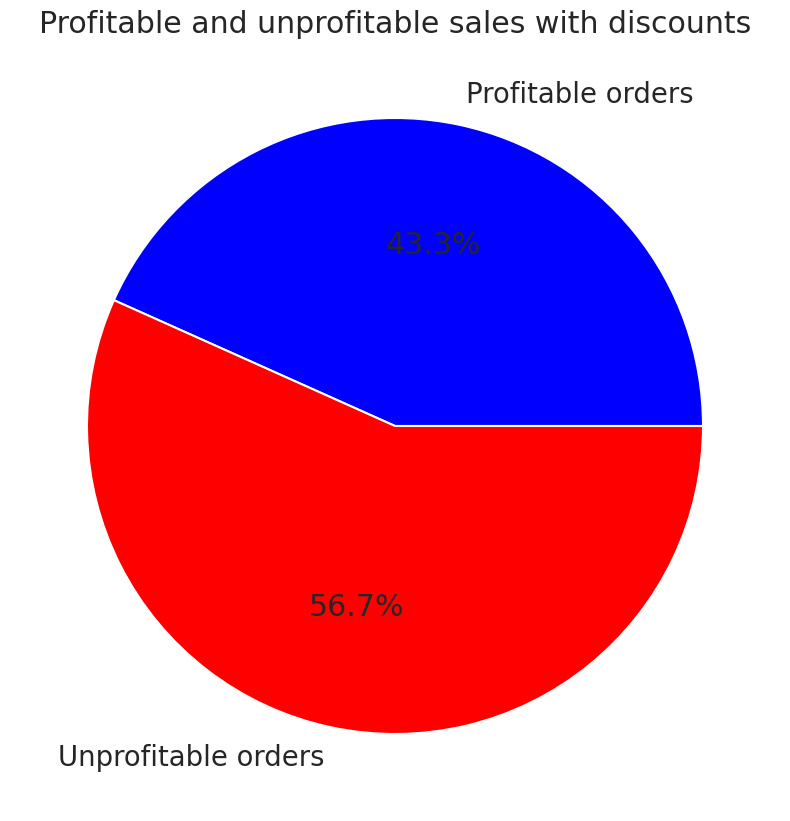

In [31]:
# select all orders with discounts
discounts_df = sales_df[sales_df['discount'] > 0]
# count profitable orders
profitable_orders = discounts_df[discounts_df['profit'] > 0].shape[0]
unprofitable_orders = discounts_df[discounts_df['profit'] <= 0].shape[0]

# plot pie chart
plt.figure(figsize=(20, 10))
sns.set_context('talk', font_scale=1.2)
plt.pie(
    [profitable_orders, unprofitable_orders],
    labels=['Profitable orders', 'Unprofitable orders'],
    autopct='%1.1f%%',
    colors=['blue', 'red']
)
# set title
plt.title('Profitable and unprofitable sales with discounts')

## Product categories

In [32]:
category_palette = {
    'Accessories': '#FFC0CB',
    'Art': '#FF0000',
    'Binders': '#FFA500',
    'Bookcases': '#FFFF00',
    'Chairs': '#00FF00',
    'Copiers': '#00FFFF',
    'Envelopes': '#008080',
    'Fasteners': '#0000FF',
    'Furnishings': '#800080',
    'Labels': '#FF00FF',
    'Machines': '#808000',
    'Paper': '#008000',
    'Phones': '#800000',
    'Storage': '#000080',
    'Supplies': '#808080',
    'Tables': '#C0C0C0',
    'Appliances': '#000000'
}

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16]),
 [Text(0, 0, 'Copiers'),
  Text(1, 0, 'Phones'),
  Text(2, 0, 'Bookcases'),
  Text(3, 0, 'Appliances'),
  Text(4, 0, 'Chairs'),
  Text(5, 0, 'Accessories'),
  Text(6, 0, 'Storage'),
  Text(7, 0, 'Binders'),
  Text(8, 0, 'Paper'),
  Text(9, 0, 'Machines'),
  Text(10, 0, 'Art'),
  Text(11, 0, 'Furnishings'),
  Text(12, 0, 'Envelopes'),
  Text(13, 0, 'Supplies'),
  Text(14, 0, 'Labels'),
  Text(15, 0, 'Fasteners'),
  Text(16, 0, 'Tables')])

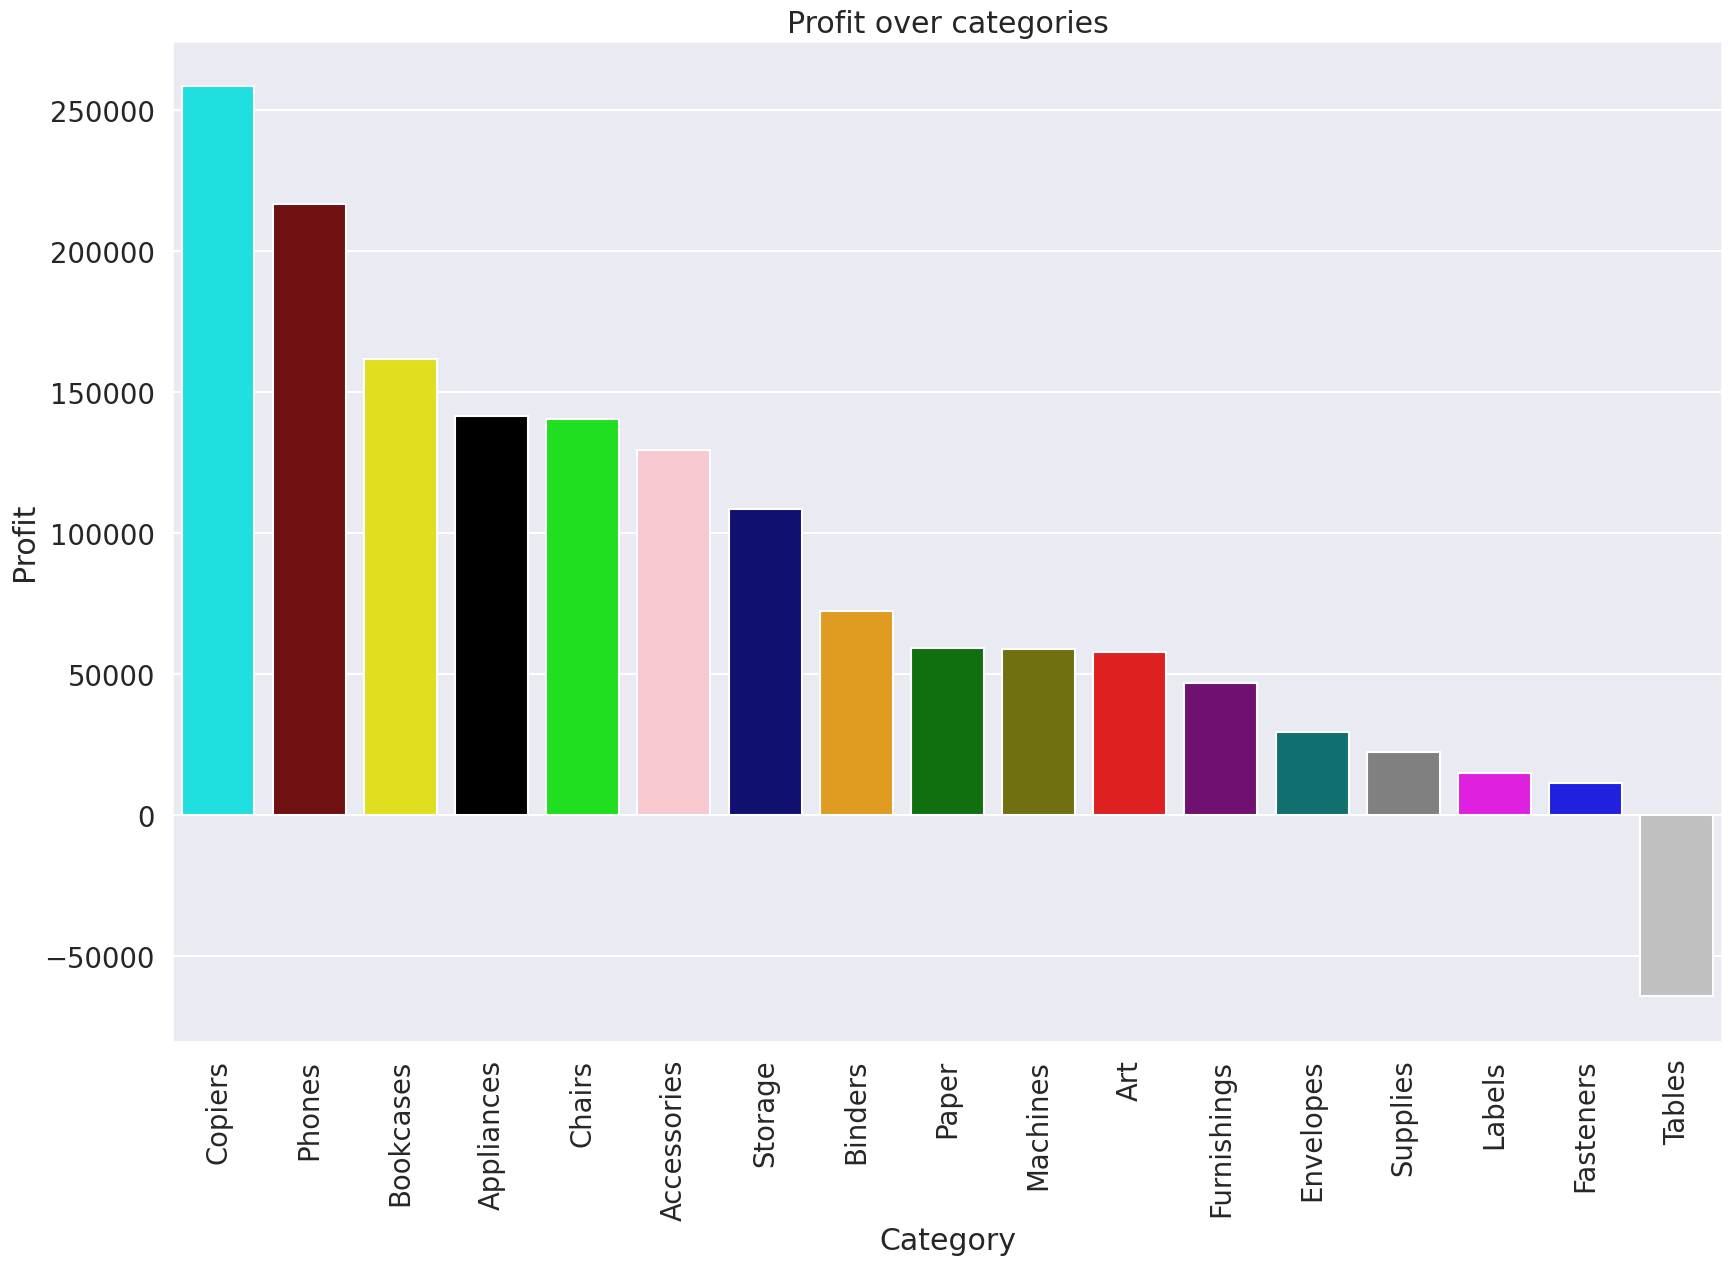

In [33]:
discounts_df = sales_df.groupby(['product_subcategory_name']).agg({'profit': 'sum'}).reset_index()
# sort dataset by sum
discounts_df = discounts_df.sort_values(by=['profit'], ascending=False)

sns.barplot(
    x='product_subcategory_name', y='profit', data=discounts_df,
    palette=category_palette
).set(title='Profit over categories', xlabel='Category', ylabel='Profit')
# set rotation
plt.xticks(rotation=90)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16]),
 [Text(0, 0, 'Paper'),
  Text(1, 0, 'Labels'),
  Text(2, 0, 'Envelopes'),
  Text(3, 0, 'Binders'),
  Text(4, 0, 'Furnishings'),
  Text(5, 0, 'Fasteners'),
  Text(6, 0, 'Appliances'),
  Text(7, 0, 'Accessories'),
  Text(8, 0, 'Art'),
  Text(9, 0, 'Copiers'),
  Text(10, 0, 'Bookcases'),
  Text(11, 0, 'Supplies'),
  Text(12, 0, 'Machines'),
  Text(13, 0, 'Chairs'),
  Text(14, 0, 'Phones'),
  Text(15, 0, 'Tables'),
  Text(16, 0, 'Storage')])

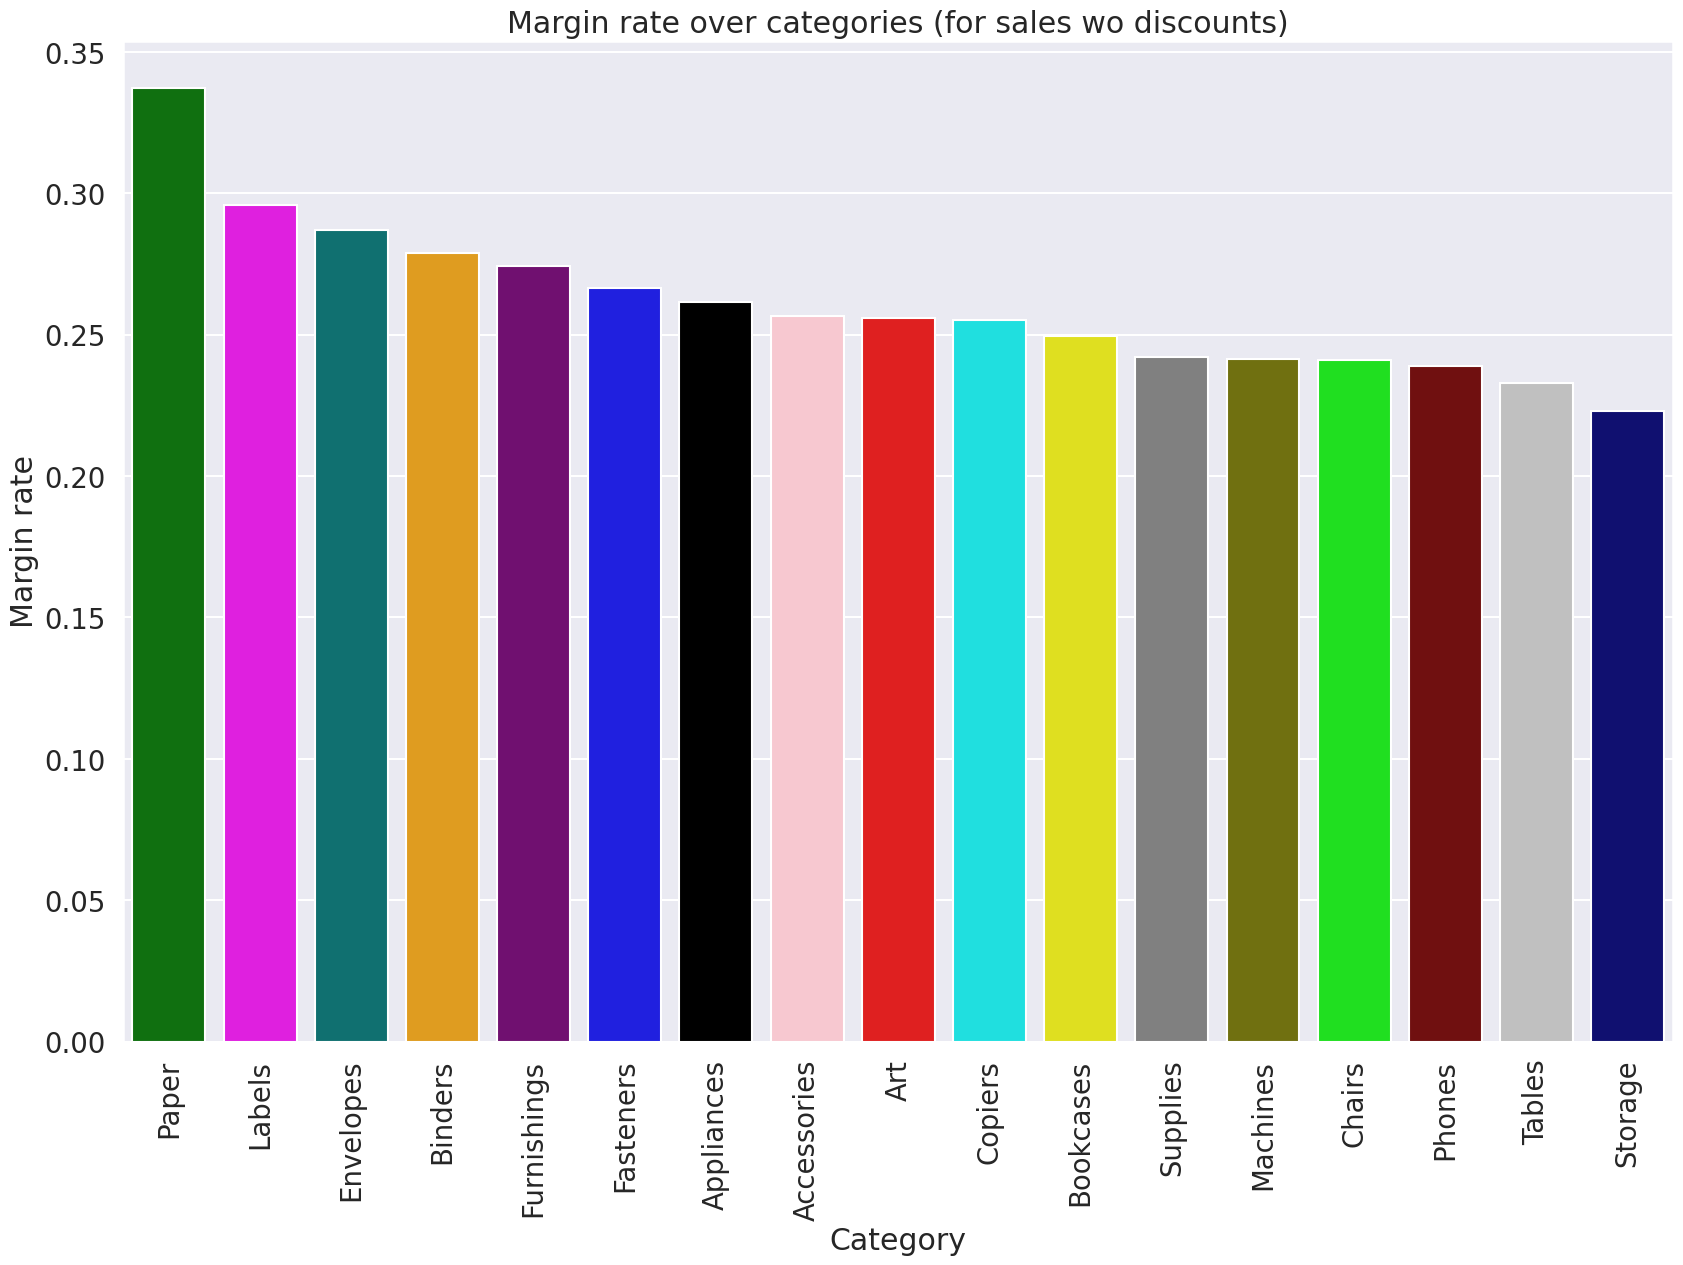

In [34]:
# calculate margin rate for each sale
sales_df['margin_rate'] = sales_df['profit'] / sales_df['sales']

# select only sales with discount=0
sales_df_d0 = sales_df[sales_df['discount'] == 0]

# calculate mean margin rate for each category
margin_rate_df = sales_df_d0.groupby(['product_subcategory_name']).agg({'margin_rate': 'mean'}).reset_index()

# sort dataset by margin rate
margin_rate_df = margin_rate_df.sort_values(by=['margin_rate'], ascending=False)

sns.barplot(
    x='product_subcategory_name', y='margin_rate', data=margin_rate_df,
    palette=category_palette
).set(title='Margin rate over categories (for sales wo discounts)', xlabel='Category', ylabel='Margin rate')
# set rotation
plt.xticks(rotation=90)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16]),
 [Text(0, 0, 'Paper'),
  Text(1, 0, 'Labels'),
  Text(2, 0, 'Envelopes'),
  Text(3, 0, 'Accessories'),
  Text(4, 0, 'Copiers'),
  Text(5, 0, 'Art'),
  Text(6, 0, 'Fasteners'),
  Text(7, 0, 'Furnishings'),
  Text(8, 0, 'Supplies'),
  Text(9, 0, 'Phones'),
  Text(10, 0, 'Chairs'),
  Text(11, 0, 'Bookcases'),
  Text(12, 0, 'Storage'),
  Text(13, 0, 'Binders'),
  Text(14, 0, 'Appliances'),
  Text(15, 0, 'Machines'),
  Text(16, 0, 'Tables')])

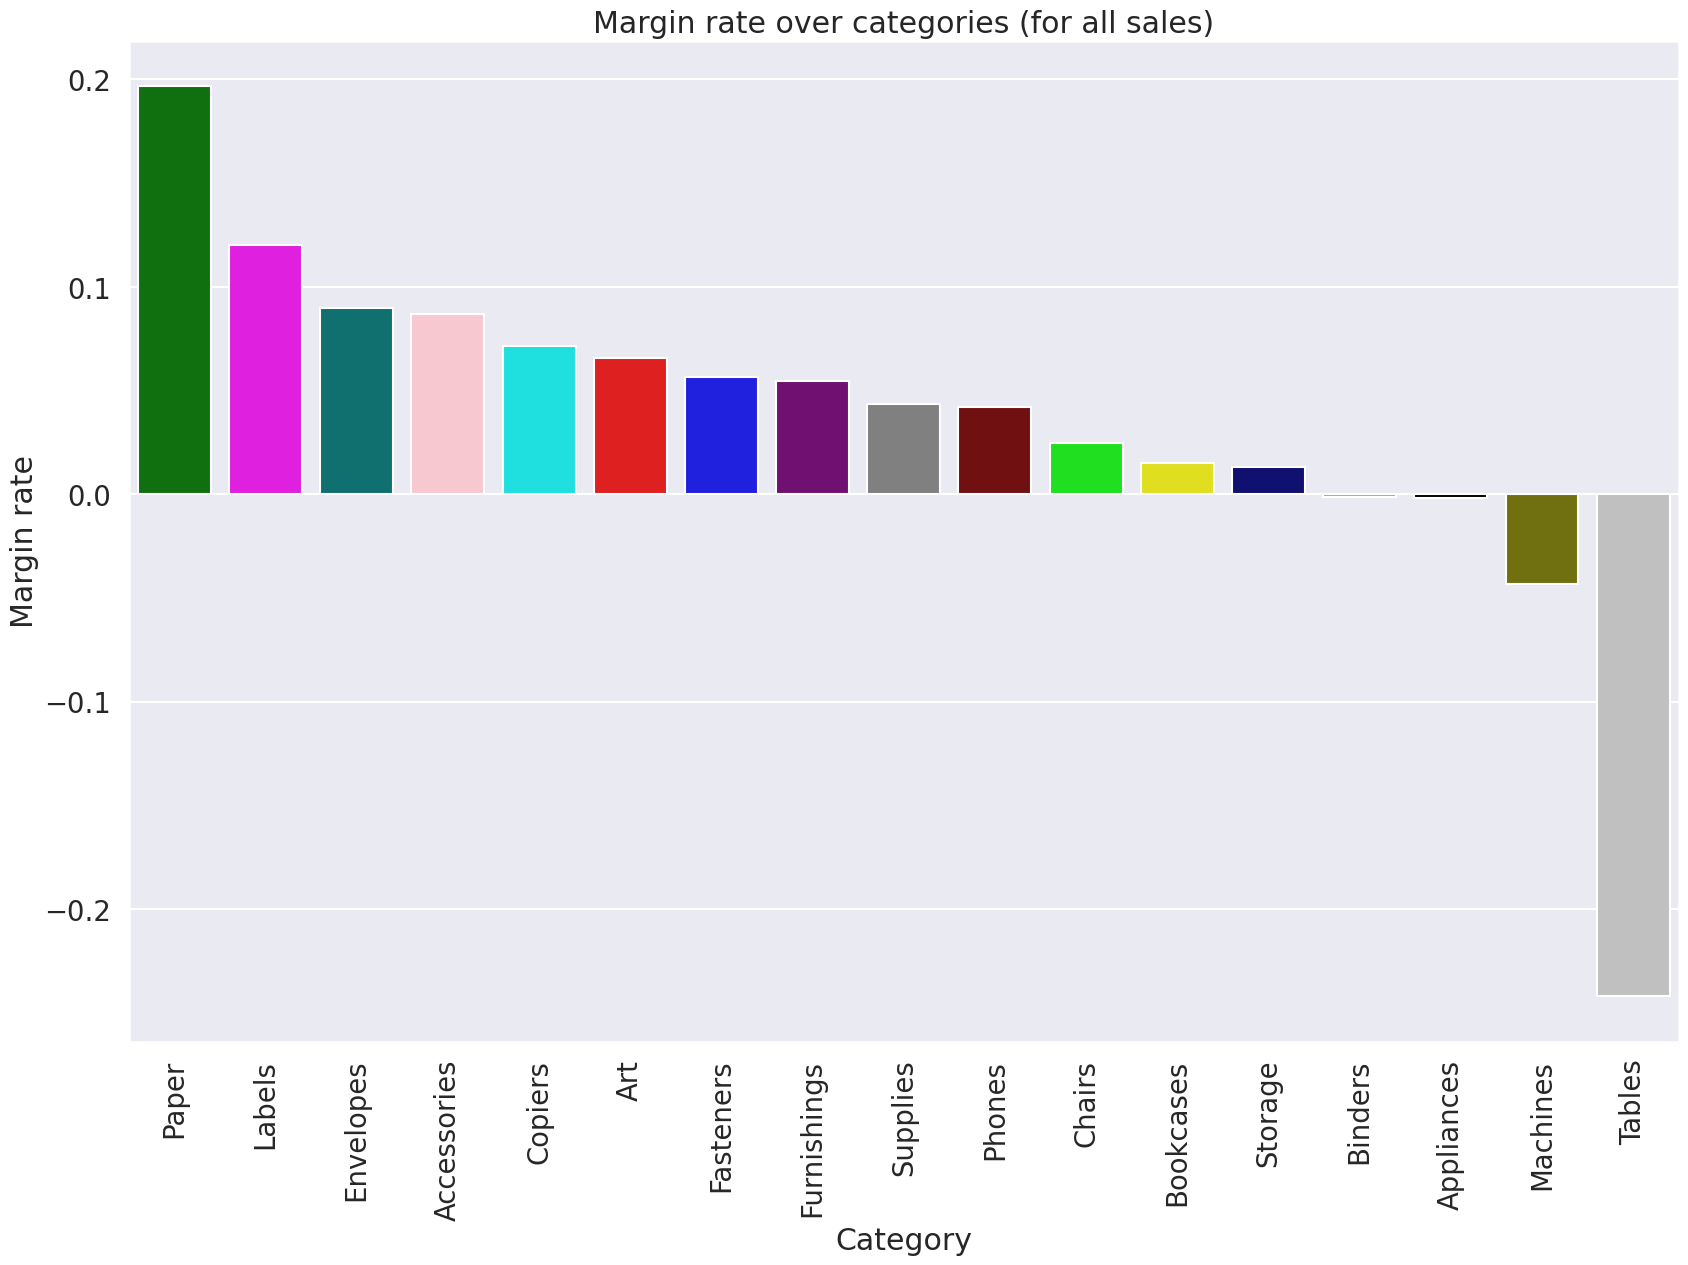

In [35]:
# calculate mean margin rate for each category
margin_rate_df = sales_df.groupby(['product_subcategory_name']).agg({'margin_rate': 'mean'}).reset_index()

# sort dataset by margin rate
margin_rate_df = margin_rate_df.sort_values(by=['margin_rate'], ascending=False)

sns.barplot(
    x='product_subcategory_name', y='margin_rate', data=margin_rate_df,
    palette=category_palette
).set(title='Margin rate over categories (for all sales)', xlabel='Category', ylabel='Margin rate')
# set rotation
plt.xticks(rotation=90)

/tmp/ipykernel_3286/4190209078.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tables_df['order_date'] = pd.to_datetime(tables_df['order_date'])
/tmp/ipykernel_3286/4190209078.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tables_df['order_year_month'] = tables_df['order_date'].dt.strftime('%Y-%m')


([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47],
 [Text(0, 0, '2011-01'),
  Text(1, 0, '2011-02'),
  Text(2, 0, '2011-03'),
  Text(3, 0, '2011-04'),
  Text(4, 0, '2011-05'),
  Text(5, 0, '2011-06'),
  Text(6, 0, '2011-07'),
  Text(7, 0, '2011-08'),
  Text(8, 0, '2011-09'),
  Text(9, 0, '2011-10'),
  Text(10, 0, '2011-11'),
  Text(11, 0, '2011-12'),
  Text(12, 0, '2012-01'),
  Text(13, 0, '2012-02'),
  Text(14, 0, '2012-03'),
  Text(15, 0, '2012-04'),
  Text(16, 0, '2012-05'),
  Text(17, 0, '2012-06'),
  Text(18, 0, '2012-07'),
  Text(19, 0, '2012-08'),
  Text(20, 0, '2012-09'),
  Text(21, 0, '2012-10'),
  Text(22, 0, '2012-11'),
  Text(23, 0, '2012-12'),
  Text(24, 0, '2013-01'),
  Text(25, 0, '2013-02'),
  Text(26, 0, '2013-03'),
  Text(27, 0, '2013-04'),
  T

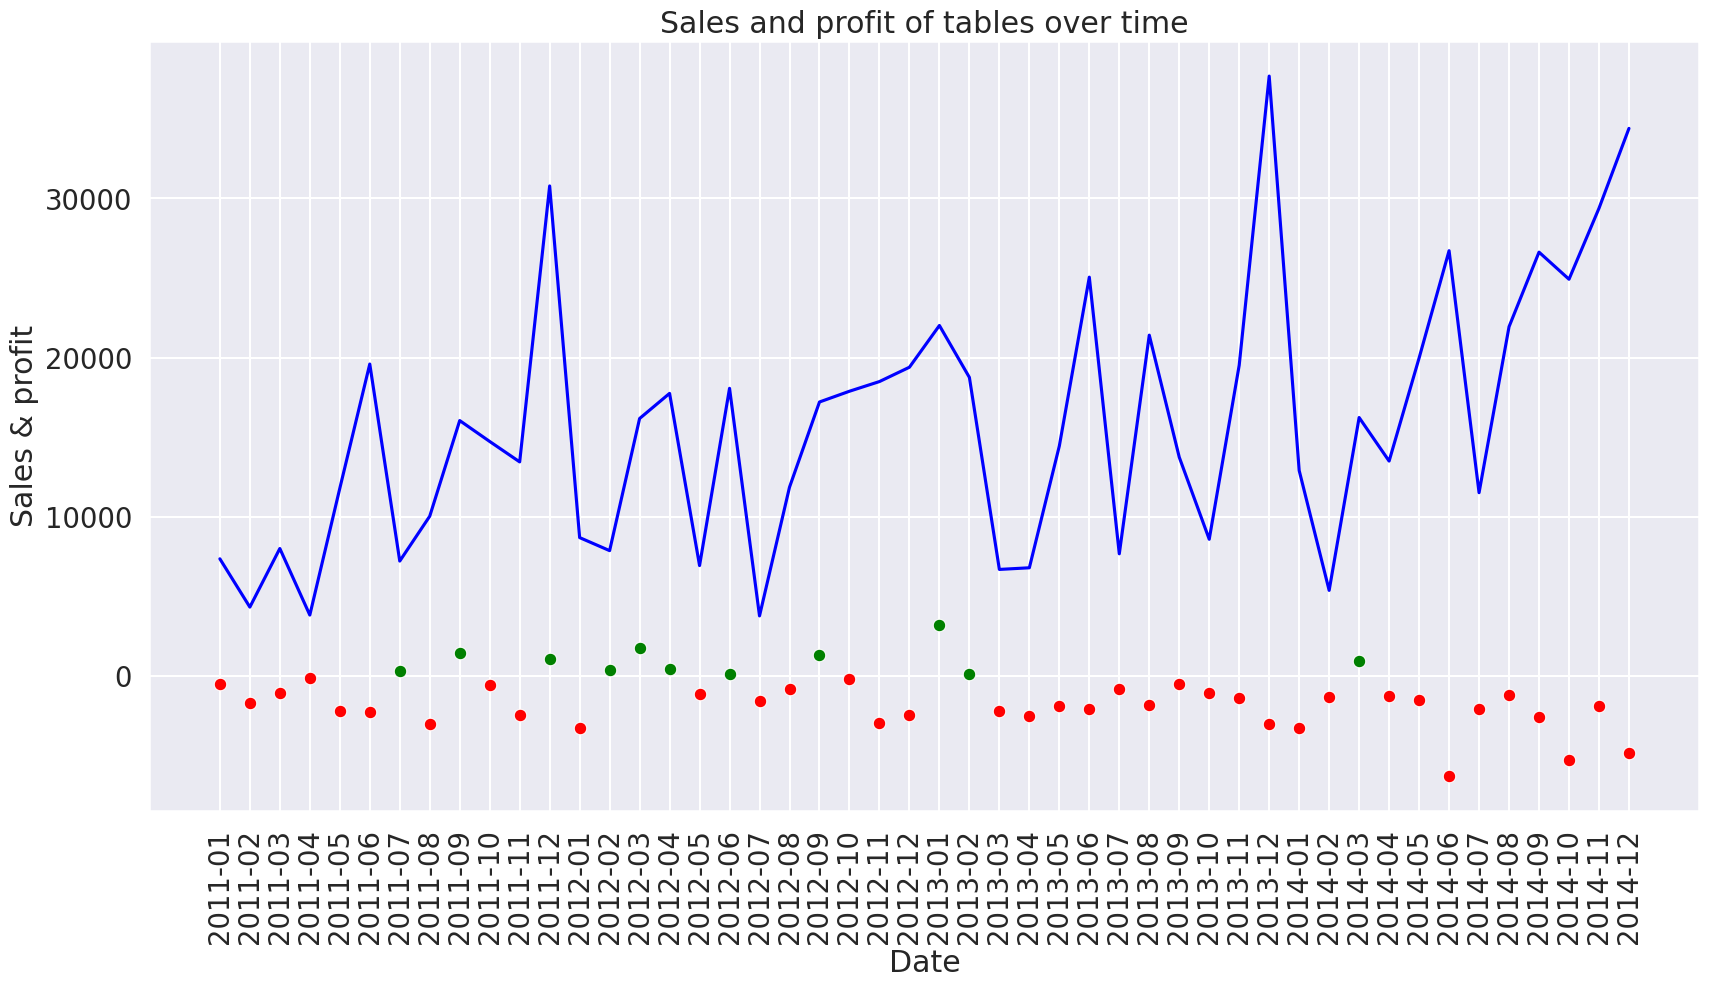

In [36]:
# sales of tables over time
tables_df = sales_df[sales_df['product_subcategory_name'] == 'Tables']

tables_df['order_date'] = pd.to_datetime(tables_df['order_date'])

# create a year-month column
tables_df['order_year_month'] = tables_df['order_date'].dt.strftime('%Y-%m')

d1 = tables_df.groupby(['order_year_month']).agg({'sales': 'sum'}).reset_index()
d_profit = tables_df.groupby(['order_year_month']).agg({'profit': 'sum'}).reset_index()
d2 = d_profit[d_profit['profit'] > 0]
d3 = d_profit[d_profit['profit'] <= 0]

# plot sales over time with line plot
plt.figure(figsize=(20, 10))
sns.set_context('talk', font_scale=1.2)
sns.lineplot(
    data=d1,
    x='order_year_month',
    y='sales',
    color='blue'
).set(title='Sales and profit of tables over time', xlabel='Date', ylabel='Sales & profit')

sns.scatterplot(
    data=d2,
    x='order_year_month',
    y='profit',
    color='green'
)

sns.scatterplot(
    data=d3,
    x='order_year_month',
    y='profit',
    color='red'
)


# rotate x labels
plt.xticks(rotation=90)


In [37]:
## Geography

In [39]:
# get city data from sqlite
sql = """
    SELECT
        cities.name AS city_name,
        countries.name AS country_name,
        cities.lat,
        cities.lng,
        SUM(order_products.sales) AS sum_sales,
        AVG(order_products.sales) AS avg_sales,
        COUNT(order_products.sales) AS cnt_sales,
        AVG(order_products.shipping_cost) AS avg_shipping_cost
    FROM
        cities
        JOIN countries ON cities.country_id = countries.id
        JOIN customers ON customers.city_id = cities.id
        JOIN orders ON orders.customer_id = customers.id
        JOIN order_products ON orders.id = order_products.order_id
    WHERE cities.lat IS NOT NULL AND cities.lng IS NOT NULL
    GROUP BY cities.id
"""
cities_df = q(sql, cur)
display(cities_df)

city_name country_name       lat        lng   sum_sales   avg_sales  \
0          Aachen      Germany  50.77664    6.08342  11845.7282  227.802465   
1           Accra        Ghana   5.55602   -0.19690   6099.2460  152.481150   
2    Ad Diwaniyah         Iraq  31.99289   44.92552   5241.9000  209.676000   
3        Ad Diwem        Sudan  14.00120   32.31160    424.5300   84.906000   
4           Adana       Turkey  36.98615   35.32531   6009.3660  158.141211   
..            ...          ...       ...        ...         ...         ...   
848       Zapopan       Mexico  20.72356 -103.38479  10693.0180  237.622622   
849         Zaria      Nigeria  11.11128    7.72270   1745.9970  174.599700   
850      Zhytomyr      Ukraine  50.26487   28.67669   9116.3880  260.468229   
851        Zigong        China  29.34162  104.77689   9929.7040  367.766815   
852      Zlatoust       Russia  55.17111   59.65083   1110.0240  123.336000   

     cnt_sales  avg_shipping_cost  
0           52          23.826538  
1           40          12.859000  
2           25          25.348000  
3            5           7.032000  
4           38          21.486579  
..         ...                ...  
848         45          28.729333  
849         10          18.855000  
850         35          32.738286  
851         27          55.192222  
852          9          12.451111  

[853 rows x 8 columns]

In [40]:
def get_city_df_for_period(start, end):
    sql = """
    SELECT
        cities.name AS city_name,
        countries.name AS country_name,
        cities.lat,
        cities.lng,
        SUM(order_products.sales) AS sum_sales,
        AVG(order_products.sales) AS avg_sales,
        COUNT(order_products.sales) AS cnt_sales
    FROM
        cities
        JOIN countries ON cities.country_id = countries.id
        JOIN customers ON customers.city_id = cities.id
        JOIN orders ON orders.customer_id = customers.id
        JOIN order_products ON orders.id = order_products.order_id
    WHERE
        cities.lat IS NOT NULL
        AND cities.lng IS NOT NULL
        AND orders.order_date BETWEEN '{start}' AND '{end}'
    GROUP BY cities.id
    """.format(start=start, end=end)
    return q(sql, cur)


<AxesSubplot: xlabel='lng', ylabel='lat'>

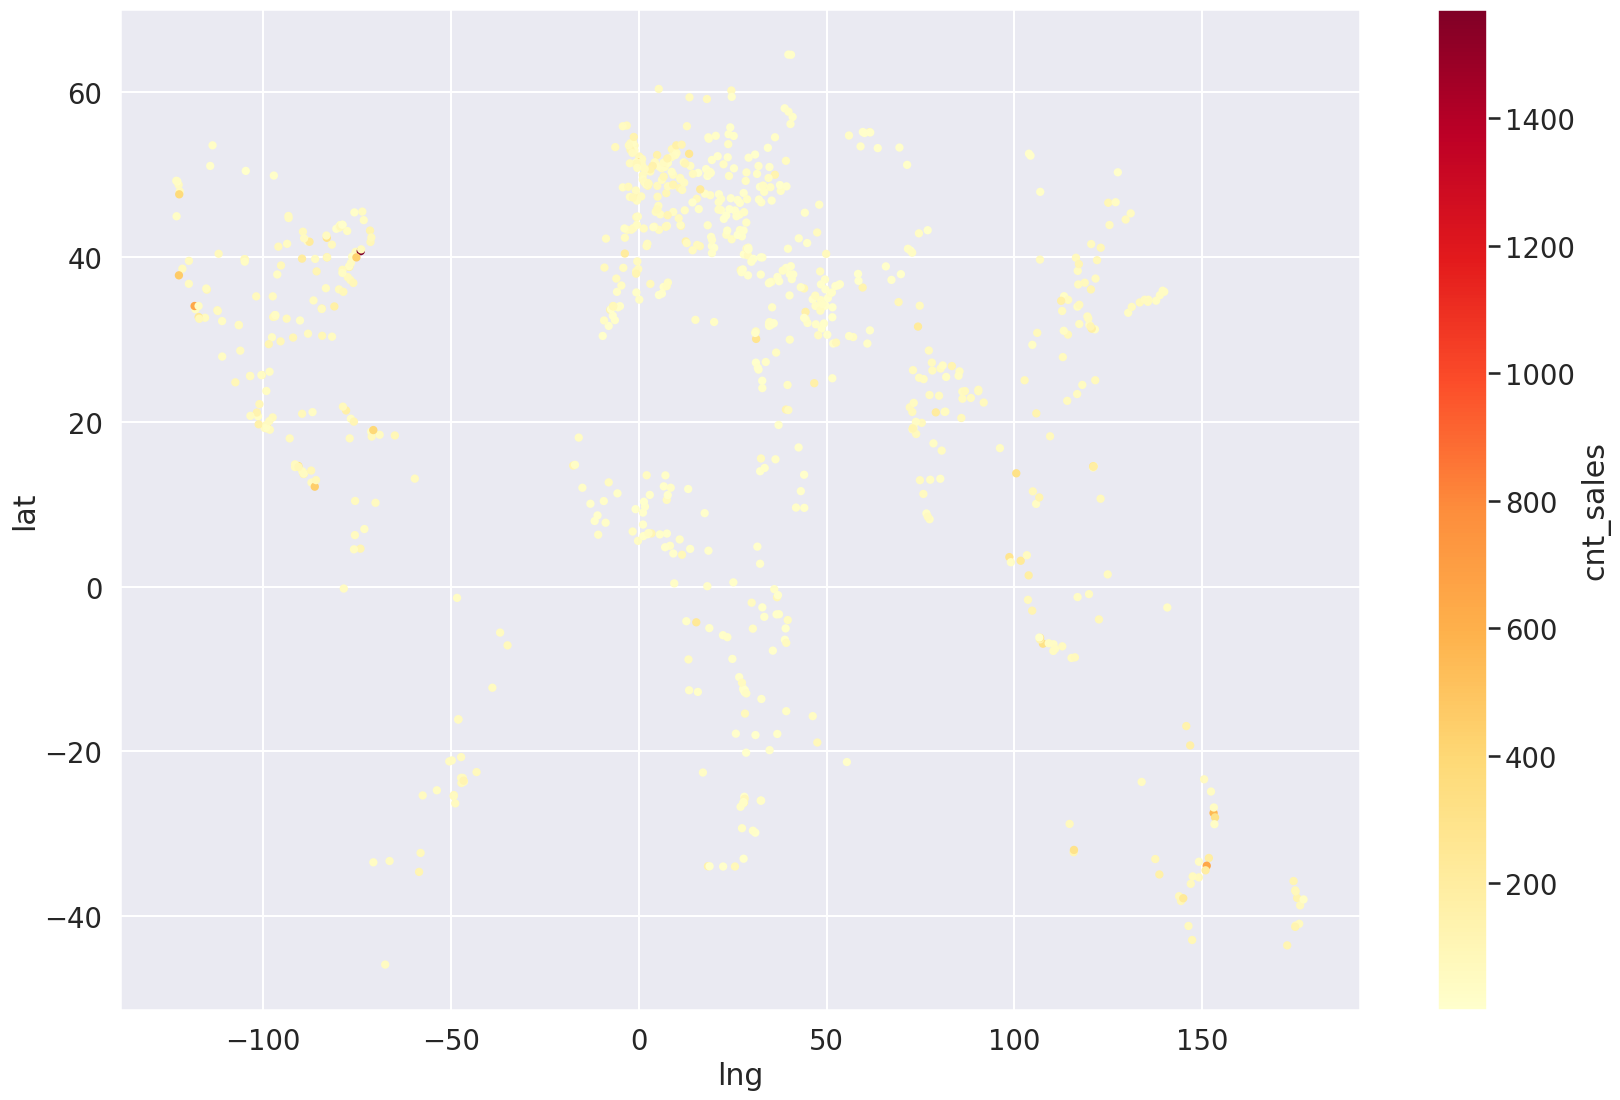

In [41]:
cities_df.plot(x="lng", y="lat", kind="scatter", c="cnt_sales",
        colormap="YlOrRd")

In [43]:
import geopandas as gpd
countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
countries.head()

/tmp/ipykernel_3286/2807769159.py:2: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))


pop_est      continent                      name iso_a3  gdp_md_est  \
0     889953.0        Oceania                      Fiji    FJI        5496   
1   58005463.0         Africa                  Tanzania    TZA       63177   
2     603253.0         Africa                 W. Sahara    ESH         907   
3   37589262.0  North America                    Canada    CAN     1736425   
4  328239523.0  North America  United States of America    USA    21433226   

                                            geometry  
0  MULTIPOLYGON (((180.00000 -16.06713, 180.00000...  
1  POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...  
2  POLYGON ((-8.66559 27.65643, -8.66512 27.58948...  
3  MULTIPOLYGON (((-122.84000 49.00000, -122.9742...  
4  MULTIPOLYGON (((-122.84000 49.00000, -120.0000...

In [ ]:
countries.plot(color="lightgrey")

<Figure size 2000x1000 with 0 Axes>

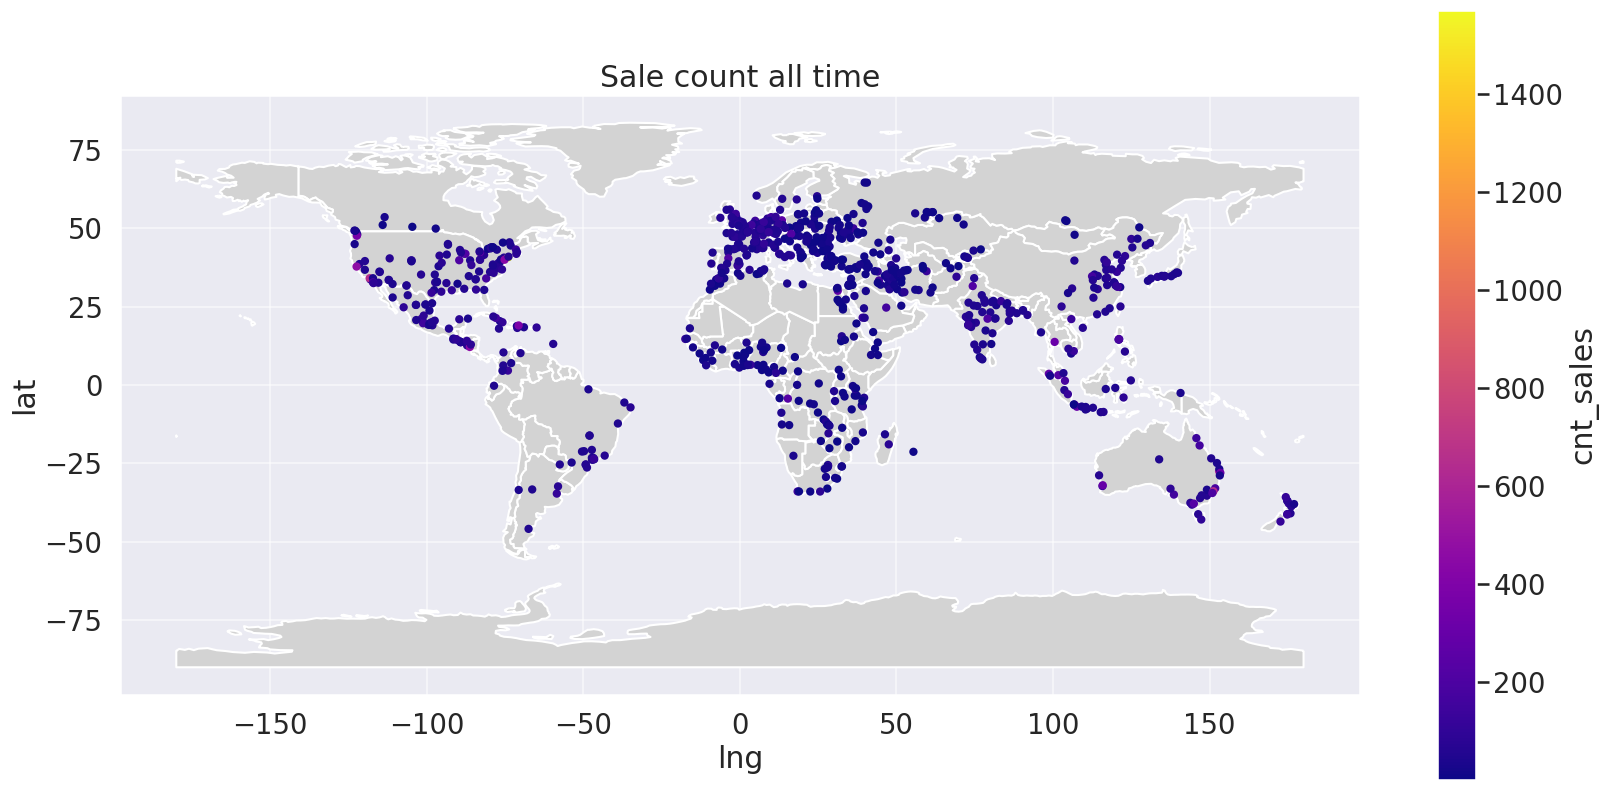

In [45]:
# initialize an axis
plt.figure(figsize=(20, 10))
sns.set_context('talk', font_scale=1.2)

fig, ax = plt.subplots(figsize=(20,10))# plot map on axis
countries.plot(color="lightgrey", ax=ax)# parse dates for plot's title
cities_df.plot(
    x="lng",
    y="lat",
    kind="scatter",
    c="cnt_sales",
    colormap="plasma", ax=ax
)

ax.grid(visible=True, alpha=0.5)
plt.title("Sale count all time")
plt.show()

In [ ]:
plt.figure(figsize=(20, 10))
sns.set_context('talk', font_scale=1.2)

fig, ax = plt.subplots(figsize=(20,10)) # plot map on axis

countries.plot(color="lightgrey", ax=ax) # parse dates for plot's title
cities_df.plot(
    x="lng",
    y="lat",
    kind="scatter",
    c="sum_sales",
    colormap="plasma", ax=ax
)

ax.grid(visible=True, alpha=0.5)
plt.title("Sale sum all time")
plt.show()

In [ ]:
# generate list with date periods from 2011 until 2014 by month
date_periods = pd.date_range(start='2011-01-01', end='2022-12-01', freq='MS')
display(date_periods)


In [ ]:
from matplotlib.animation import FuncAnimation
from celluloid import Camera

sns.set_context('talk', font_scale=1.2)
fig = plt.figure(figsize=(20,10)) # plot map on axis
camera = Camera(fig)

for dt in date_periods :
    # plot countries
    cdf = get_city_df_for_period(date_periods[0], dt)
    countries.plot(color="lightgrey", ax=fig.gca()) # parse dates for plot's title
    plt.scatter(cdf['lng'], cdf['lat'], c=cdf['sum_sales'], cmap='plasma')
    my = dt.strftime('%Y-%m')
    plt.clim(0,50000)
    if my >= '2014-12':
        my = '2014-12'
    plt.text(-170, -60, my, fontsize=36)
    plt.title(f"Sum of sales by city")
    plt.xlabel('')
    plt.ylabel('')
    # remove x and y ticks
    plt.xticks([])
    plt.yticks([])
    camera.snap()

animation = camera.animate(interval=300, repeat=False)
animation.save('demo-graphs/30-sum-sales-by-month.gif', writer='pillow')

In [ ]:
from celluloid import Camera

sns.set_context('talk', font_scale=0.8)
fig = plt.figure(figsize=(10,10))
camera = Camera(fig)

for dt in date_periods :
    cdf = get_city_df_for_period(date_periods[0], dt)
    # get top ten cities by sales
    cdf = cdf.sort_values(by='sum_sales', ascending=False).head(10)
    sns.barplot(
        data=cdf,
        y='city_name',
        x='sum_sales',
        palette='plasma_r',
        ax=fig.gca()
    )
    plt.title(f"Best cities by sales")
    plt.tight_layout()
    plt.xlabel('Sum of sales')
    plt.ylabel('')
    camera.snap()

animation = camera.animate(interval=300, repeat=False)
animation.save('demo-graphs/31-best-cities-by-sales.gif', writer='pillow')

## Shipping costs

[Text(0.5, 1.0, 'Purchase price and shipping price'),
 Text(0.5, 0, 'Order price'),
 Text(0, 0.5, 'Shipping cost')]

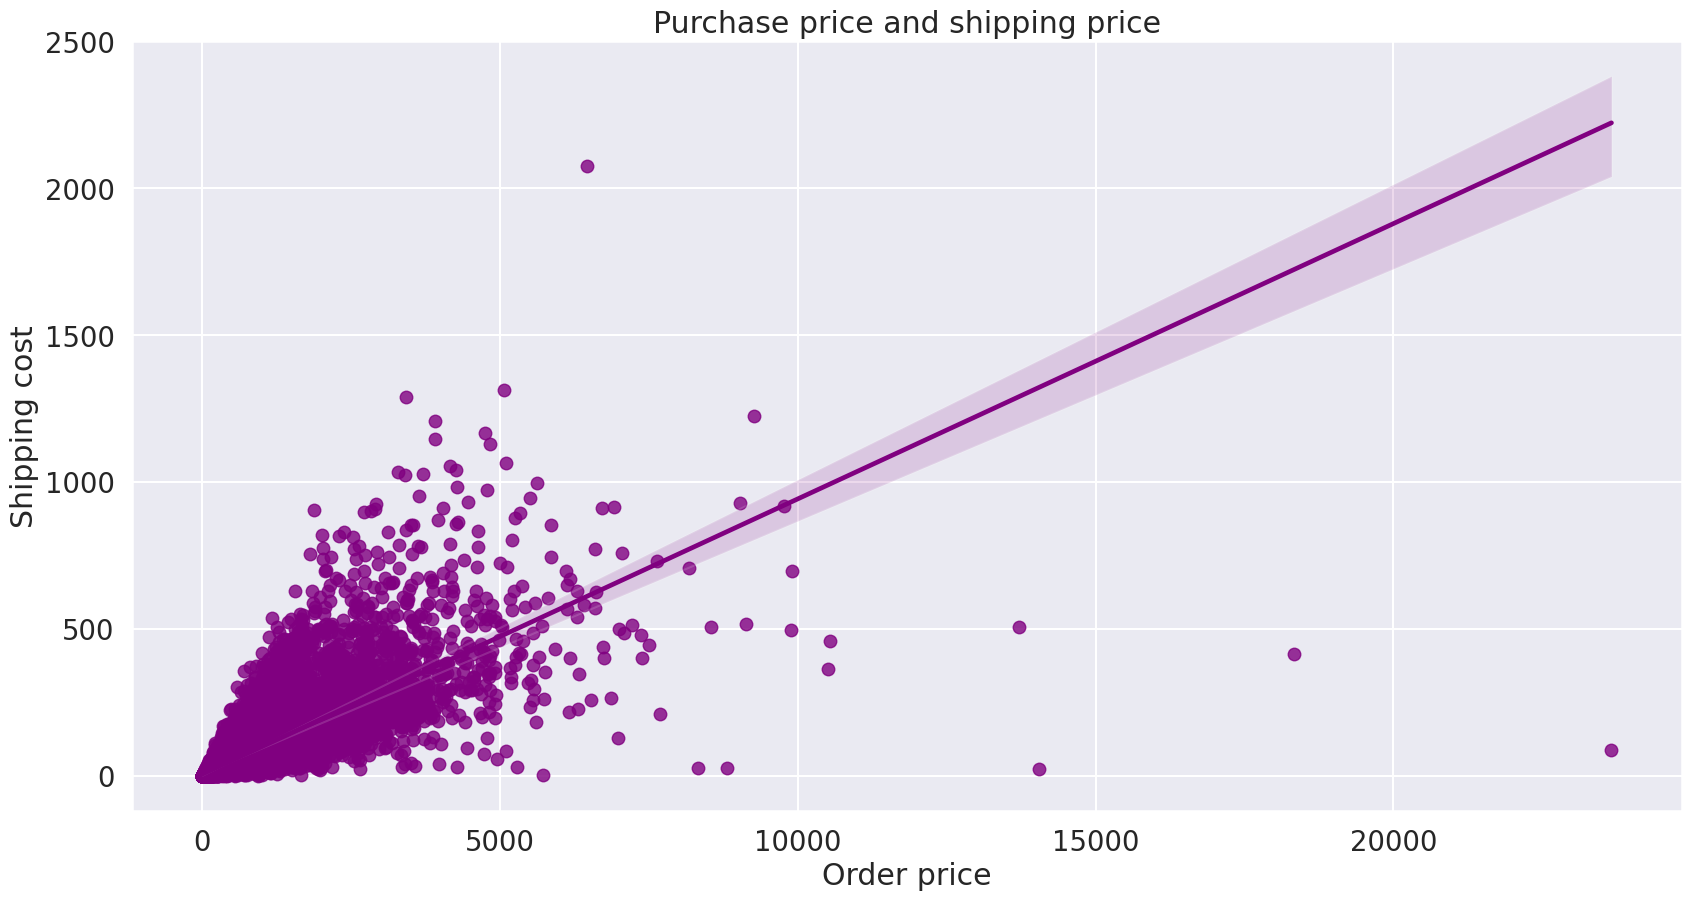

In [54]:
plt.figure(figsize=(20, 10))
sns.set_context('talk', font_scale=1.2)

# remove outliers

sns.regplot(
    data=orders_df, x="sales", y="shipping_cost", color="purple"
).set(
    title="Purchase price and shipping price",
    xlabel="Order price",
    ylabel="Shipping cost"
)

<Figure size 2000x1000 with 0 Axes>

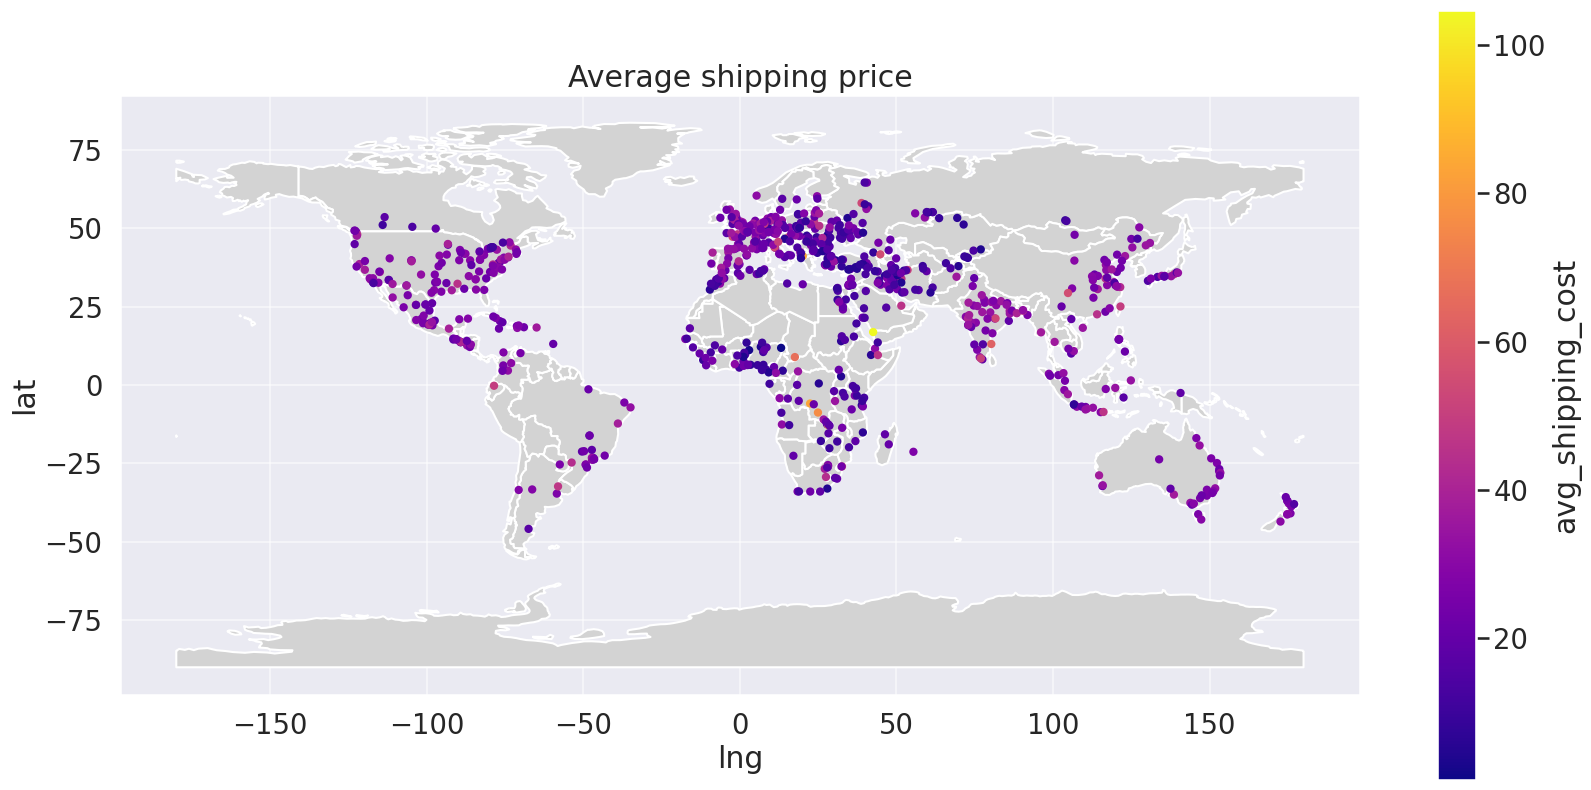

In [50]:
plt.figure(figsize=(20, 10))
sns.set_context('talk', font_scale=1.2)

fig, ax = plt.subplots(figsize=(20,10)) # plot map on axis



countries.plot(color="lightgrey", ax=ax) # parse dates for plot's title
cities_df.plot(
    x="lng",
    y="lat",
    kind="scatter",
    c="avg_shipping_cost",
    colormap="plasma", ax=ax
)

ax.grid(visible=True, alpha=0.5)
plt.title("Average shipping price")
plt.show()